In [51]:
import IMProToo
import xarray as xr
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import proplot as pplt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta   
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from matplotlib.patches import Rectangle
from matplotlib import dates
import seaborn as sns

sns.set(style="whitegrid")

In [52]:
#ds= xr.open_dataset('C:/Users/conym/Desktop/ing/semestre 7/proyecto de datos/0806_mrr2c.nc_1.nc')
ds = xr.open_dataset('C:/Cosas/Universidark/Proyecto de Datos 1/Datos/0806_mrr2c.nc_1.nc')

In [53]:
# Paletas de colores
paleta0 = ['#ccd8ff','#3366ff','#9fdf9f','#00b300','#ffff00','#ffcc30','#e62e00','#ff6600','#fff0e5','#c03fc0','#602060']
paleta1 = ['#ffe5d9','#ffb3b3','#ffcc99','#ffffcc','#ccffcc','#b3e0ff','#b3b3ff','#e5ccff','#ffcce5','#ffd9b3','#ffe5b3']
paleta2 = ['#390099','#6C0079','#9E0059','#CF0057','#FF0054','#FF2A2A','#FF5400','#FF8900','#FFBD00','#FFC317','#FFC82C']
paleta3 = ['#000814','#001329','#001D3D','#002952','#003566','#40594D','#807C33','#A08E27','#C0A01A','#FFC300','#FFD60A']

def add_no_data(ax, times, xlim):
    """Añade área de 'Sin Datos' al gráfico"""
    # Obtener límites actuales del gráfico
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # Verificar si realmente no hay datos
    if len(times) == 0 or (xlim is not None and (times[-1] < xlim[0] or times[0] > xlim[1])):
        # Crear rectángulo sombreado
        rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                           fill=False, hatch='////', edgecolor='gray3',
                           linewidth=0, zorder=10, alpha=0.5)
        ax.add_patch(rect)
        
        # Añadir texto centrado
        ax.text((xmin+xmax)/2, (ymin+ymax)/2, 'SIN DATOS',
               color='red', ha='center', va='center',
               fontsize=12, weight='bold', zorder=11,
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
def plot_mrr2(xlim, times, heights, Ze, Vf=None, hora_local=False, ax=None,
              ytickloc='both', colorhex=paleta0):
    # Configuración de colormap
    cmap4 = list(zip(np.linspace(0, 1, len(colorhex)), colorhex))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom", cmap4)
    dbzmap.set_bad('0.9', 1)
    bounds = np.arange(-5, 50, 1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)

    # Configuración de ejes
    xlabel = r'Hora Local $\rightarrow$' if hora_local else r'Hora UTC $\rightarrow$'
    ylim = [0, 3600] if heights[-1] < 5000 else [0, 8000]

    # Conversión de tiempos a numérico
    times_num = dates.date2num(times)
    xmin, xmax = (dates.date2num(xlim) if xlim != ''
                  else (times_num[0], times_num[-1]))

    # Cálculo de la extensión para imshow
    dx = (times_num[-1] - times_num[0]) / (len(times_num) - 1) if len(times_num) > 1 else 0
    dy = (heights[-1] - heights[0]) / (len(heights) - 1) if len(heights) > 1 else 0

    extent = [
        times_num[0] - dx/2,  # xmin
        times_num[-1] + dx/2,  # xmax
        heights[0] - dy/2,     # ymin
        heights[-1] + dy/2     # ymax
    ]

    # Configuración de ticks según duración
    total_seconds = (xlim[1] - xlim[0]).total_seconds()
    if total_seconds <= 14400:  # ≤ 4 horas
        xlocator = ('hour', range(0, 24, 1))
        xminorlocator = ('minute', 30)
    elif 14400 < total_seconds <= 82800:  # 4-23 horas
        xlocator = ('hour', range(0, 24, 3))
        xminorlocator = ('hour', range(0, 24, 1))
    else:  # > 23 horas
        xlocator = ('hour', range(0, 24, 6))
        xminorlocator = ('hour', range(0, 24, 2))

    if Vf is None:
        # Configuración para un solo gráfico (solo reflectividad)
        if ax is None:
            fig, ax = pplt.subplots(refwidth=5, refaspect=3)

        mZe = ax.imshow(Ze.T,  # Transponer para orientación correcta
                      extent=extent,
                      aspect='auto',
                      origin='lower',
                      norm=norm,
                      cmap=dbzmap,
                      interpolation='nearest')

        ax.format(ultitle='Reflectividad Equivalente',
                xrotation=False,
                xformatter='concise',
                xlocator=xlocator,
                xminorlocator=xminorlocator,
                ylim=ylim,
                yticklabelloc=ytickloc,
                ytickloc='both',
                xticklabelsize=8,
                suptitle='Radar Perfilador MRR en UOH Rancagua',
                ylabel='Altitud [msnm]',
                xlabel=xlabel)
        ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7)

    else:
        # Configuración para dos gráficos (reflectividad y velocidad)
        fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3, sharex=True)

        # Gráfico de reflectividad
        mZe = ax[0].imshow(Ze.T,
                         extent=extent,
                         aspect='auto',
                         origin='lower',
                         norm=norm,
                         cmap=dbzmap,
                         interpolation='nearest')
        add_no_data(ax[0], times, xlim)

        # Gráfico de velocidad
        mVf = ax[1].imshow(Vf.T,
                         extent=extent,
                         aspect='auto',
                         origin='lower',
                         vmin=-3, vmax=10,
                         cmap='RdBu',
                         interpolation='nearest')
        add_no_data(ax[1], times, xlim)

        # Formateo del primer gráfico
        ax[0].format(ultitle='Reflectividad Equivalente',
                   xrotation=False,
                   xformatter='concise',
                   xlocator=xlocator,
                   xminorlocator=xminorlocator,
                   ylim=ylim,
                   yticklabelloc='both',
                   ytickloc='both',
                   xticklabelsize=8,
                   suptitle='Radar Perfilador MRR en UOH Rancagua',
                   ylabel='Altitud [msnm]',
                   xlabel=xlabel)
        ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4)

        # Formateo del segundo gráfico
        ax[1].format(ultitle='Velocidad de caída',
                   xrotation=False,
                   xformatter='concise',
                   xlocator=xlocator,
                   xminorlocator=xminorlocator,
                   ylim=ylim,
                   yticklabelloc='both',
                   ytickloc='both',
                   xticklabelsize=8)
        ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4, extend='both')

    # Ajustar límites de tiempo si se especificaron
    if xlim != '':
        if Vf is None:
            ax.format(xlim=xlim)
        else:
            ax[0].format(xlim=xlim)
            ax[1].format(xlim=xlim)

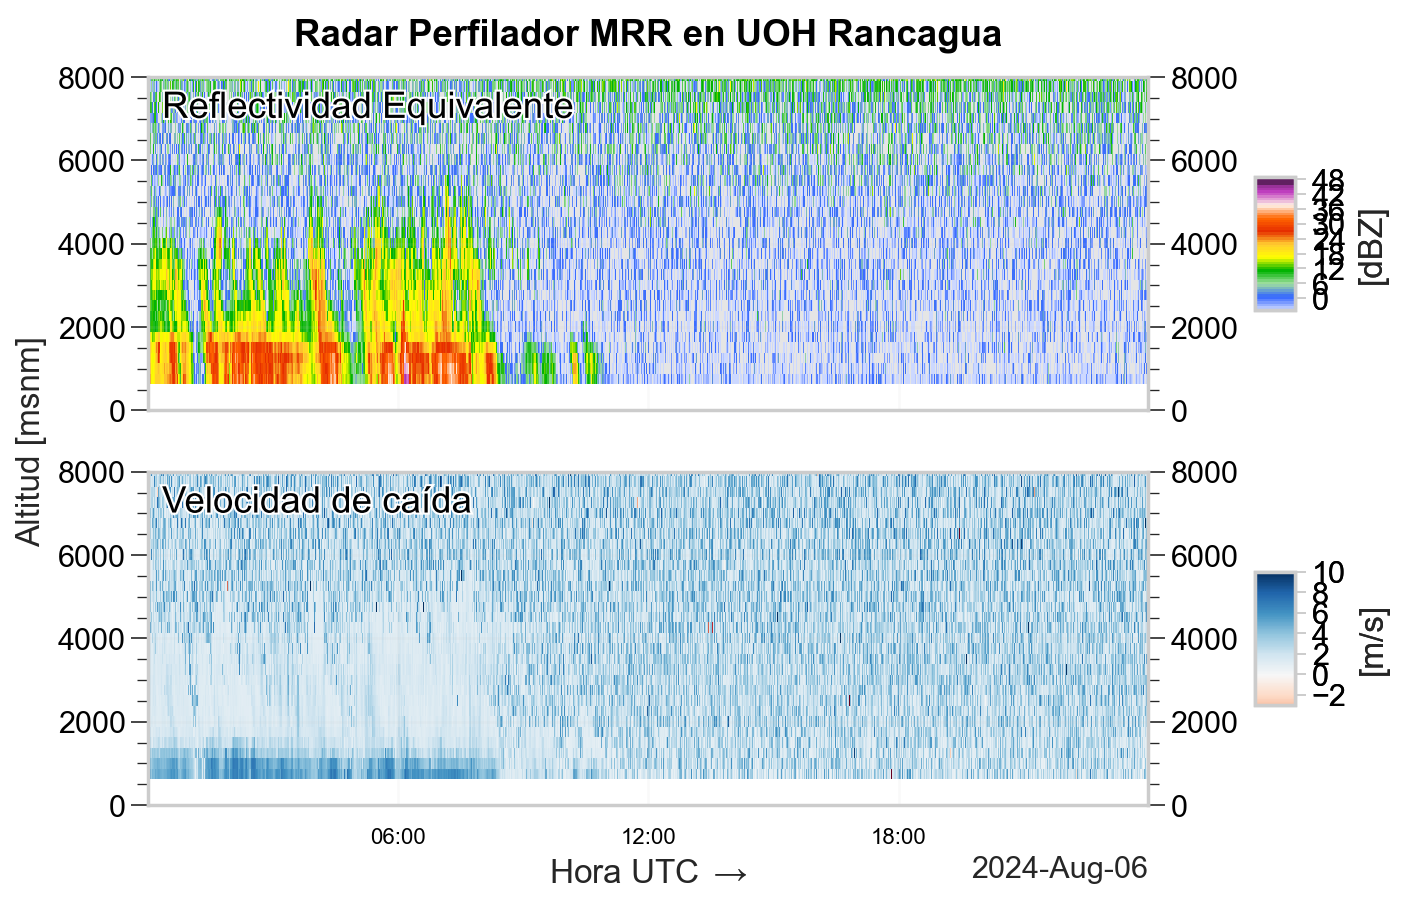

In [54]:
new_time = pd.to_datetime(ds.time.values)
xlim = [new_time[0], new_time[-1]]
heights = ds.height[0,:]+500
Ze = ds['attenuated_radar_reflectivity']
Vf = ds['fall_velocity']
# llamar a la funcion para plotear
plot_mrr2(xlim,pd.to_datetime(ds.time.values) , heights, Ze, Vf, hora_local=False)


## Filtro para ruido

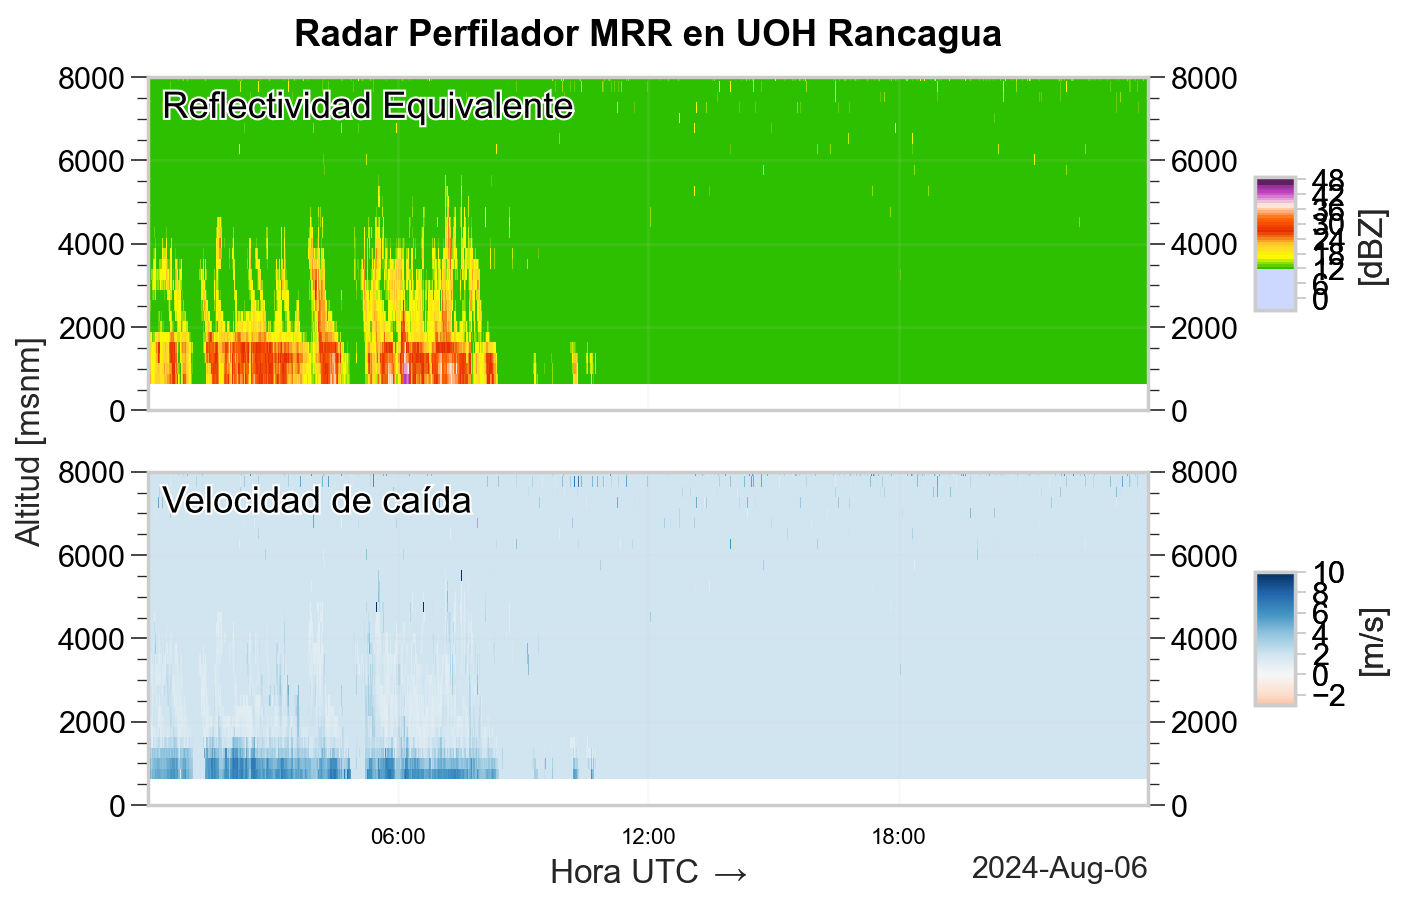

In [55]:
minimo_ref = 12     # Valor minimo a filtrar
minimo_vf = 6
Ze_filtered = Ze.where(Ze >= minimo_ref, minimo_ref)
Vf_filtered = np.where(Ze >= minimo_ref, Vf, 2)

plot_mrr2(xlim,pd.to_datetime(ds.time.values) , heights, Ze_filtered, Vf=Vf_filtered, hora_local=False)

## Funcion gradiente

In [56]:
def plot_mrr3_imshow(xlim, times, heights, Ze, Vf=None, hora_local=False, ax=None,
              ytickloc='both', colorhex = paleta0):
    cmap4 = []
    stops = [0,1./10,2./10,3./10,4./10,5./10,6./10,7./10,8./10,9./10,1]
    for value, color in zip(stops,colorhex):
        cmap4.append((value,color))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom",cmap4)
    dbzmap.set_bad('0.9',1)
    bounds = np.arange(-5,50,1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)

    if hora_local:
        xlabel = r'Hora Local $\rightarrow$'
    else:
        xlabel = r'Hora UTC $\rightarrow$'

    if heights[-1]< 5000:
        ylim = [0, 3600]
    else:
        ylim = [0, 8000]

    total_seconds = (xlim[1]-xlim[0]).total_seconds()

    if total_seconds <= 14400:
        xlocator=('hour',range(0,24,1))
        xminorlocator=('minute',30)
    elif (total_seconds>14400) and (total_seconds<=82800.0):
        xlocator=('hour',range(0,24,3))
        xminorlocator=('hour',range(0,24,1))
    else:
        xlocator=('hour',range(0,24,6))
        xminorlocator=('hour',range(0,24,2))

    extent = [dates.date2num(times[0]), dates.date2num(times[-1]), heights[0], heights[-1]]

    if Vf is None:

        if ax is None:
            fig, ax = pplt.subplots(refwidth=5, refaspect=3)

        mZe = ax.imshow(Ze, origin='lower', aspect='auto',
                        cmap=dbzmap, norm=norm,
                        extent=extent)

        ax.format(ultitle='Reflectividad Equivalente',
                  xrotation=False,
                  xformatter='concise',
                  xlocator=xlocator,
                  xminorlocator=xminorlocator,
                  ylim=ylim,
                  yticklabelloc=ytickloc,
                  ytickloc='both',
                  xticklabelsize=8,
                  suptitle='Gradientes datos MRR UOH',
                  ylabel='Altitud [msnm]',
                  xlabel=xlabel)

        ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7)

        if xlim != '':
            ax.format(xlim=xlim)

    else:
        fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3)

        mZe = ax[0].imshow(Ze, origin='lower', aspect='auto',
                           cmap=dbzmap, norm=norm,
                           extent=extent)
        add_no_data(ax[0], times, xlim)

        mVf = ax[1].imshow(Vf, origin='lower', aspect='auto',
                           vmin=-3, vmax=10,
                           cmap='RdBu',
                           extent=extent)
        add_no_data(ax[1], times, xlim)

        ax[0].format(ultitle='Reflectividad Equivalente',
                     xrotation=False,
                     xformatter='concise',
                     xlocator=xlocator,
                     xminorlocator=xminorlocator,
                     ylim=ylim,
                     yticklabelloc='both',
                     ytickloc='both',
                     xticklabelsize=8,
                     suptitle='Gradientes datos MRR UOH',
                     ylabel='Altitud [msnm]',
                     xlabel=xlabel)

        ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4)

        ax[1].format(ultitle='Velocidad de caída',
                     xrotation=False,
                     xformatter='concise',
                     xlocator=xlocator,
                     xminorlocator=xminorlocator,
                     ylim=ylim,
                     yticklabelloc='both',
                     ytickloc='both',
                     xticklabelsize=8)

        ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4,
                       extend='both')

        if xlim != '':
            ax[0].format(xlim=xlim)
            ax[1].format(xlim=xlim)

    fig.show()


In [57]:
def calcular_gradiente(datos, marco):
    pesos = np.array([marco - i for i in range(marco)])  
    pesos = pesos / np.sum(pesos)                        
    niveles_restantes = datos.shape[0] - 1 - 2 * (marco - 1)
    gradiente_datos = np.zeros((niveles_restantes, datos.shape[1]))

    for i in range(marco, datos.shape[0] - marco):
        superior = np.sum([pesos[j] * datos[i + j, :] for j in range(marco)], axis=0)
        inferior = np.sum([pesos[j] * datos[i - j - 1, :] for j in range(marco)], axis=0)
        gradiente_datos[i - marco, :] = superior - inferior

    filas_superior = marco
    filas_inferior = marco - 1

    gradiente_datos_completo = np.pad(gradiente_datos, ((filas_superior, filas_inferior), (0, 0)), mode='constant', constant_values=0)

    return gradiente_datos_completo

#mismo del jonathan

C:\Users\conyl\AppData\Local\Temp\ipykernel_14008\173114761.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


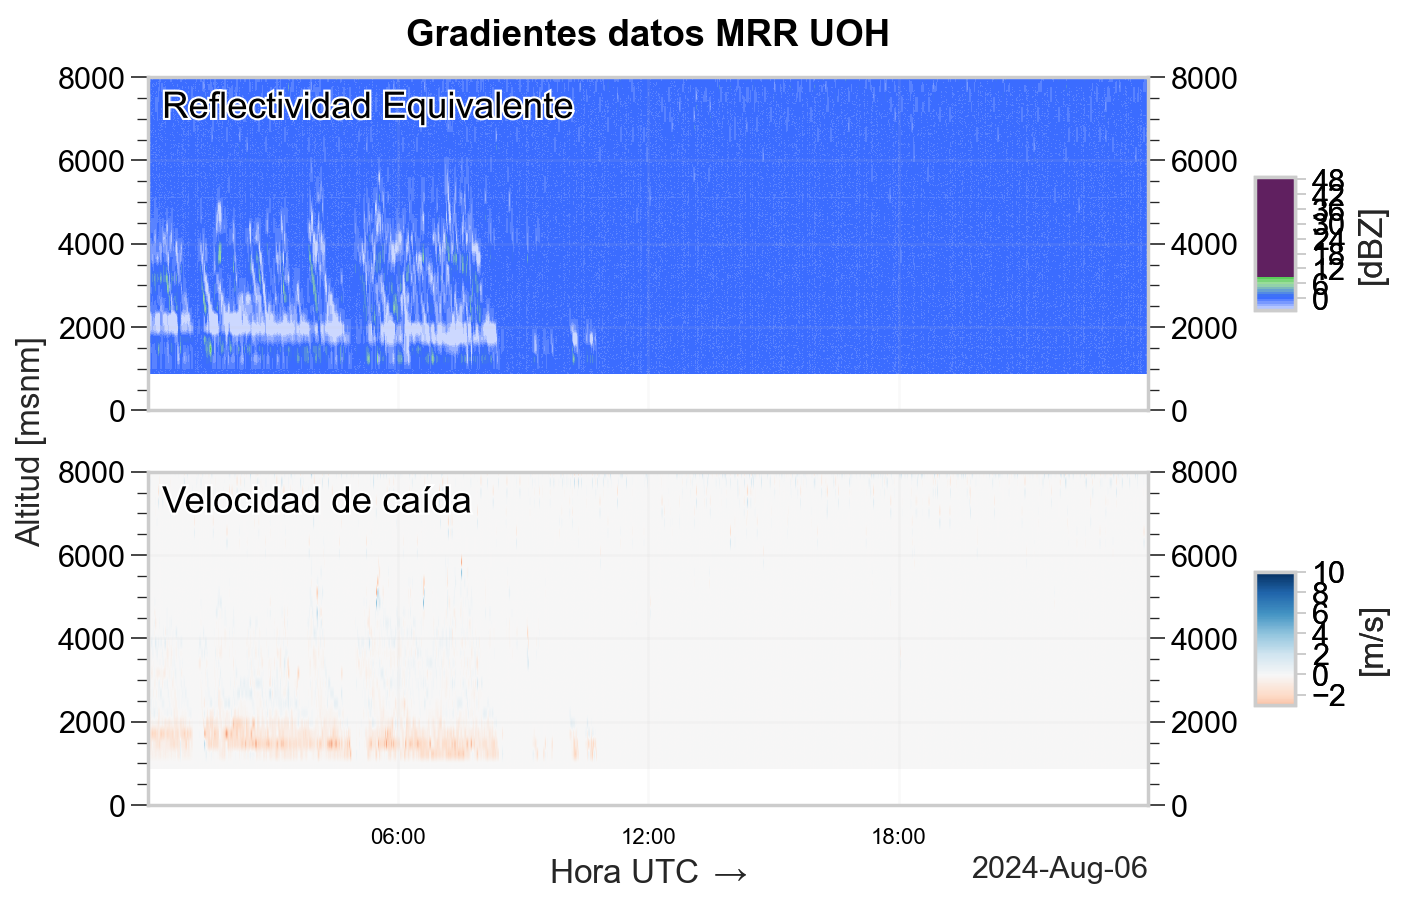

In [58]:
altura_inicial_desfase = 500 + (heights[1] - heights[0]) / 2   # Ajuste altura

heights_ajustado = ds.height[0, :] + altura_inicial_desfase

marco = 1
gradiente_Ze = calcular_gradiente(Ze_filtered.T, marco) #el problema, una vez más era la traspuesta
gradiente_Vf = calcular_gradiente(Vf_filtered.T, marco)
plot_mrr3_imshow(xlim, new_time, heights_ajustado, gradiente_Ze, Vf=gradiente_Vf, hora_local=False)

# Funcion detectar isoterma

In [61]:
def plot_mrr3_imshow_con_isoterma(xlim, times, heights, Ze, isoterma_results_Ze, Vf=None, isoterma_results_Vf=None, hora_local=False, ax=None,
                                  ytickloc='both', colorhex=paleta0):
    cmap4 = []
    stops = [0,1./10,2./10,3./10,4./10,5./10,6./10,7./10,8./10,9./10,1]
    for value, color in zip(stops,colorhex):
        cmap4.append((value,color))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom",cmap4)
    dbzmap.set_bad('0.9',1)
    bounds = np.arange(-5,50,1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)

    if hora_local:
        xlabel = r'Hora Local $\rightarrow$'
    else:
        xlabel = r'Hora UTC $\rightarrow$'

    if heights[-1]< 5000:
        ylim = [0, 3600]
    else:
        ylim = [0, 8000]

    total_seconds = (xlim[1]-xlim[0]).total_seconds()

    if total_seconds <= 14400:
        xlocator=('hour',range(0,24,1))
        xminorlocator=('minute',30)
    elif (total_seconds>14400) and (total_seconds<=82800.0):
        xlocator=('hour',range(0,24,3))
        xminorlocator=('hour',range(0,24,1))
    else:
        xlocator=('hour',range(0,24,6))
        xminorlocator=('hour',range(0,24,2))

    extent = [dates.date2num(times[0]), dates.date2num(times[-1]), heights[0], heights[-1]]

    # Extraer tiempos y alturas de la isoterma
    isoterma_times = times
    isoterma_heights_Ze = [r['altura_minima'] for r in isoterma_results_Ze]

    if Vf is None:
        if ax is None:
            fig, ax = pplt.subplots(refwidth=5, refaspect=3)

        mZe = ax.imshow(Ze, origin='lower', aspect='auto',
                        cmap=dbzmap, norm=norm,
                        extent=extent)
        
        # Graficar la isoterma como una línea
        ax.plot(isoterma_times, isoterma_heights_Ze, color='red', linewidth=1.5, 
                label='Isoterma 0°C detectada')

        ax.format(ultitle='Reflectividad Equivalente',
                  xrotation=False,
                  xformatter='concise',
                  xlocator=xlocator,
                  xminorlocator=xminorlocator,
                  ylim=ylim,
                  yticklabelloc=ytickloc,
                  ytickloc='both',
                  xticklabelsize=8,
                  suptitle='Isoterma detectada por el método del gradiente',
                  ylabel='Altitud [msnm]',
                  xlabel=xlabel)

        ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7)
        ax.legend(loc='upper right')  # Añadir leyenda

        if xlim != '':
            ax.format(xlim=xlim)

    else:
        isoterma_heights_Vf = [r['altura_minima'] for r in isoterma_results_Vf]
        fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3)

        mZe = ax[0].imshow(Ze, origin='lower', aspect='auto',
                           cmap=dbzmap, norm=norm,
                           extent=extent)
        add_no_data(ax[0], times, xlim)
        
        # Graficar la isoterma en el primer subplot (Reflectividad)
        ax[0].plot(isoterma_times, isoterma_heights_Ze, color='red', linewidth=1.5, 
                  label='Isoterma 0°C detectada')

        mVf = ax[1].imshow(Vf, origin='lower', aspect='auto',
                           vmin=-3, vmax=10,
                           cmap='RdBu',
                           extent=extent)
        add_no_data(ax[1], times, xlim)
    
        # Graficar la isoterma en el primer subplot (Velocidad caida)
        ax[1].plot(isoterma_times, isoterma_heights_Vf, color='red', linewidth=1.5, 
                  label='Isoterma 0°C detectada')

        ax[0].format(ultitle='Reflectividad Equivalente',
                     xrotation=False,
                     xformatter='concise',
                     xlocator=xlocator,
                     xminorlocator=xminorlocator,
                     ylim=ylim,
                     yticklabelloc='both',
                     ytickloc='both',
                     xticklabelsize=8,
                     suptitle='Isoterma detectada por el método del gradiente',
                     ylabel='Altitud [msnm]',
                     xlabel=xlabel)

        ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4)
        ax[0].legend(loc='upper right')  # Añadir leyenda

        ax[1].format(ultitle='Velocidad de caída',
                     xrotation=False,
                     xformatter='concise',
                     xlocator=xlocator,
                     xminorlocator=xminorlocator,
                     ylim=ylim,
                     yticklabelloc='both',
                     ytickloc='both',
                     xticklabelsize=8)

        ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4,
                       extend='both')

        if xlim != '':
            ax[0].format(xlim=xlim)
            ax[1].format(xlim=xlim)

    fig.show()

In [59]:
def detectar_isoterma_cero(gradiente, altura_inicial):
    resultados = []
    altura_actual = altura_inicial

    for t in range(gradiente.shape[1]):                      
        idx_altura = int((np.abs(heights_ajustado - altura_actual)).argmin()) # Ajuste altura ingresada con valor correspondiente
        gradiente_minimo = gradiente[idx_altura, t]
        altura_minima = heights_ajustado[idx_altura].values  
        idx_superior = max(idx_altura - 1, 0)
        idx_inferior = min(idx_altura + 1, len(heights_ajustado) - 1)

        for i in range(idx_superior, idx_inferior + 1):     
            if gradiente[i, t] < gradiente_minimo:
                gradiente_minimo = gradiente[i, t]
                altura_minima = heights_ajustado[i].values 

        ponderado = 0.5 
        altura_actual = (1-ponderado)*altura_actual + ponderado*altura_minima 
                 
        resultados.append({
            "iter": t,
            "altura_minima": altura_actual,
            "gradiente_minimo": gradiente_minimo
        })

    return resultados

## FUNCIONES PONDERADO GRADIENTES

In [96]:
def detectar_isoterma_cero_ponderado(gradiente, altura_inicial):
    resultados = []
    altura_actual = altura_inicial
    gradiente = gradiente + (np.abs(gradiente.min()) + 1)  #se amplifican todos los valores al (minimo + 1) para evitar problemas con casos <0
    gradientes_ponderados = []
    ponderador_distancia = 1

    for t in range(gradiente.shape[1]):    
        #Factor ponderado
        distancias = np.abs(heights_ajustado - altura_actual) #aun no se actualiza la altura actual, así que es la del paso anterior. Como es solo 1D, es esa norma
        distancias_normalizadas = distancias / np.max(distancias)
        gradiente_t = gradiente[:,t] #gradiente de todas las alturas en tiempo t. 
        gradientes_pond = gradiente_t * (distancias_normalizadas*ponderador_distancia)
        #Encontrar minimo
        idx_altura = int((np.abs(heights_ajustado - altura_actual)).argmin()) # Ajuste altura ingresada con valor correspondiente
        gradiente_minimo = gradientes_pond[idx_altura]
        altura_minima = heights_ajustado[idx_altura].values  
        idx_superior = max(idx_altura - 1, 0)
        idx_inferior = min(idx_altura + 1, len(heights_ajustado) - 1)

        for i in range(idx_superior, idx_inferior + 1):     
            if gradientes_pond[i] < gradiente_minimo:
                gradiente_minimo = gradientes_pond[i]
                altura_minima = heights_ajustado[i].values 
         
        altura_actual = altura_minima 
                 
        resultados.append({
            "iter": t,
            "altura_minima": altura_actual,
            "gradiente_minimo": gradiente_minimo
        })
        gradientes_ponderados.append(gradientes_pond)

    return resultados, np.array(gradientes_ponderados)

In [99]:
def detectar_isoterma_cero_ponderado1(gradiente, altura_inicial):
    resultados = []
    altura_actual = altura_inicial
    #gradiente = gradiente + (np.abs(gradiente.min()) + 1)  #se amplifican todos los valores al (minimo + 1) para evitar problemas con casos <0
    gradientes_ponderados = []
    ponderador_distancia = 1
    epsilon = 1e-3

    for t in range(gradiente.shape[1]):    
        #Factor ponderado
        distancias = np.abs(heights_ajustado - altura_actual) #aun no se actualiza la altura actual, así que es la del paso anterior. Como es solo 1D, es esa norma
        distancias_normalizadas = distancias / (np.max(distancias) + epsilon)
        gradiente_t = gradiente[:,t] #gradiente de todas las alturas en tiempo t. 
        gradientes_pond = gradiente_t / (distancias_normalizadas + epsilon)
        #Encontrar minimo
        idx_altura = int((np.abs(heights_ajustado - altura_actual)).argmax()) # Ajuste altura ingresada con valor correspondiente
        gradiente_minimo = gradientes_pond[idx_altura]
        altura_minima = heights_ajustado[idx_altura].values  
        idx_superior = max(idx_altura - 1, 0)
        idx_inferior = min(idx_altura + 1, len(heights_ajustado) - 1)

        for i in range(idx_superior, idx_inferior + 1):     
            if gradientes_pond[i] > gradiente_minimo:
                gradiente_minimo = gradientes_pond[i]
                altura_minima = heights_ajustado[i].values 
         
        altura_actual = altura_minima 
                 
        resultados.append({
            "iter": t,
            "altura_minima": altura_actual,
            "gradiente_minimo": gradiente_minimo
        })
        gradientes_ponderados.append(gradientes_pond)

    return resultados, np.array(gradientes_ponderados)

C:\Users\conyl\AppData\Local\Temp\ipykernel_14008\4273697507.py:127: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


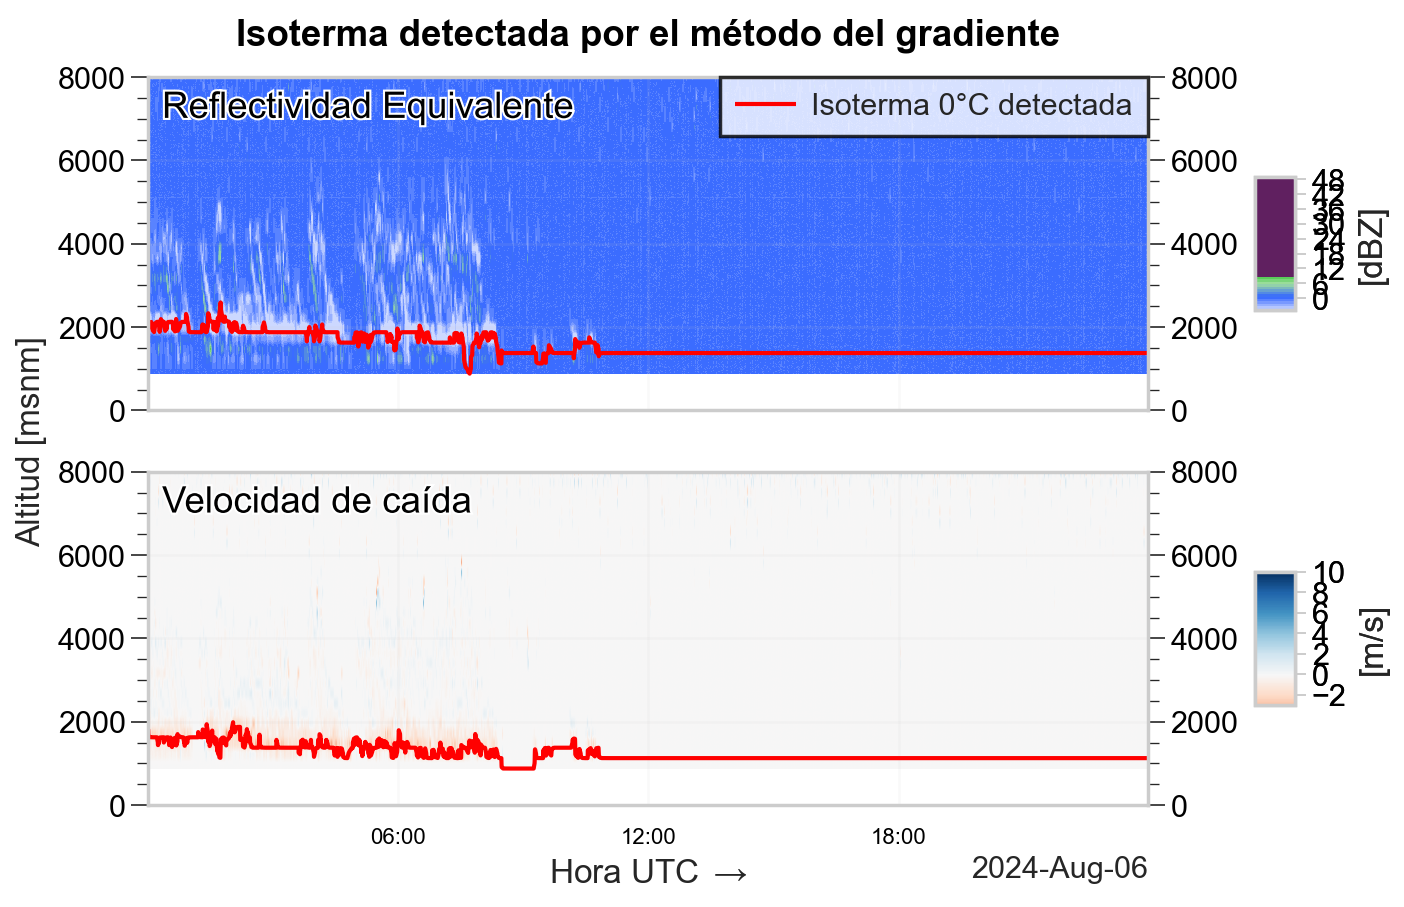

In [62]:
resultados_isoterma_Ze = detectar_isoterma_cero(gradiente_Ze, altura_inicial=2000)
resultados_isoterma_Vf = detectar_isoterma_cero(gradiente_Vf, altura_inicial=2000)

# Graficar con la isoterma
plot_mrr3_imshow_con_isoterma(xlim, new_time, heights_ajustado, gradiente_Ze, resultados_isoterma_Ze, Vf=gradiente_Vf, isoterma_results_Vf=resultados_isoterma_Vf)

## PRUEBA PONDERADO GRADIENTES

C:\Users\conyl\AppData\Local\Temp\ipykernel_14008\173114761.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


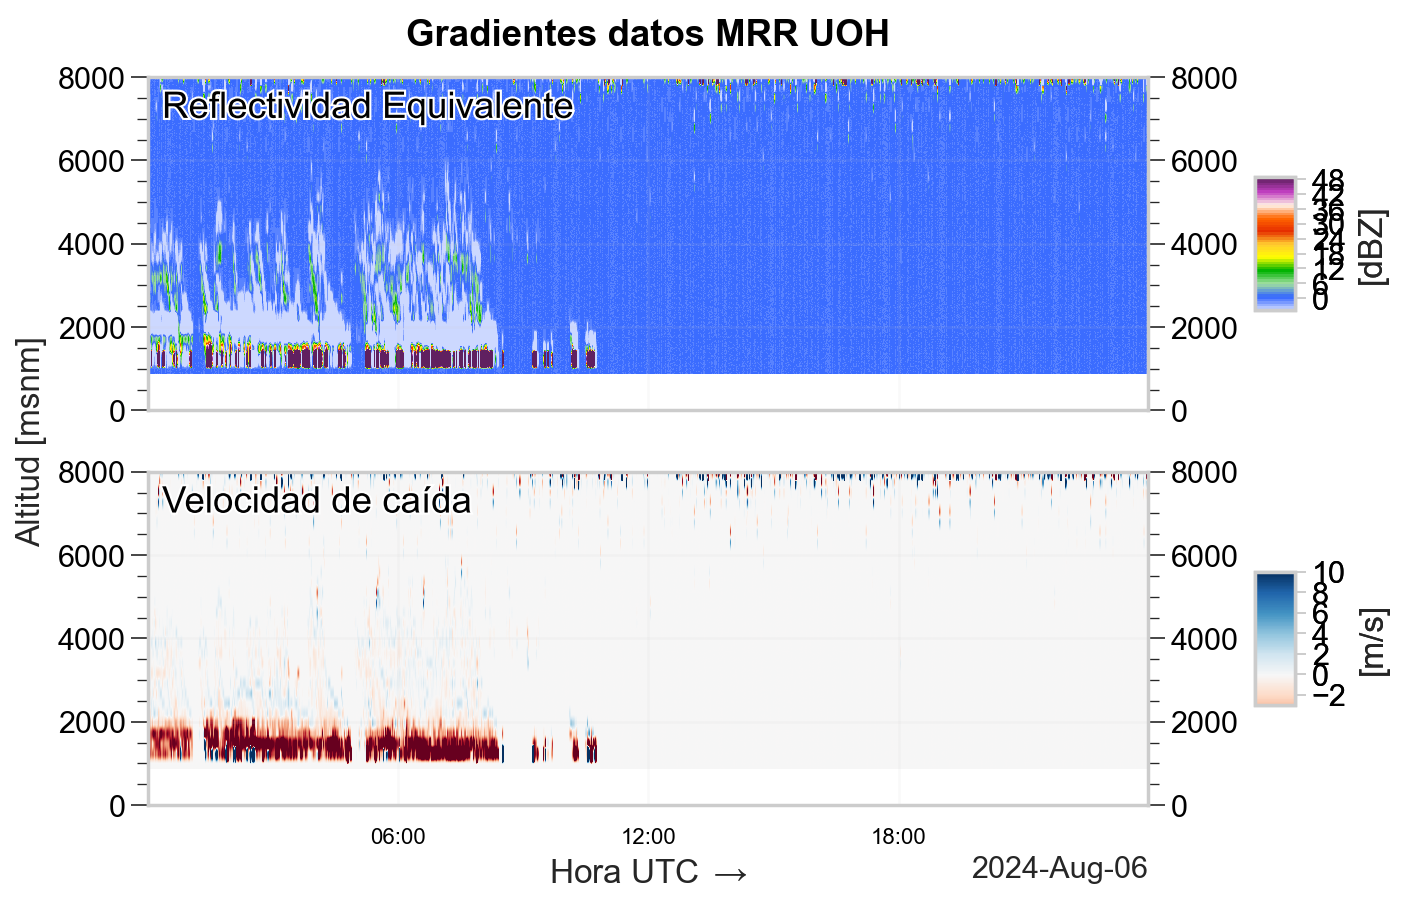

In [100]:
resultados_isoterma_Ze_pond, gradiente_pond_Ze = detectar_isoterma_cero_ponderado1(gradiente_Ze, altura_inicial=2000)
resultados_isoterma_Vf_pond, gradiente_pond_Vf = detectar_isoterma_cero_ponderado1(gradiente_Vf, altura_inicial=2000)

plot_mrr3_imshow(xlim, new_time, heights_ajustado, gradiente_pond_Ze.T, Vf=gradiente_pond_Vf.T, hora_local=False)
# Graficar con la isoterma
#plot_mrr3_imshow_con_isoterma(xlim, new_time, heights_ajustado, gradiente_pond_Ze, resultados_isoterma_Ze, Vf=gradiente_pond_Vf, isoterma_results_Vf=resultados_isoterma_Vf)

C:\Users\conyl\AppData\Local\Temp\ipykernel_14008\4273697507.py:127: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


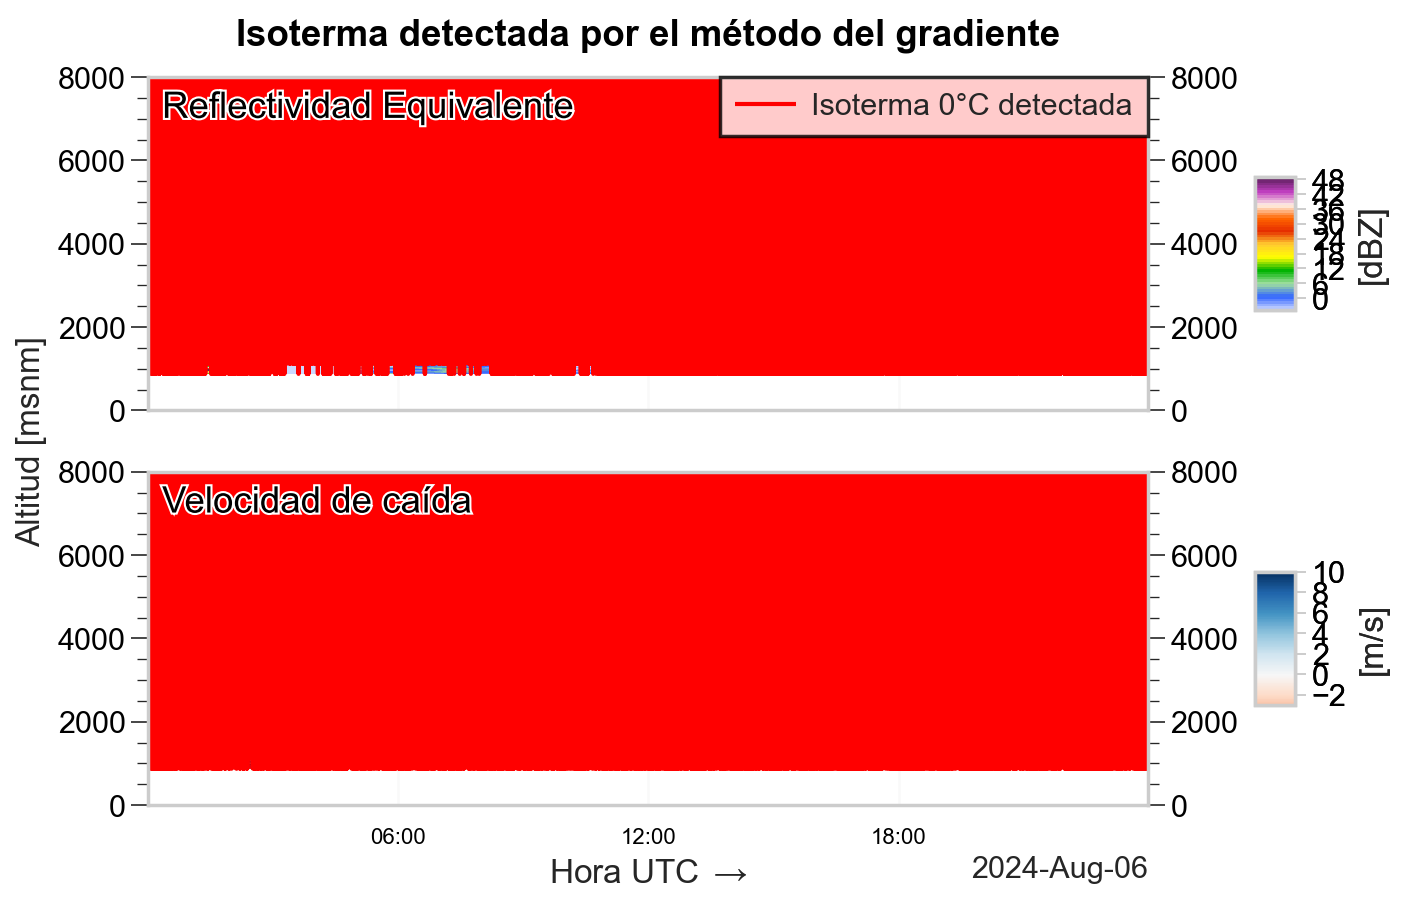

In [101]:
plot_mrr3_imshow_con_isoterma(xlim, new_time, heights_ajustado, gradiente_pond_Ze, resultados_isoterma_Ze_pond, Vf=gradiente_pond_Vf, isoterma_results_Vf=resultados_isoterma_Vf_pond)

C:\Users\conyl\AppData\Local\Temp\ipykernel_14008\4273697507.py:127: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


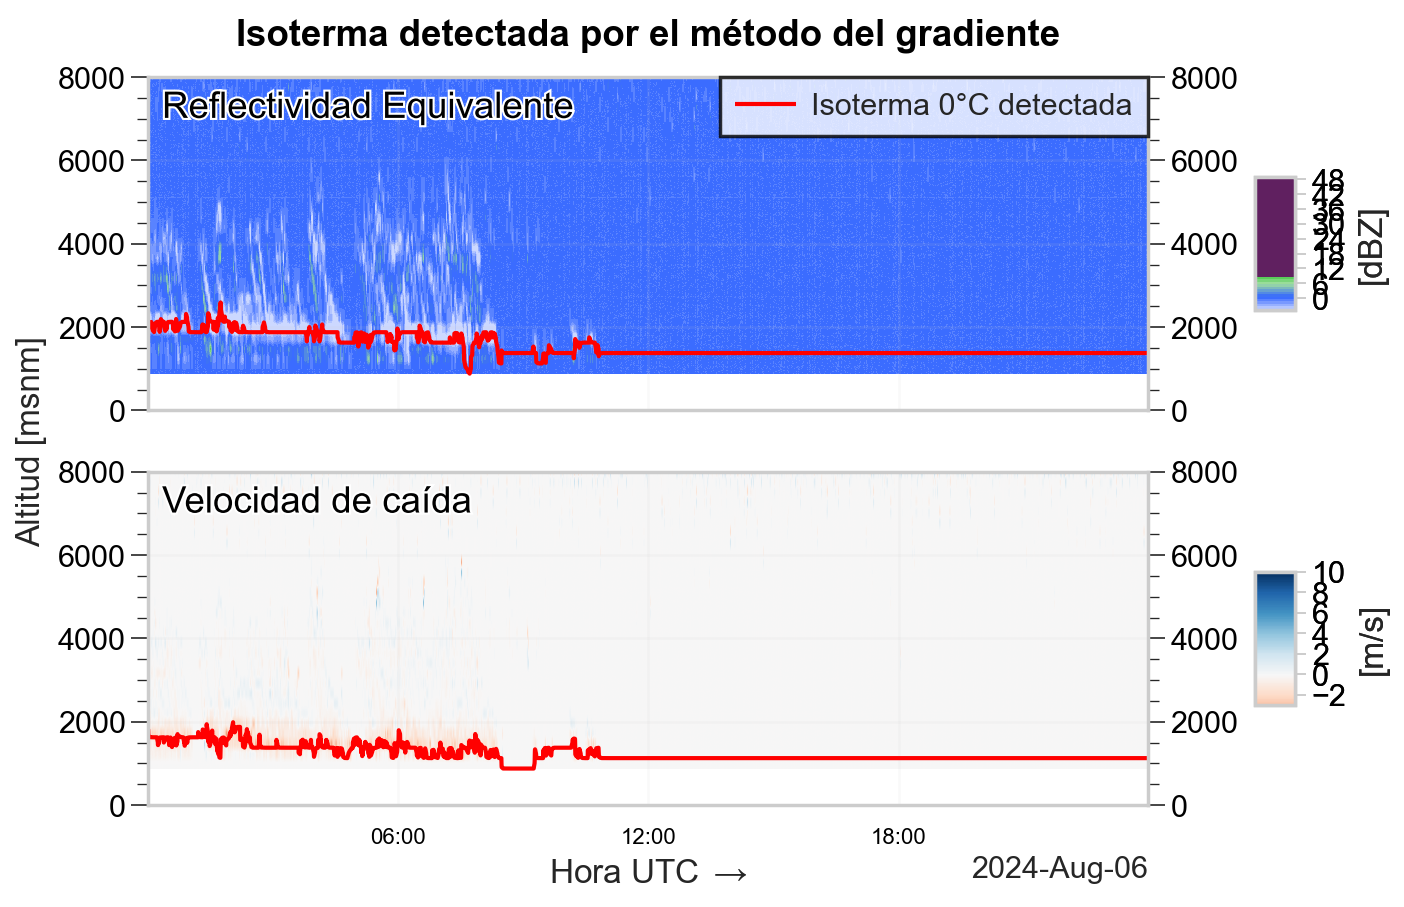

In [65]:
resultados_isoterma_Ze = detectar_isoterma_cero(gradiente_Ze, altura_inicial=2000)
resultados_isoterma_Vf = detectar_isoterma_cero(gradiente_Vf, altura_inicial=2000)

# Graficar con la isoterma
plot_mrr3_imshow_con_isoterma(xlim, new_time, heights_ajustado, gradiente_Ze, resultados_isoterma_Ze, Vf=gradiente_Vf, isoterma_results_Vf=resultados_isoterma_Vf)

## Filtro Kalman: Reflectividad

In [66]:
IndicesIsoterma=[]
for resultado in resultados_isoterma_Ze:
    t = resultado["iter"]
    altura_minima = resultado["altura_minima"]
    idx_altura = int((np.abs(heights_ajustado - altura_minima)).argmin())
    IndicesIsoterma.append(idx_altura)

FactorConversion = (heights[-1].values-500)/ len(heights)
AlturasIsoterma = np.array(IndicesIsoterma) * FactorConversion

In [67]:
def filtro_kalman(alturas, delta_t, Q_ruido_proceso_reflectividad, Q_ruido_proceso_gradiente, R_ruido_medicion, factor_ponderador):
    f = KalmanFilter(dim_x=2, dim_z=1)
    f.x = np.array([alturas[0], 0.])  #[posición, velocidad]
    f.F = np.array([[1., delta_t],
                    [0., 1.]]) #Matriz de trnasición
    f.H = np.array([[1., 0.]]) #Matriz observación
    f.P = np.array([[500.0, 0.0],
                    [0.0,   100.0]])
    f.Q = np.array([[Q_ruido_proceso_reflectividad, 0], [0, Q_ruido_proceso_gradiente]])  # Ruido del proceso
    f.R = R_ruido_medicion

    alturas_filtradas = [f.x[0]]
    ganancias_kalman = [f.K.copy()]
    var_altura = [f.P[0, 0]]
    var_velocidad = [f.P[1, 1]]
    covar = [f.P[0, 1]]
    tasa_cambio = [f.x[1]] #revisar vector x componente 1 para ver si esta la tasa de cambio igual a 0
    


    for z in alturas[1:]:
        f.predict()
        f.update(z)
        alturas_filtradas.append(f.x[0])
        ganancias_kalman.append(f.K.copy())
        var_altura.append(f.P[0, 0])
        var_velocidad.append(f.P[1, 1])
        covar.append(f.P[0, 1])
        tasa_cambio.append(f.x[1])
    
    return np.array(alturas_filtradas), np.array(ganancias_kalman), np.array(var_altura), np.array(var_velocidad), np.array(covar), np.array(tasa_cambio)

In [68]:
altura_inicial_desfase = 500 + (heights[1].values - heights[0].values) / 2
AlturasIsoterma_ajustadas = AlturasIsoterma + altura_inicial_desfase
delta_t = 20
Q_ruido_proceso_reflectividad = 10   # Ruido del proceso para reflectividad, aumentar
Q_ruido_proceso_gradiente = 0.05       # Ruido del proceso para gradiente
R_ruido_medicion = 5000                # Ruido de medición - Error de +- 70.71 m (sd raiz de 5000)
factor_ponderador = 0.65               # No se está usando

alturas_filtradas, ganancias, var_altura, var_velocidad, covar, tasa_cambio = filtro_kalman(AlturasIsoterma_ajustadas, 
                                   delta_t, 
                                   Q_ruido_proceso_reflectividad, 
                                   Q_ruido_proceso_gradiente, 
                                   R_ruido_medicion, 
                                   factor_ponderador)


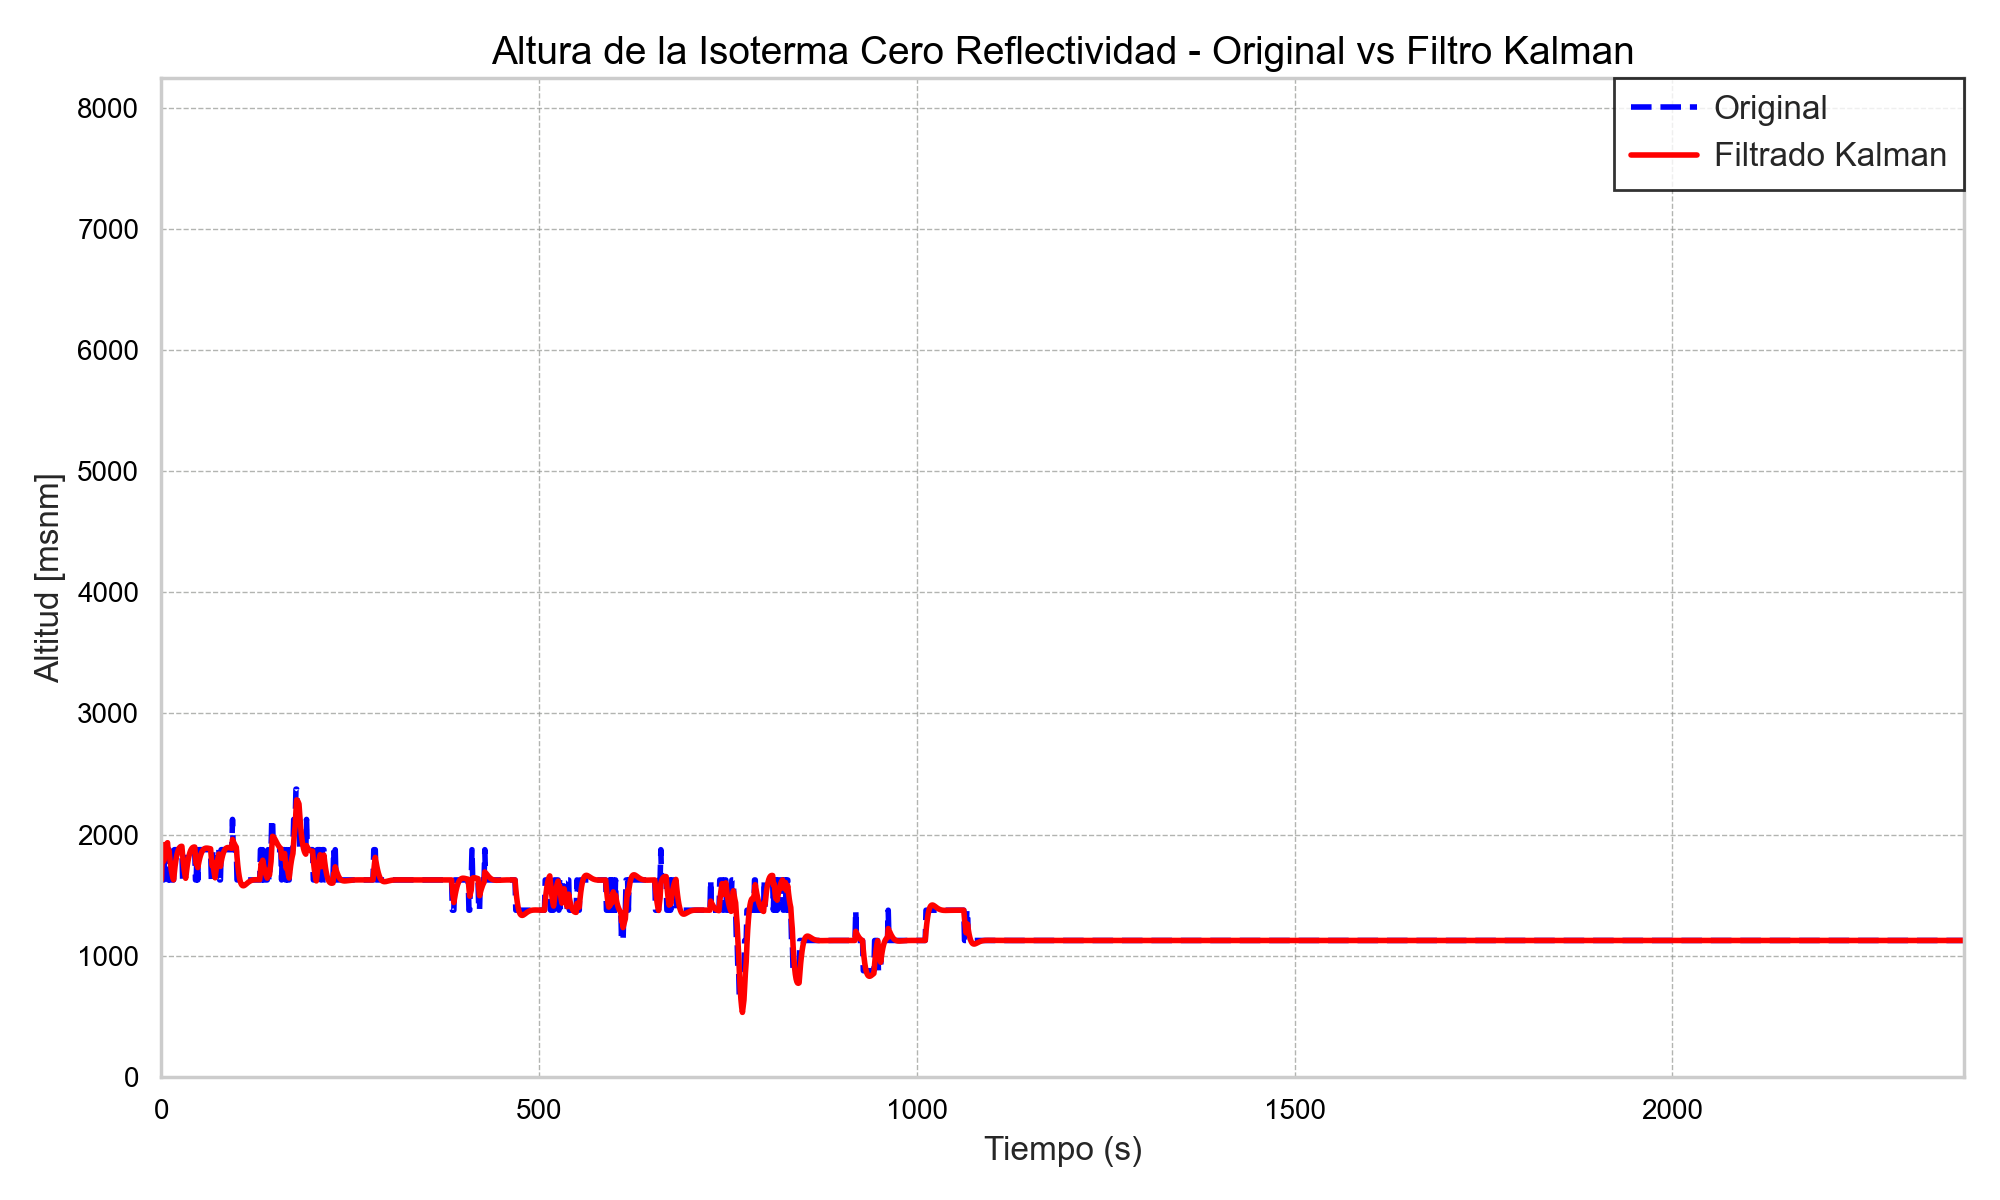

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))  
ax.plot(AlturasIsoterma_ajustadas, label="Original", linestyle='--', color='blue', linewidth=2)
ax.plot(alturas_filtradas, label="Filtrado Kalman", linestyle='-', color='red', linewidth=2)
ax.set_xlabel('Tiempo (s)', fontsize=12) 
ax.set_ylabel('Altitud [msnm]', fontsize=12)
ax.set_title('Altura de la Isoterma Cero Reflectividad - Original vs Filtro Kalman', fontsize=14)
ax.set_xlim([0, len(AlturasIsoterma)])  
ax.set_ylim([0, heights[-1]])    
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper right', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()  
plt.show()

Revisiones H2

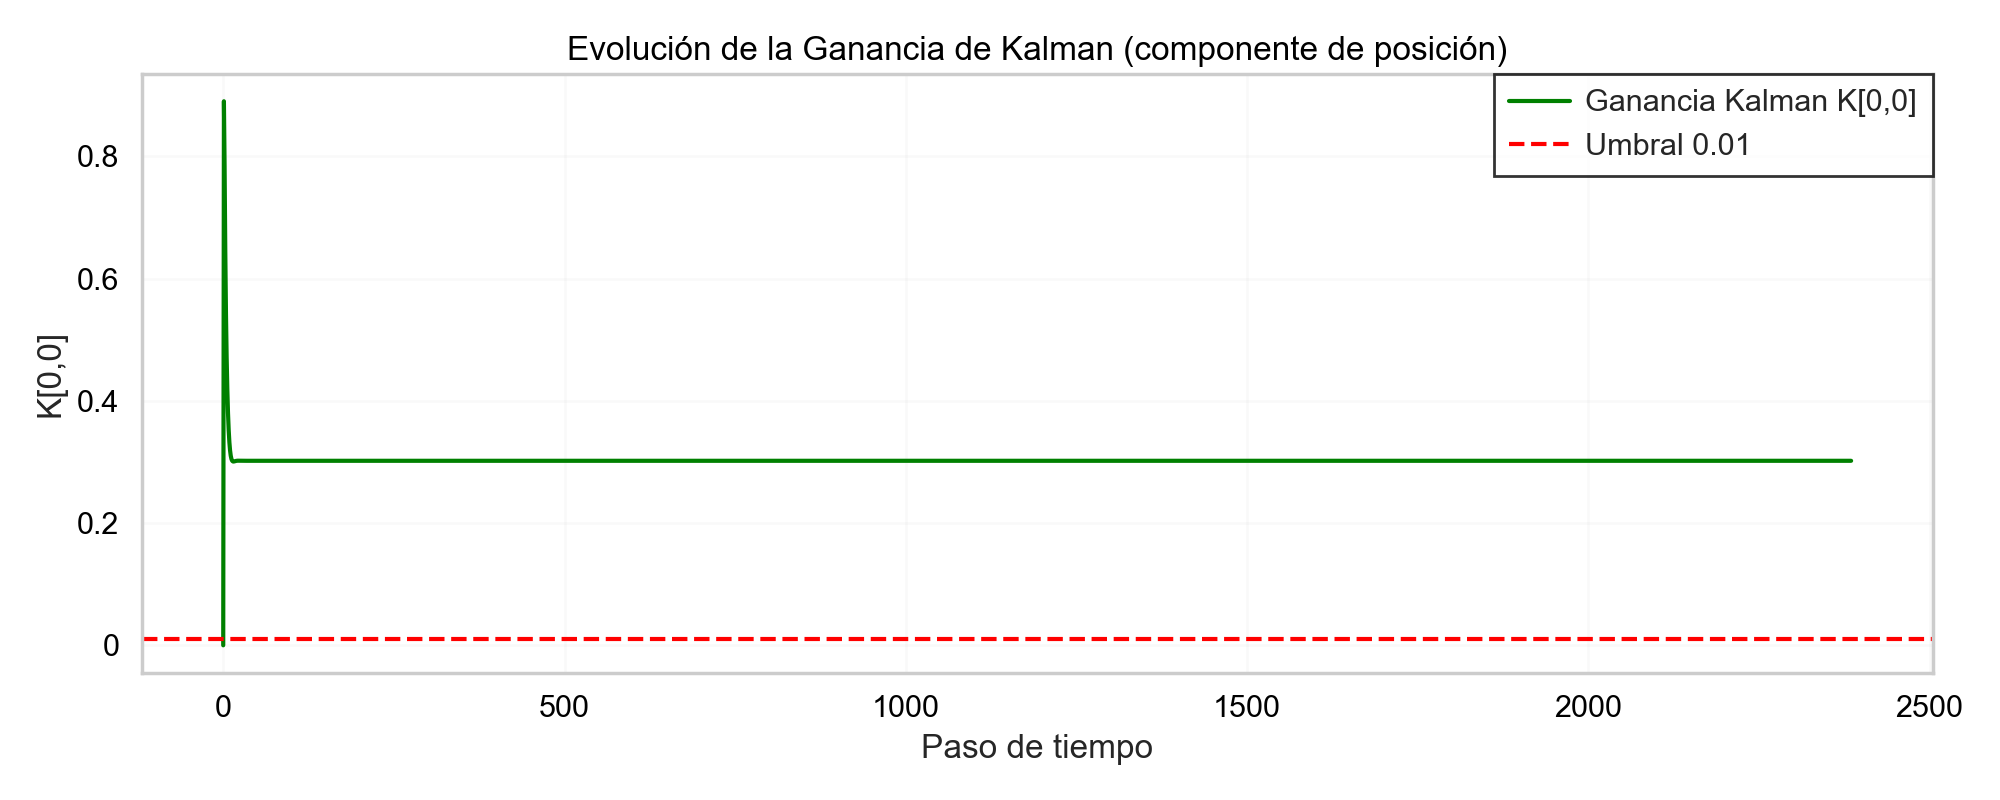

In [70]:
# Extraemos el componente de posición de la ganancia K
K_pos = [K[0][0] for K in ganancias]

plt.figure(figsize=(10, 4))
plt.plot(K_pos, color='green', label='Ganancia Kalman K[0,0]')
plt.axhline(y=0.01, color='red', linestyle='--', label='Umbral 0.01')
plt.title('Evolución de la Ganancia de Kalman (componente de posición)')
plt.xlabel('Paso de tiempo')
plt.ylabel('K[0,0]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


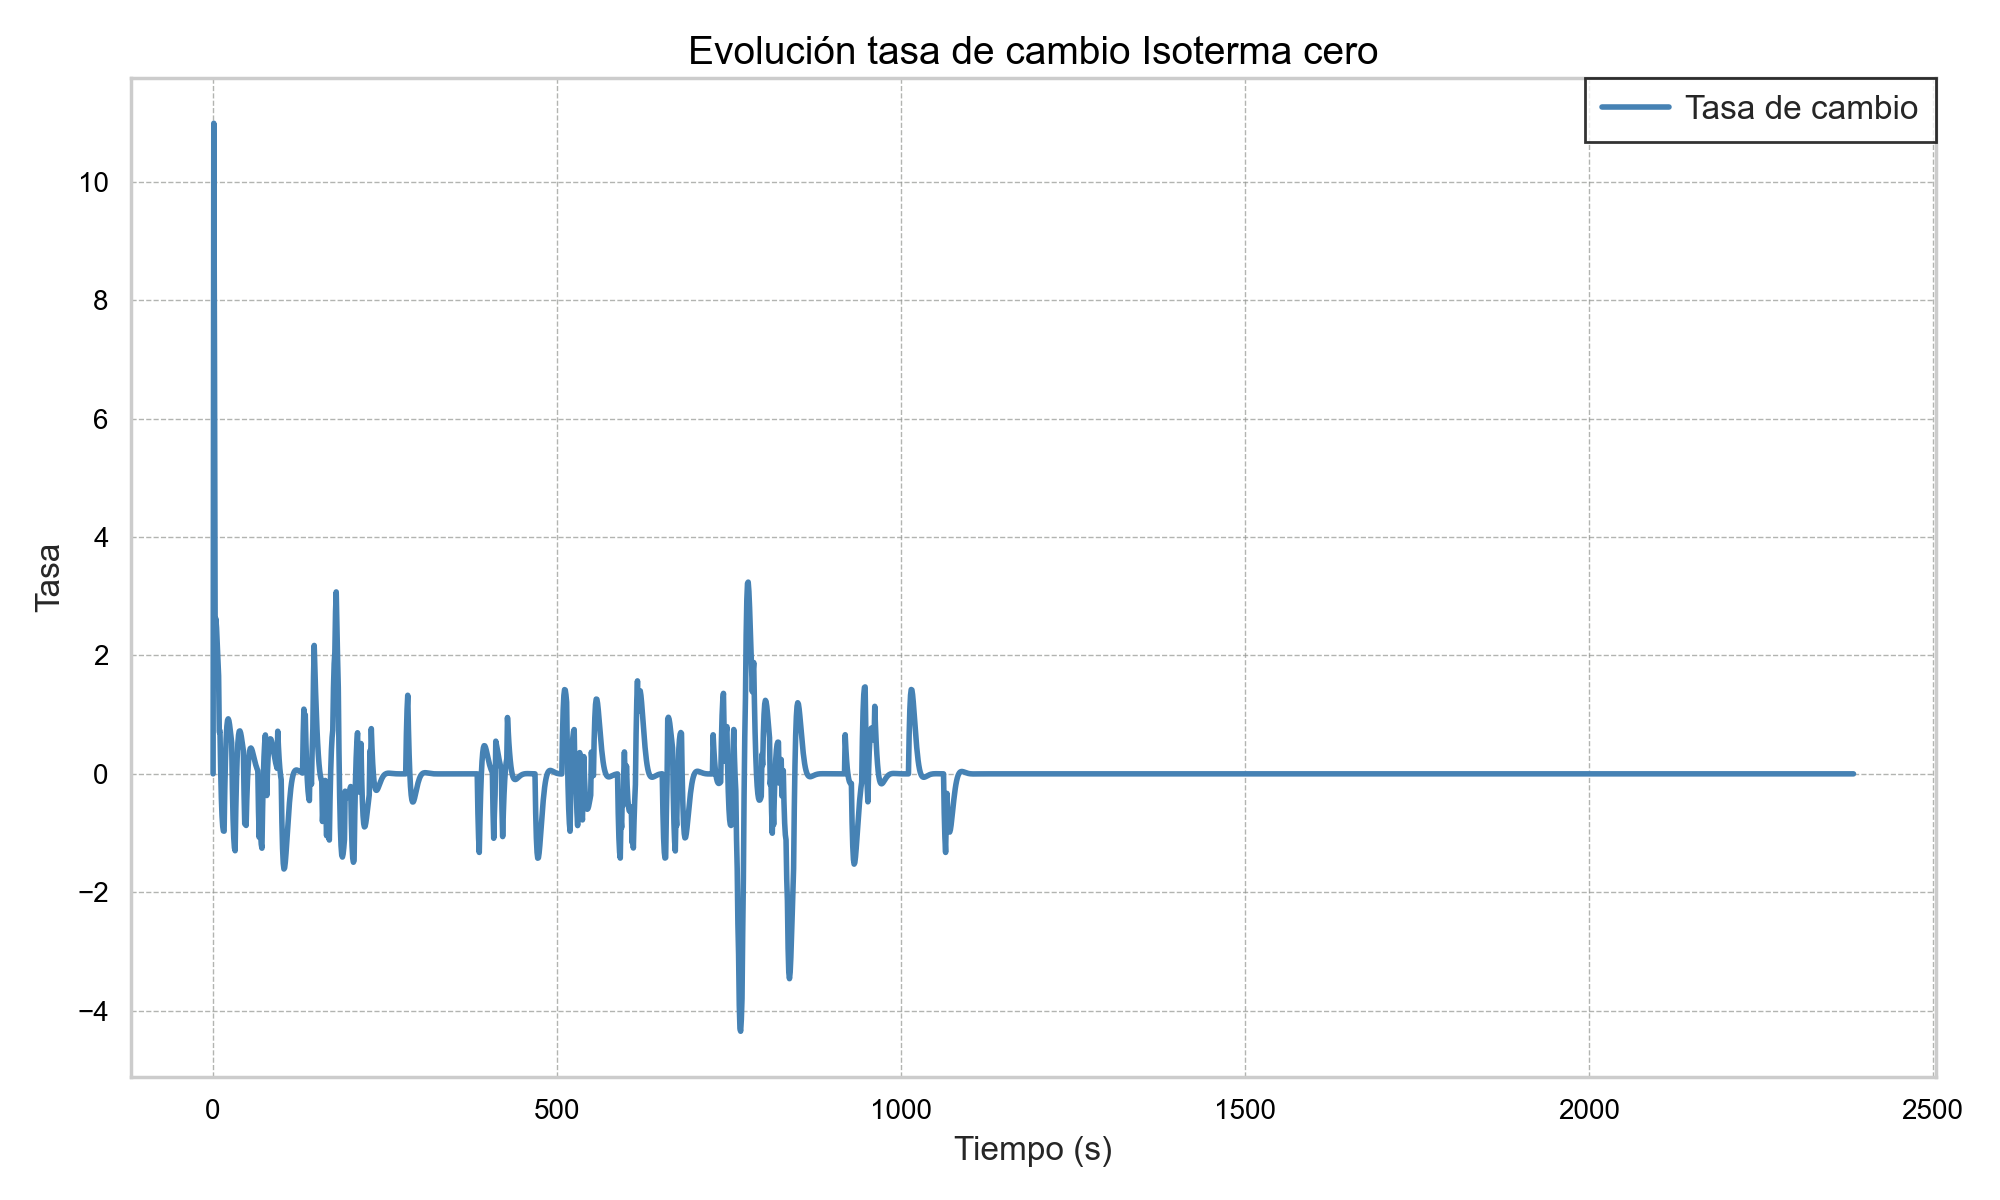

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))  
ax.plot(tasa_cambio, label="Tasa de cambio", color='steelblue', linewidth=2)
ax.set_xlabel('Tiempo (s)', fontsize=12) 
ax.set_ylabel('Tasa', fontsize=12)
ax.set_title('Evolución tasa de cambio Isoterma cero', fontsize=14) 
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper right', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()  
plt.show()

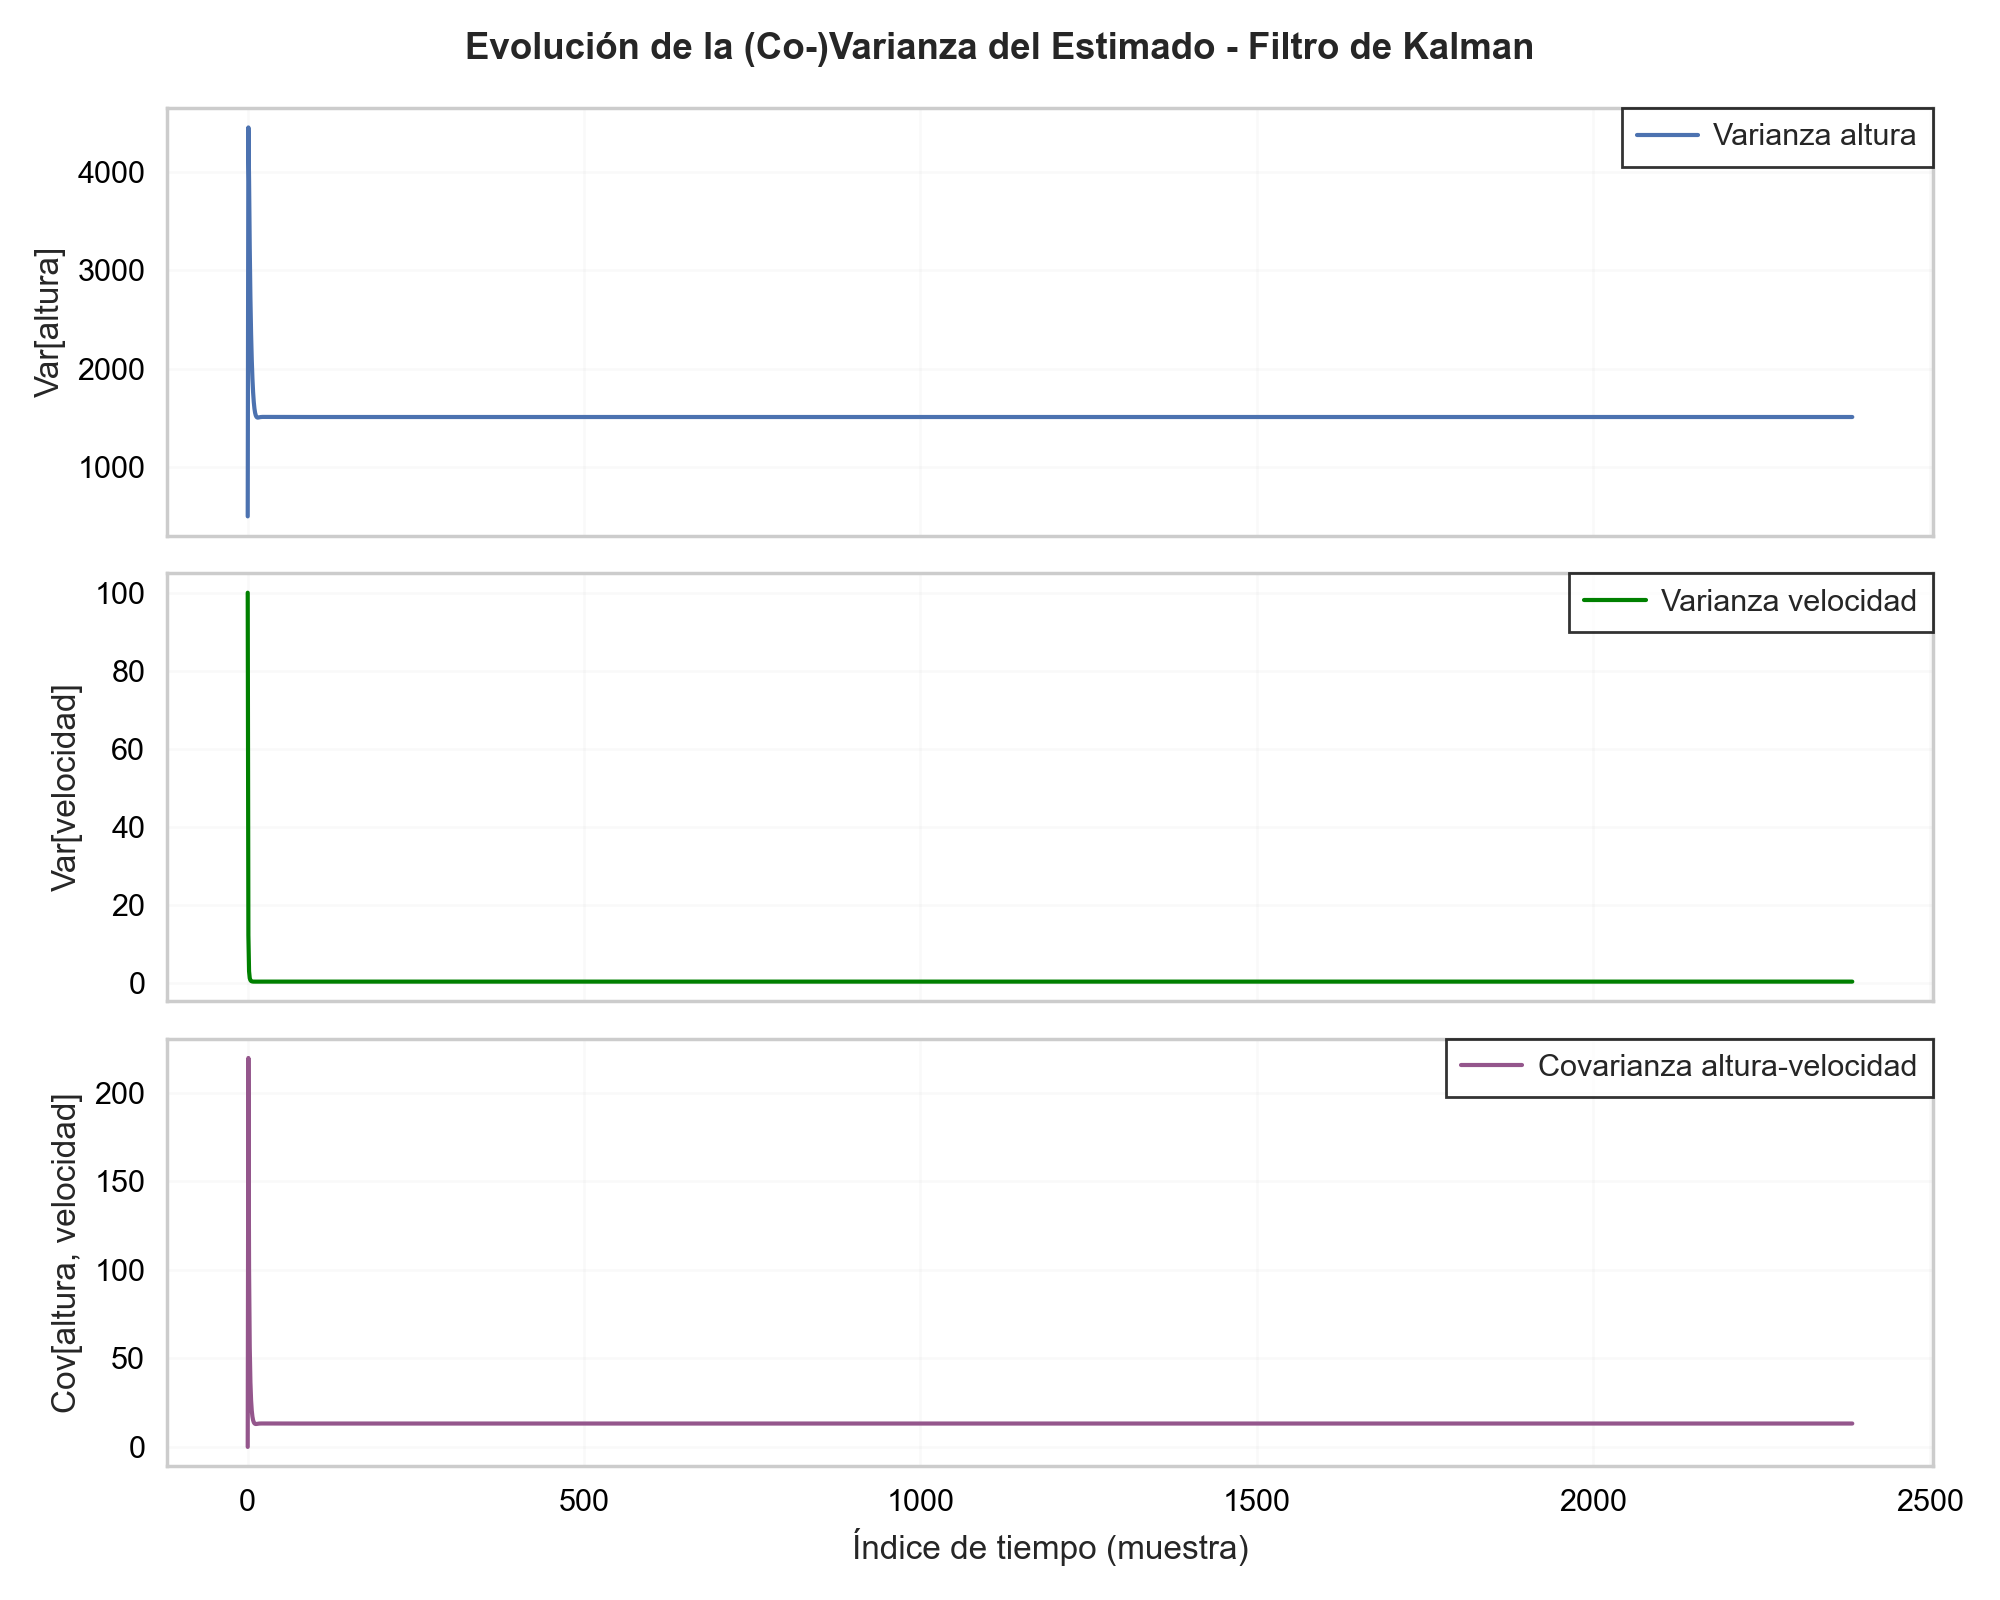

In [72]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax[0].plot(var_altura, label="Varianza altura")
ax[0].set_ylabel("Var[altura]")
ax[0].legend()

ax[1].plot(var_velocidad, label="Varianza velocidad", color='green')
ax[1].set_ylabel("Var[velocidad]")
ax[1].legend()

ax[2].plot(covar, label="Covarianza altura-velocidad", color='purple')
ax[2].set_ylabel("Cov[altura, velocidad]")
ax[2].legend()

ax[2].set_xlabel("Índice de tiempo (muestra)")
plt.suptitle("Evolución de la (Co-)Varianza del Estimado - Filtro de Kalman")
plt.tight_layout()
plt.show()


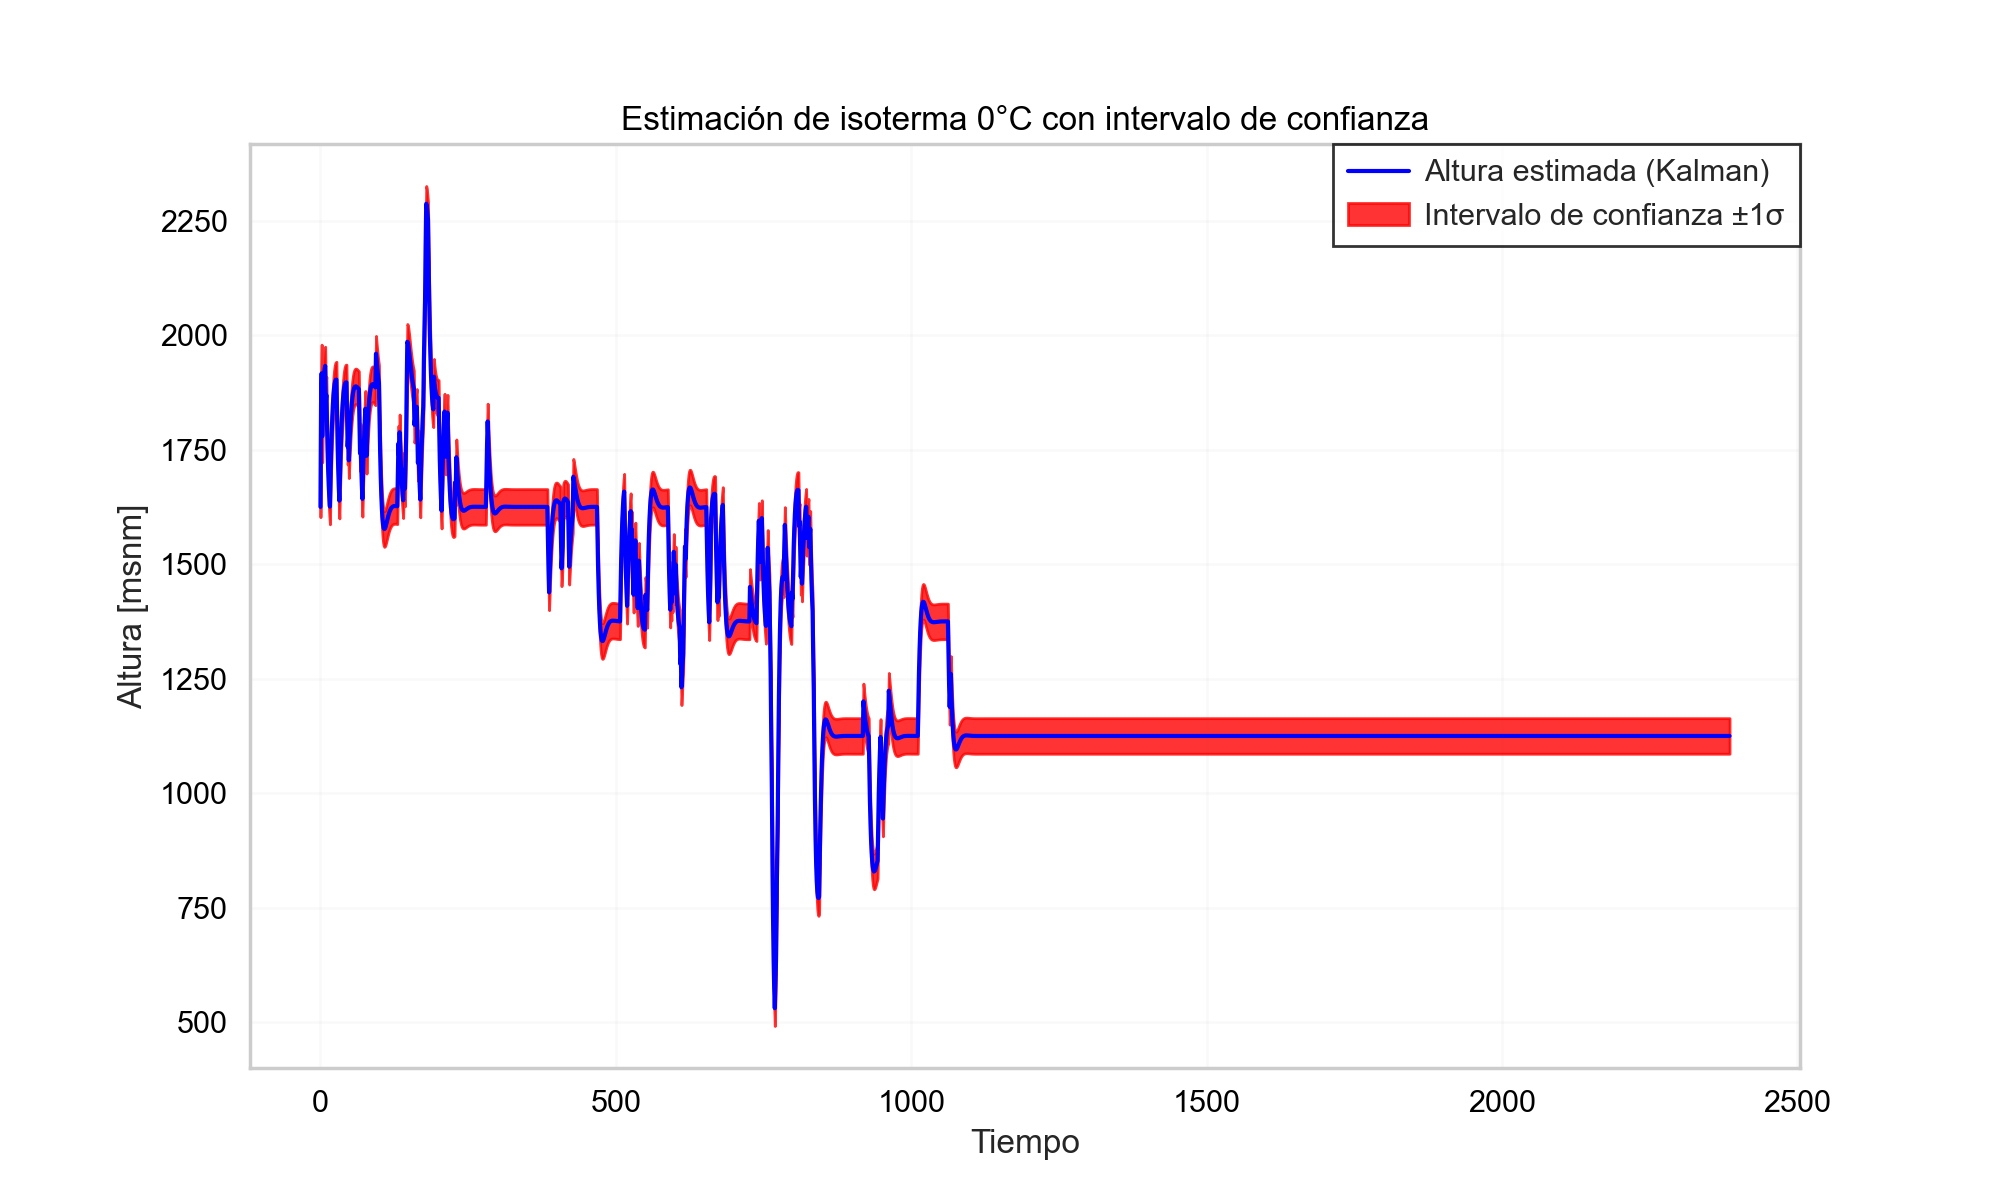

[22.36067977 66.71334336 62.59672593 ... 38.85099963 38.85099963
 38.85099963]


In [73]:
# Convertir la lista a array por si acaso
covarianzas = np.array(var_altura)
desviacion_std = np.sqrt(covarianzas)

# Intervalos de confianz
superior = alturas_filtradas + desviacion_std
inferior = alturas_filtradas - desviacion_std

# Plot
plt.figure(figsize=(10,6))
plt.plot(alturas_filtradas, label='Altura estimada (Kalman)', color='blue')
plt.fill_between(range(len(alturas_filtradas)), inferior, superior, color='red', alpha=0.8,
                 label='Intervalo de confianza ±1σ')
#plt.plot(AlturasIsoterma_ajustadas, label='Original', linestyle='--', color='blue')
plt.xlabel('Tiempo')
plt.ylabel('Altura [msnm]')
plt.title('Estimación de isoterma 0°C con intervalo de confianza')
plt.legend()
plt.grid(True)
plt.show()
print(desviacion_std)


Plot final

In [74]:
def plot_mrr_Isotermas4(xlim, times, heights, Ze, isoterma_Ze, isoterma_Vf =None, Vf=None, hora_local=False, ax=None,
              ytickloc='both', colorhex=paleta0, sd_sup_Ze=None, sd_inf_Ze=None, sd_sup_Vf=None, sd_inf_Vf=None):
    # Configuración de colormap
    cmap4 = list(zip(np.linspace(0, 1, len(colorhex)), colorhex))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom", cmap4)
    dbzmap.set_bad('0.9', 1)
    bounds = np.arange(-5, 50, 1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)

    # Configuración de ejes
    xlabel = r'Hora Local $\rightarrow$' if hora_local else r'Hora UTC $\rightarrow$'
    ylim = [0, 3600] if heights[-1] < 5000 else [0, 8000]

    # Conversión de tiempos a numérico
    times_num = dates.date2num(times)
    xmin, xmax = (dates.date2num(xlim) if xlim != ''
                  else (times_num[0], times_num[-1]))

    # Cálculo de la extensión para imshow
    dx = (times_num[-1] - times_num[0]) / (len(times_num) - 1) if len(times_num) > 1 else 0
    dy = (heights[-1] - heights[0]) / (len(heights) - 1) if len(heights) > 1 else 0

    extent = [
        times_num[0] - dx/2,  # xmin
        times_num[-1] + dx/2,  # xmax
        heights[0] - dy/2,     # ymin
        heights[-1] + dy/2     # ymax
    ]

    # Configuración de ticks según duración
    total_seconds = (xlim[1] - xlim[0]).total_seconds()
    if total_seconds <= 14400:  # ≤ 4 horas
        xlocator = ('hour', range(0, 24, 1))
        xminorlocator = ('minute', 30)
    elif 14400 < total_seconds <= 82800:  # 4-23 horas
        xlocator = ('hour', range(0, 24, 3))
        xminorlocator = ('hour', range(0, 24, 1))
    else:  # > 23 horas
        xlocator = ('hour', range(0, 24, 6))
        xminorlocator = ('hour', range(0, 24, 2))

    if Vf is None:
        # Configuración para un solo gráfico (solo reflectividad)
        if ax is None:
            fig, ax = pplt.subplots(refwidth=5, refaspect=3)

        mZe = ax.imshow(Ze.T,  # Transponer para orientación correcta
                      extent=extent,
                      aspect='auto',
                      origin='lower',
                      norm=norm,
                      cmap=dbzmap,
                      interpolation='nearest')
        
        if isoterma_Ze is not None:
            ax.plot(times_num, isoterma_Ze, color='darkblue', linewidth=1.5, 
                  label='Isoterma 0°C detectada')
            if sd_sup_Ze is not None and sd_inf_Ze is not None:
                ax.plot(times_num, sd_sup_Ze, color='red', linestyle='--', linewidth=1)
                ax.plot(times_num, sd_inf_Ze, color='red', linestyle='--', linewidth=1)
            ax.legend()  # Mostrar leyenda

        ax.format(ultitle='Reflectividad Equivalente',
                xrotation=False,
                xformatter='concise',
                xlocator=xlocator,
                xminorlocator=xminorlocator,
                ylim=ylim,
                yticklabelloc=ytickloc,
                ytickloc='both',
                xticklabelsize=8,
                suptitle='Radar Perfilador MRR en UOH Rancagua',
                ylabel='Altitud [msnm]',
                xlabel=xlabel)
        ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7)

    else:
        # Configuración para dos gráficos (reflectividad y velocidad)
        fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3, sharex=True)

        # Gráfico de reflectividad
        mZe = ax[0].imshow(Ze.T,
                         extent=extent,
                         aspect='auto',
                         origin='lower',
                         norm=norm,
                         cmap=dbzmap,
                         interpolation='nearest')
        add_no_data(ax[0], times, xlim)

        # Gráfico de velocidad
        mVf = ax[1].imshow(Vf.T,
                         extent=extent,
                         aspect='auto',
                         origin='lower',
                         vmin=-3, vmax=10,
                         cmap='RdBu',
                         interpolation='nearest')
        add_no_data(ax[1], times, xlim)

        # Agregar línea de la isoterma en ambos gráficos
        if isoterma_Ze is not None :
            ax[0].plot(times_num, isoterma_Ze, color='darkblue', linewidth=1.5, 
                  label='Isoterma 0°C detectada')
            if sd_sup_Ze is not None and sd_inf_Ze is not None:
                ax[0].plot(times_num, sd_sup_Ze, color='red', linestyle='--', linewidth=1)
                ax[0].plot(times_num, sd_inf_Ze, color='red', linestyle='--', linewidth=1)
            ax[0].legend(loc='upper right', fontsize=10)  
            
        
        if isoterma_Vf is not None: 
            ax[1].plot(times_num, isoterma_Vf, color='red', linewidth=1.5, 
                  label='Isoterma 0°C detectada')
            if sd_sup_Vf is not None and sd_inf_Vf is not None:
                ax[1].plot(times_num, sd_sup_Vf, color='darkblue', linestyle='--', linewidth=1)
                ax[1].plot(times_num, sd_inf_Vf, color='darkblue', linestyle='--', linewidth=1)
            ax[1].legend(loc='upper right', fontsize=10)

        # Formateo del primer gráfico
        ax[0].format(ultitle='Reflectividad Equivalente',
                   xrotation=False,
                   xformatter='concise',
                   xlocator=xlocator,
                   xminorlocator=xminorlocator,
                   ylim=ylim,
                   yticklabelloc='both',
                   ytickloc='both',
                   xticklabelsize=8,
                   suptitle='Radar Perfilador MRR en UOH Rancagua',
                   ylabel='Altitud [msnm]',
                   xlabel=xlabel)
        ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4)

        # Formateo del segundo gráfico
        ax[1].format(ultitle='Velocidad de caída',
                   xrotation=False,
                   xformatter='concise',
                   xlocator=xlocator,
                   xminorlocator=xminorlocator,
                   ylim=ylim,
                   yticklabelloc='both',
                   ytickloc='both',
                   xticklabelsize=8)
        ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4, extend='both')

    # Ajustar límites de tiempo si se especificaron
    if xlim != '':
        if Vf is None:
            ax.format(xlim=xlim)
        else:
            ax[0].format(xlim=xlim)
            ax[1].format(xlim=xlim)

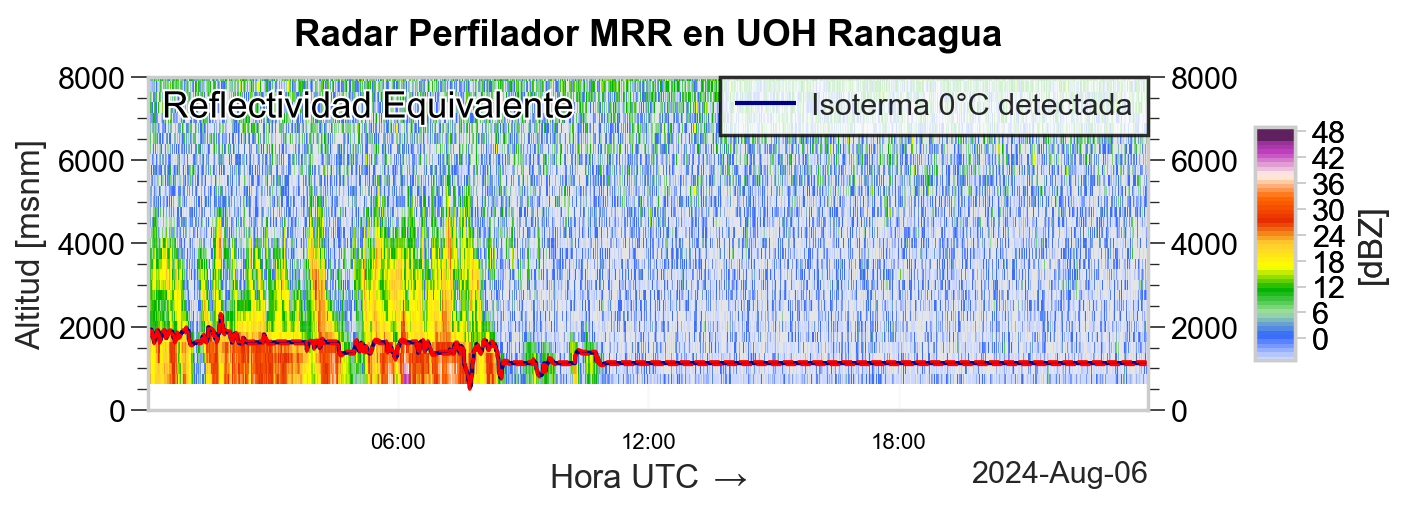

In [75]:
# Grafico solo de reflectividad
new_time = pd.to_datetime(ds.time.values)
xlim = [new_time[0], new_time[-1]]
heights = ds.height[0, :].values + 500  
Ze = ds['attenuated_radar_reflectivity'].T 

# Ajustar alturas_filtradas para que coincida con times
if len(alturas_filtradas) < len(new_time):
    alturas_filtradas = np.append([alturas_filtradas[0]], alturas_filtradas)
elif len(alturas_filtradas) > len(new_time):
    alturas_filtradas = alturas_filtradas[:len(new_time)]


plot_mrr_Isotermas4(
    xlim=xlim,
    times=new_time,
    heights=heights,
    Ze=Ze.T,
    isoterma_Ze=alturas_filtradas,  # Línea de isoterma filtrada
    hora_local=False,
    sd_sup_Ze = superior,
    sd_inf_Ze = inferior
)

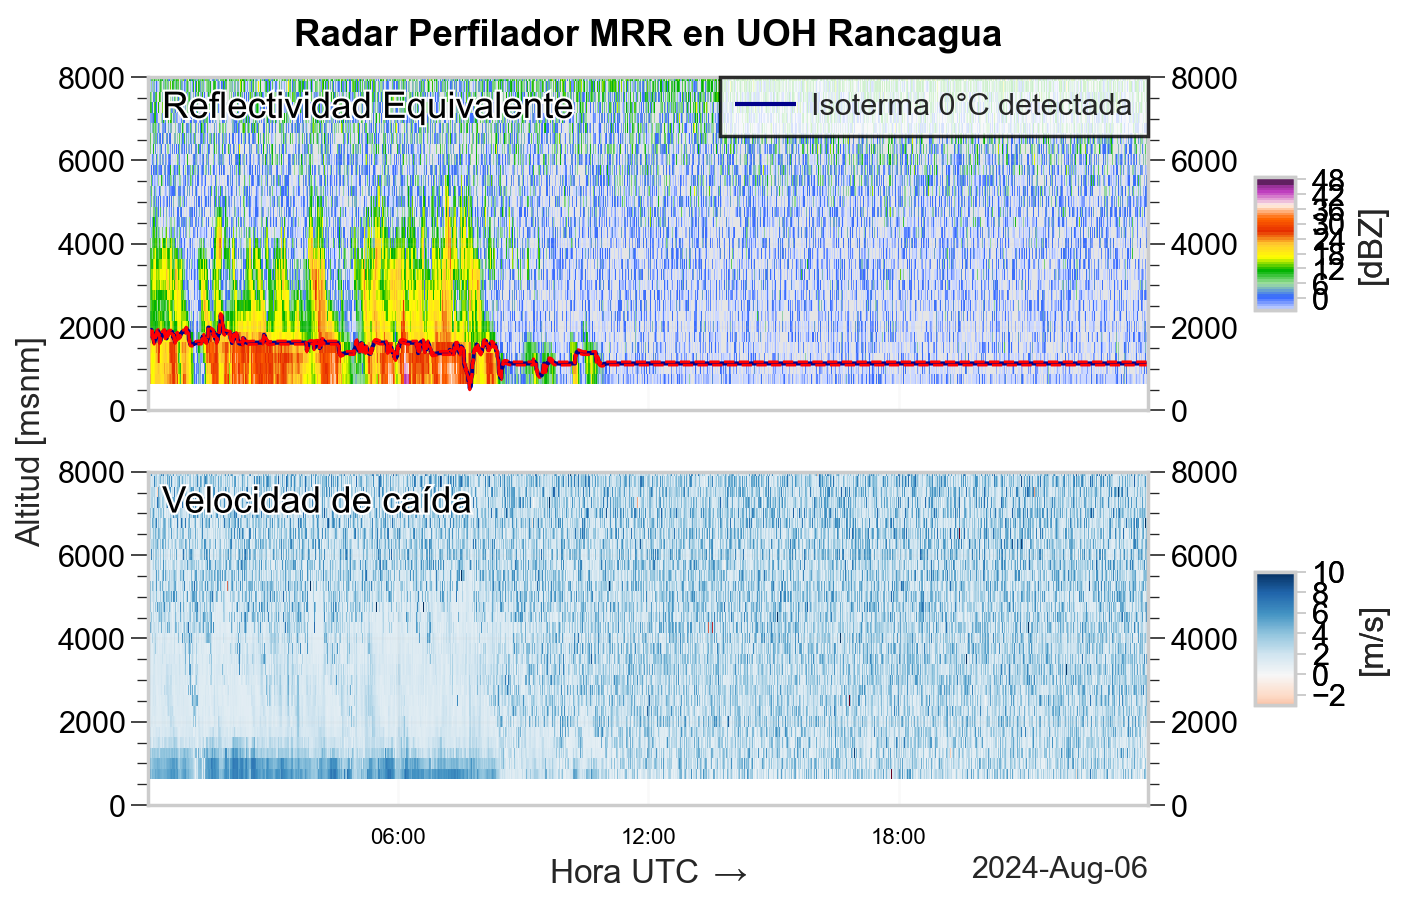

In [76]:
#Queda este obsoleto xd

plot_mrr_Isotermas4(
    xlim=[new_time[0], new_time[-1]],                 # Límites de tiempo
    times=new_time,                                   # Eje temporal
    heights=ds.height[0, :].values + 500,             # Alturas ajustadas
    Ze=ds['attenuated_radar_reflectivity'].values,  # Reflectividad
    Vf=ds['fall_velocity'].values,                  # Velocidad de caída
    isoterma_Ze=alturas_filtradas,                       # Línea de isoterma filtrada
    hora_local=False,
    sd_sup_Ze = superior,
    sd_inf_Ze = inferior
) 

## Filtro Kalman: Velocidad de Caida

In [77]:
IndicesIsoterma_Vf=[]
for resultado in resultados_isoterma_Vf:
    t = resultado["iter"]
    altura_minima = resultado["altura_minima"]
    idx_altura = int((np.abs(heights_ajustado - altura_minima)).argmin())
    IndicesIsoterma_Vf.append(idx_altura)

AlturasIsoterma_Vf = np.array(IndicesIsoterma_Vf) * FactorConversion

In [78]:
AlturasIsoterma_ajustadas_Vf = AlturasIsoterma_Vf + altura_inicial_desfase
delta_t = 20
Q_ruido_proceso_reflectividad = 1e-5   # Ruido del proceso para reflectividad
Q_ruido_proceso_gradiente = 1e-5       # Ruido del proceso para gradiente
R_ruido_medicion = 10                   # Ruido de medición
factor_ponderador = 0.65

alturas_filtradas_Vf, ganancias_Vf, var_altura_Vf, var_velocidad_Vf, covar_Vf, tasa_cambio_Vf = filtro_kalman(AlturasIsoterma_ajustadas_Vf, 
                                   delta_t, 
                                   Q_ruido_proceso_reflectividad, 
                                   Q_ruido_proceso_gradiente, 
                                   R_ruido_medicion, 
                                   factor_ponderador)


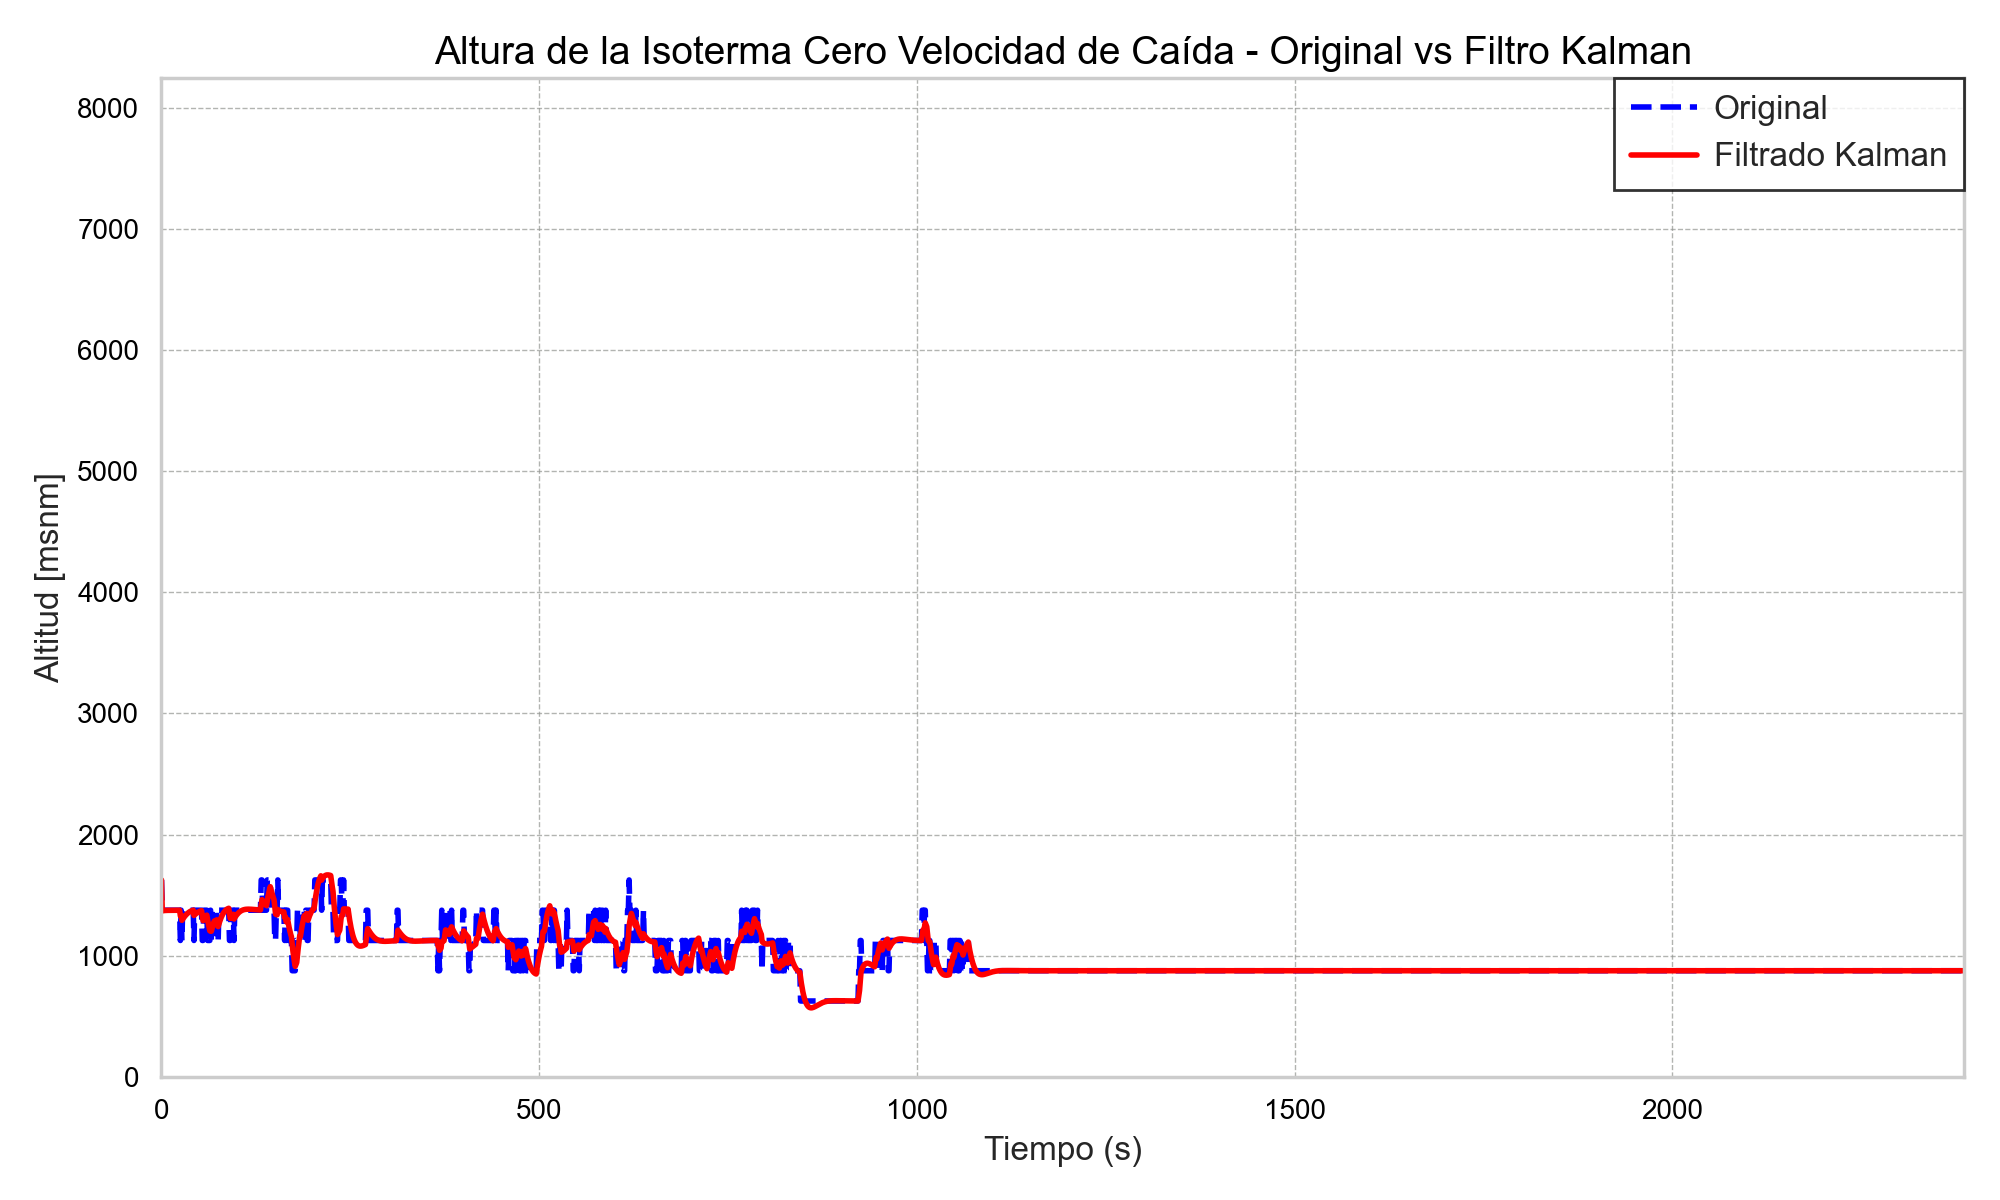

In [79]:
fig, ax = plt.subplots(figsize=(10, 6))  
ax.plot(AlturasIsoterma_ajustadas_Vf, label="Original", linestyle='--', color='blue', linewidth=2)
ax.plot(alturas_filtradas_Vf, label="Filtrado Kalman", linestyle='-', color='red', linewidth=2)
ax.set_xlabel('Tiempo (s)', fontsize=12) 
ax.set_ylabel('Altitud [msnm]', fontsize=12)
ax.set_title('Altura de la Isoterma Cero Velocidad de Caída - Original vs Filtro Kalman', fontsize=14)
ax.set_xlim([0, len(AlturasIsoterma)])  
ax.set_ylim([0, heights[-1]])    #Quité el .values porque me tiraba error
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper right', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()  
plt.show()

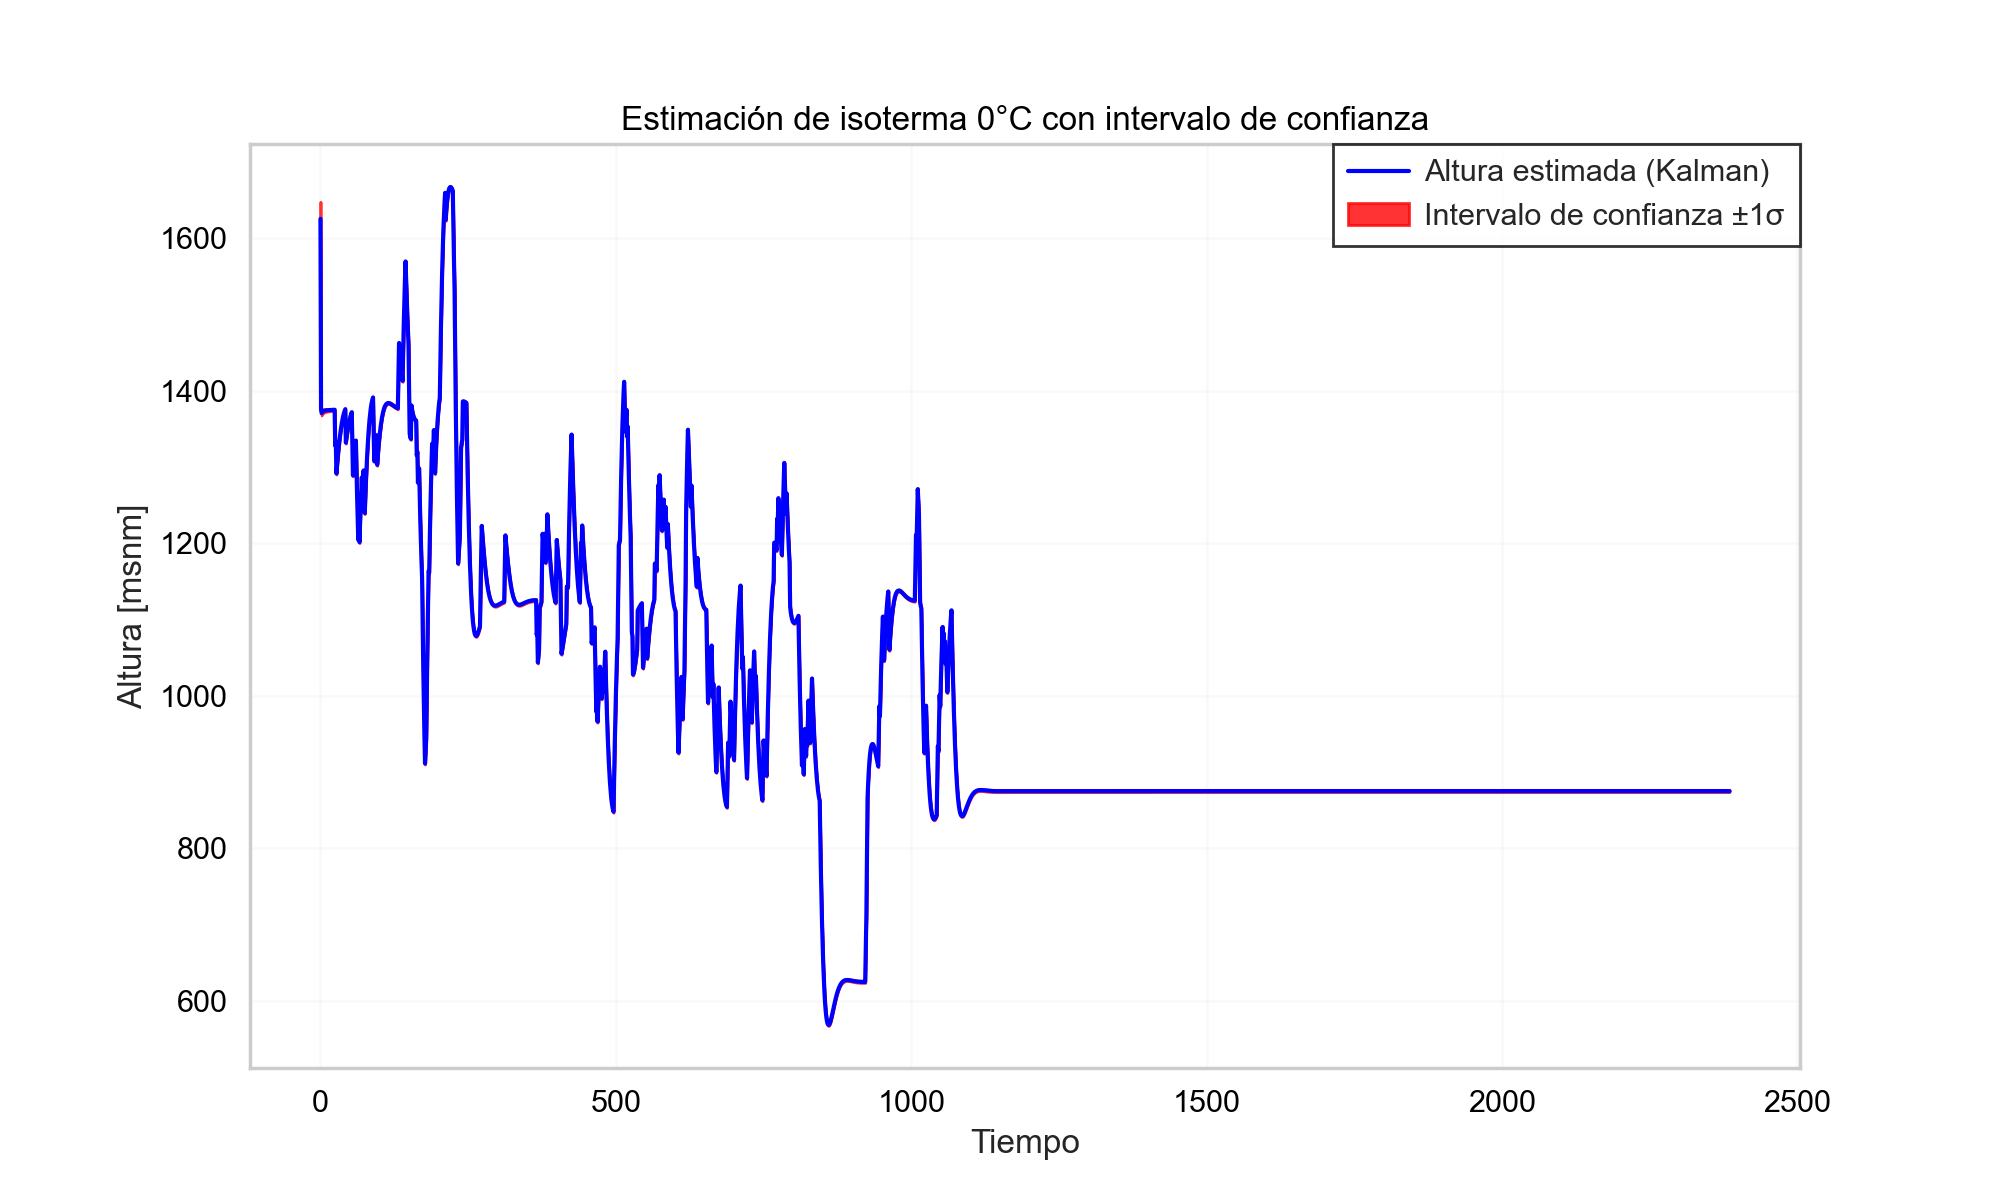

[22.36067977  3.16188733  3.13304157 ...  1.34687573  1.34687573
  1.34687573]


In [80]:
# Convertir la lista a array por si acaso
covarianzas_Vf = np.array(var_altura_Vf)
desviacion_std_Vf = np.sqrt(covarianzas_Vf)

# Intervalos de confianz
superior_Vf = alturas_filtradas_Vf + desviacion_std_Vf
inferior_Vf = alturas_filtradas_Vf - desviacion_std_Vf

# Plot
plt.figure(figsize=(10,6))
plt.plot(alturas_filtradas_Vf, label='Altura estimada (Kalman)', color='blue')
plt.fill_between(range(len(alturas_filtradas_Vf)), inferior_Vf, superior_Vf, color='red', alpha=0.8,
                 label='Intervalo de confianza ±1σ')
#plt.plot(AlturasIsoterma_ajustadas, label='Original', linestyle='--', color='blue')
plt.xlabel('Tiempo')
plt.ylabel('Altura [msnm]')
plt.title('Estimación de isoterma 0°C con intervalo de confianza')
plt.legend()
plt.grid(True)
plt.show()
print(desviacion_std_Vf)

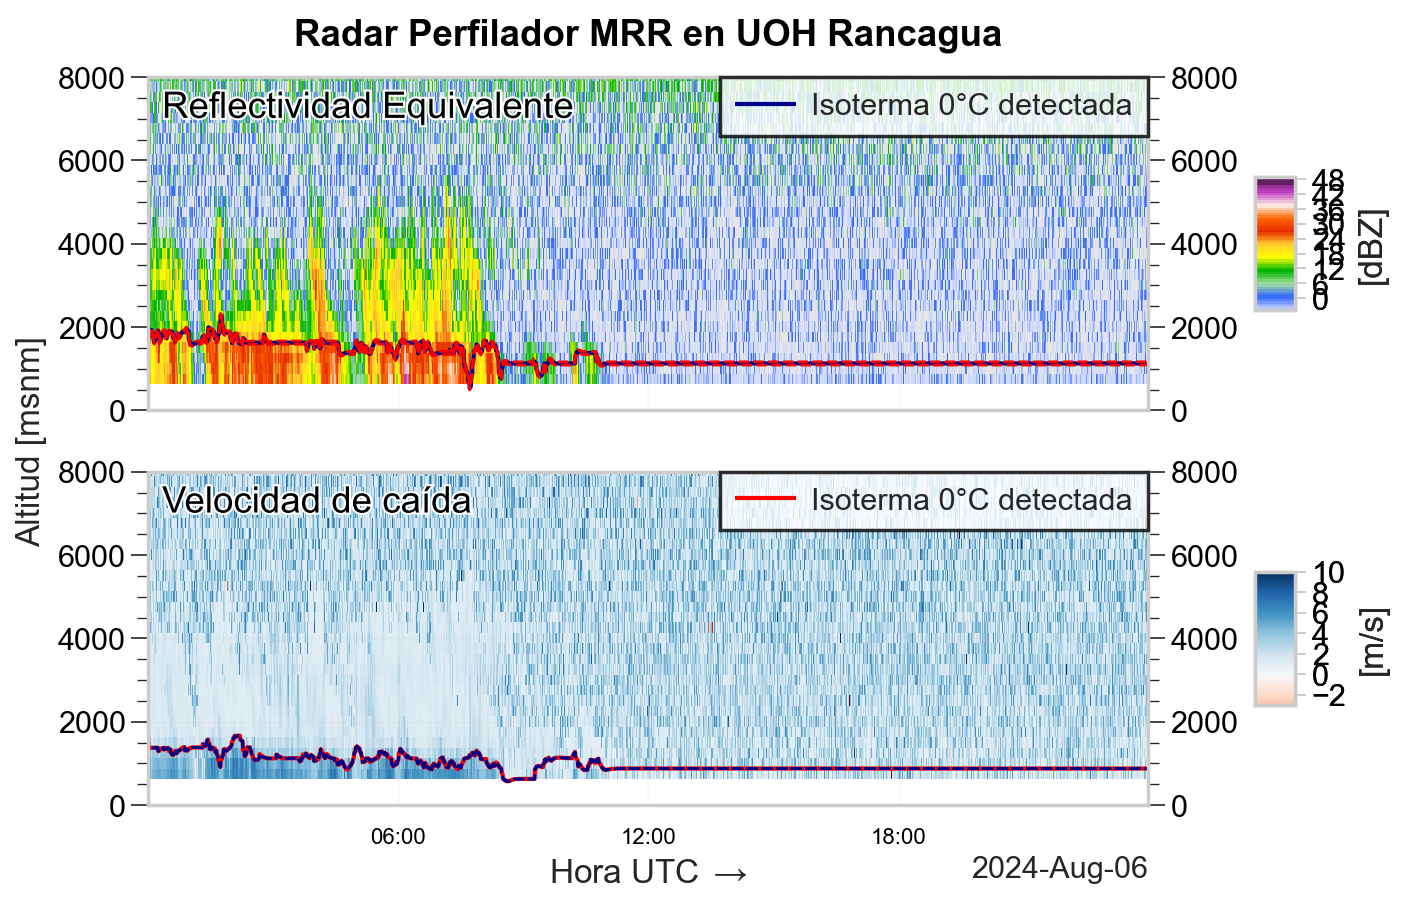

In [81]:
new_time = pd.to_datetime(ds.time.values)
xlim = [new_time[0], new_time[-1]]
heights = ds.height[0, :].values + 500  
Ze = ds['attenuated_radar_reflectivity'].T 

# Ajustar alturas_filtradas para que coincida con times
if len(alturas_filtradas) < len(new_time):
    alturas_filtradas = np.append([alturas_filtradas[0]], alturas_filtradas)
elif len(alturas_filtradas) > len(new_time):
    alturas_filtradas = alturas_filtradas[:len(new_time)]

# Ajustar alturas_filtradas_Vf para que coincida con times
if len(alturas_filtradas_Vf) < len(new_time):
    alturas_filtradas_Vf = np.append([alturas_filtradas_Vf[0]], alturas_filtradas_Vf)
elif len(alturas_filtradas_Vf) > len(new_time):
    alturas_filtradas_Vf = alturas_filtradas_Vf[:len(new_time)]


plot_mrr_Isotermas4(
    xlim=xlim,
    times=new_time,
    heights=heights,
    Ze=Ze.T,
    isoterma_Ze=alturas_filtradas,  # Línea de isoterma filtrada
    Vf=Vf,
    isoterma_Vf=alturas_filtradas_Vf,
    hora_local=False,
    sd_sup_Ze=superior,
    sd_inf_Ze=inferior,
    sd_sup_Vf=superior_Vf,
    sd_inf_Vf=inferior_Vf
)

Prueba con más datos

21/05/2024

In [82]:
ds_0521 = xr.open_dataset('C:/Cosas/Universidark/Proyecto de Datos 1/Datos/0521_mrr2c.nc_2.nc')

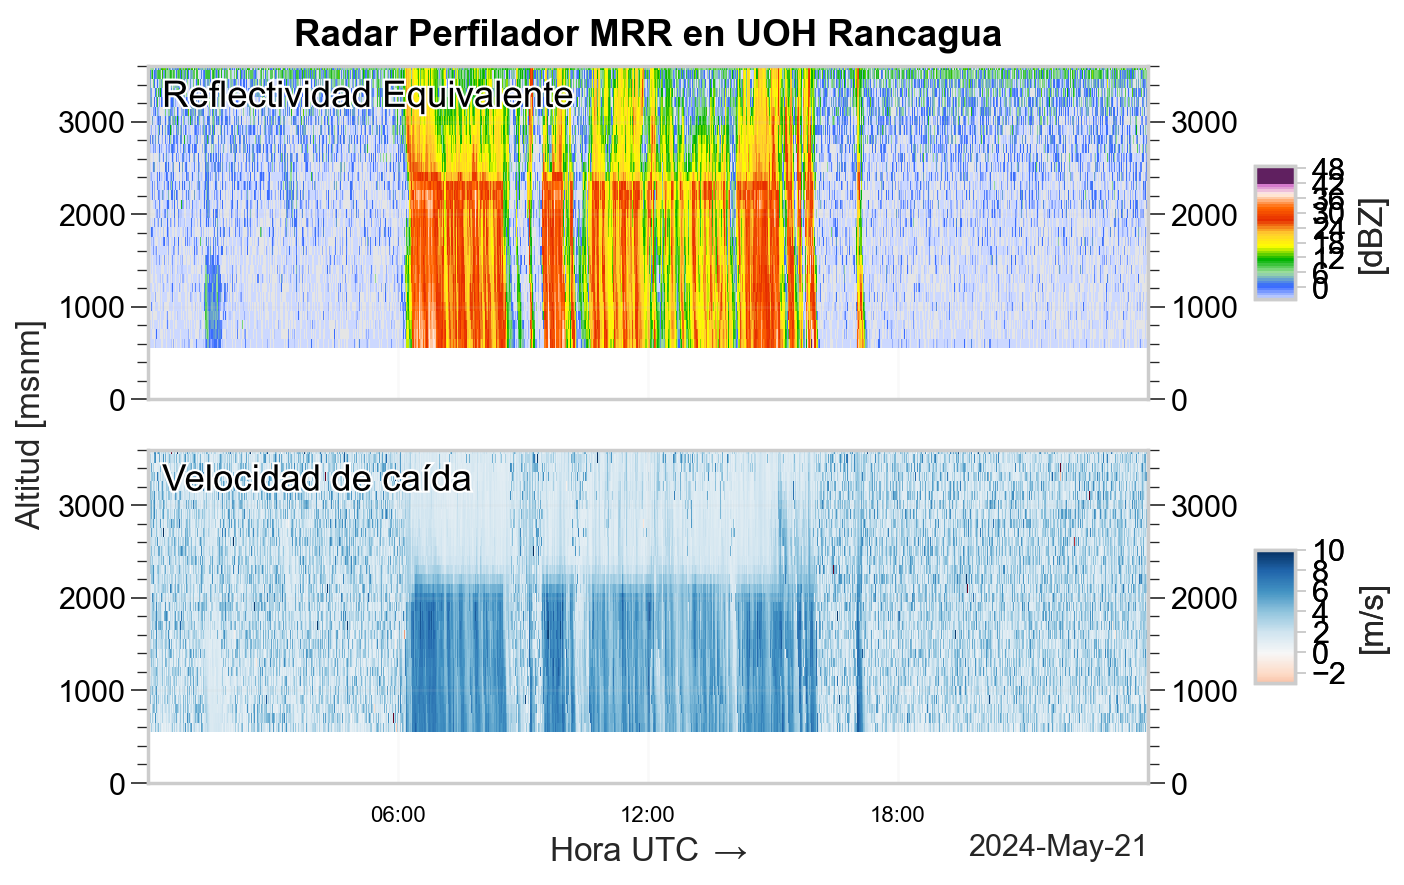

In [83]:
new_time_0521 = pd.to_datetime(ds_0521.time.values)
xlim_0521 = [new_time_0521[0], new_time_0521[-1]]
heights_0521 = ds_0521.height[0,:]+500
Ze_0521 = ds_0521['attenuated_radar_reflectivity']
Vf_0521 = ds_0521['fall_velocity']
# llamar a la funcion para plotear
plot_mrr2(xlim_0521,pd.to_datetime(ds_0521.time.values) , heights_0521, Ze_0521, Vf_0521, hora_local=False)

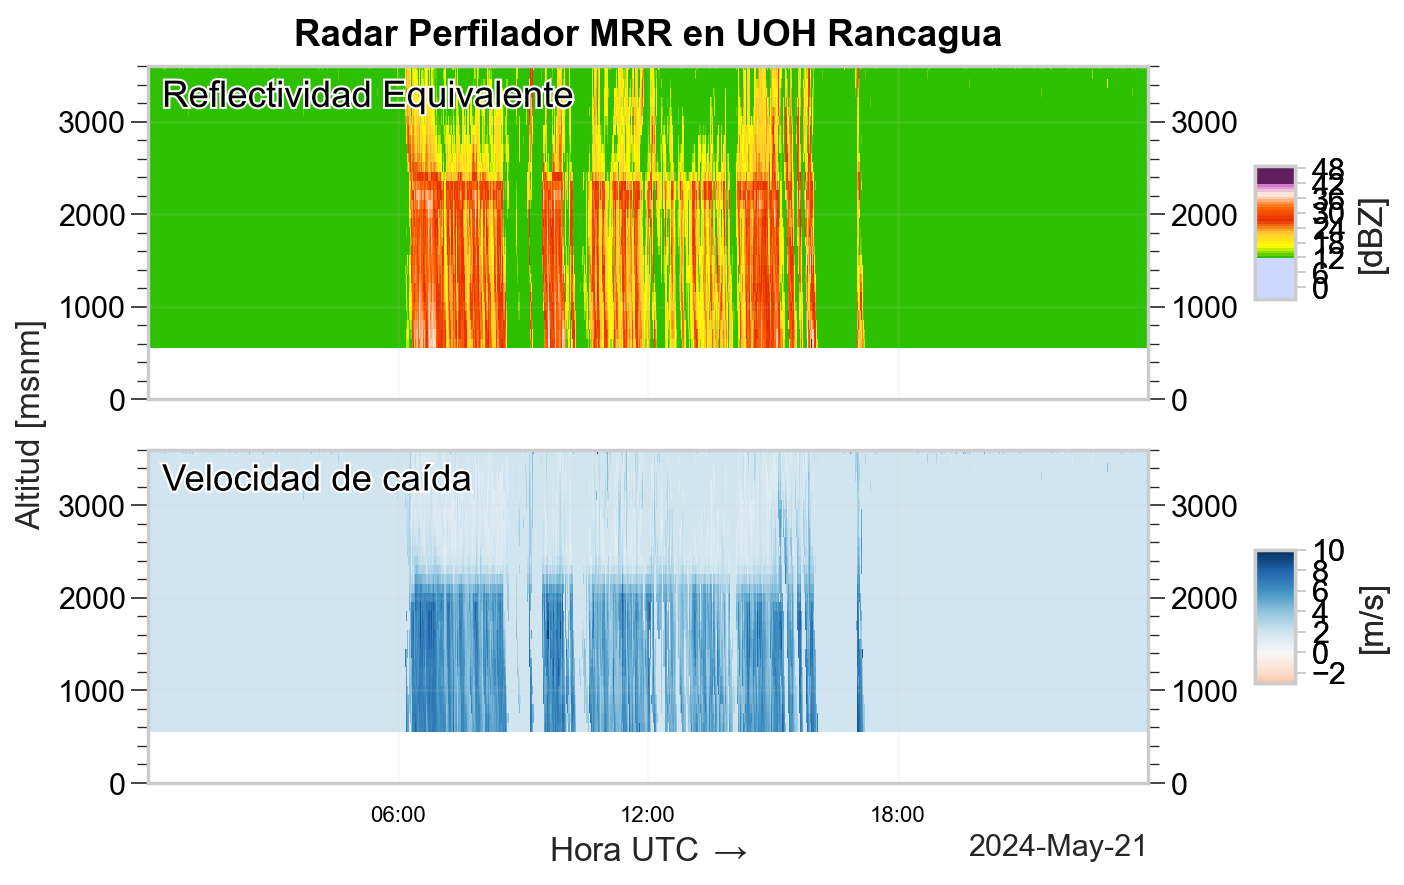

In [84]:
Ze_filtered_0521 = Ze_0521.where(Ze_0521 >= minimo_ref, minimo_ref)
Vf_filtered_0521 = np.where(Ze_0521 >= minimo_ref, Vf_0521, 2)

plot_mrr2(xlim_0521,pd.to_datetime(ds_0521.time.values) , heights_0521, Ze_filtered_0521, Vf=Vf_filtered_0521, hora_local=False)

C:\Users\conyl\AppData\Local\Temp\ipykernel_14008\173114761.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


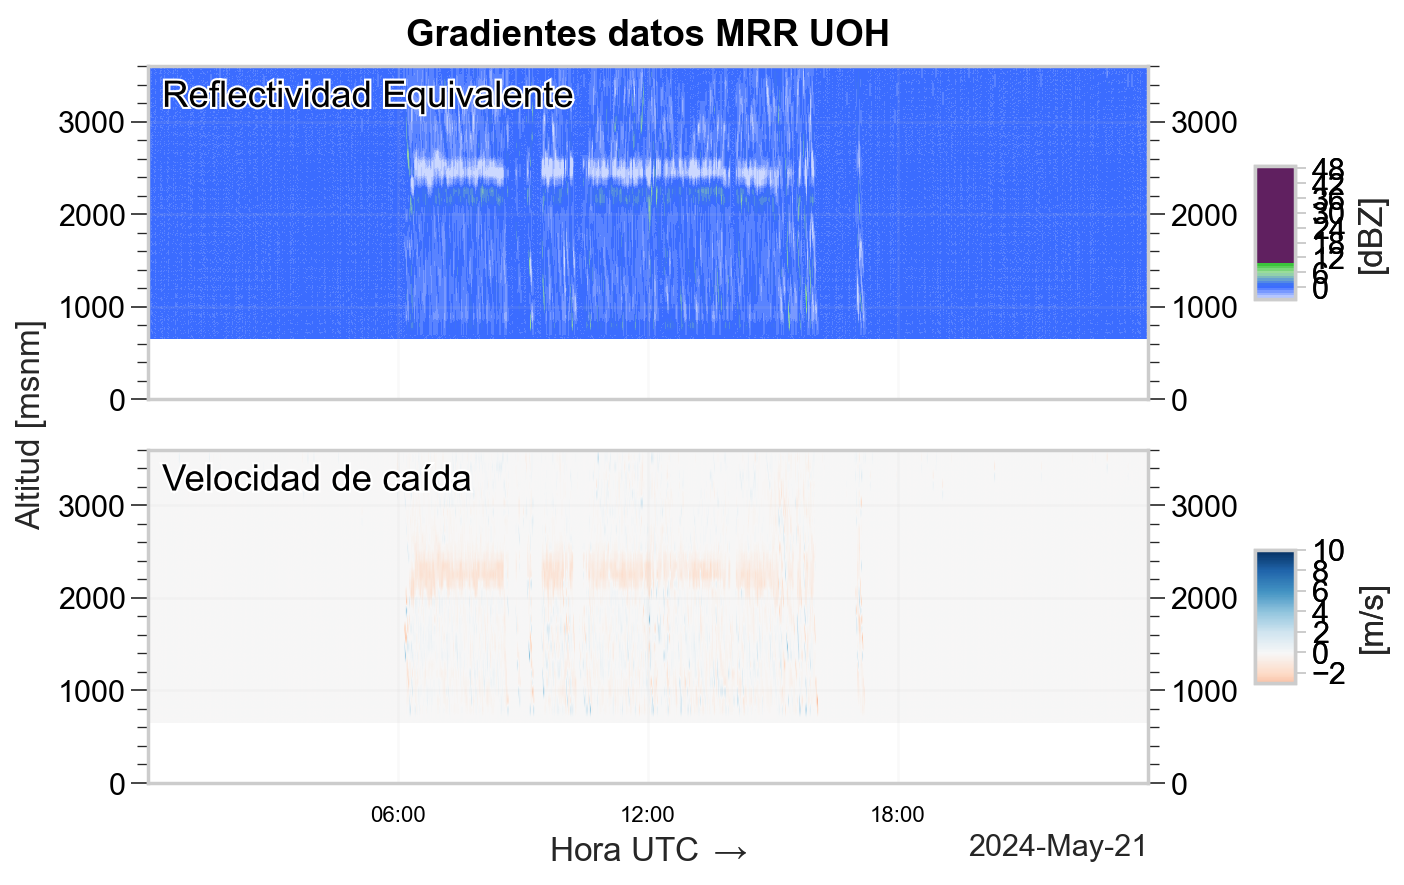

In [85]:
altura_inicial_desfase_0521 = 500 + (heights_0521[1] - heights_0521[0]) / 2   # Ajuste altura

heights_ajustado_0521 = ds_0521.height[0, :] + altura_inicial_desfase_0521

marco = 1
gradiente_Ze_0521 = calcular_gradiente(Ze_filtered_0521.T, marco) #el problema, una vez más era la traspuesta
gradiente_Vf_0521 = calcular_gradiente(Vf_filtered_0521.T, marco)
plot_mrr3_imshow(xlim_0521, new_time_0521, heights_ajustado_0521, gradiente_Ze_0521, Vf=gradiente_Vf_0521, hora_local=False)

C:\Users\conyl\AppData\Local\Temp\ipykernel_14008\4273697507.py:127: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


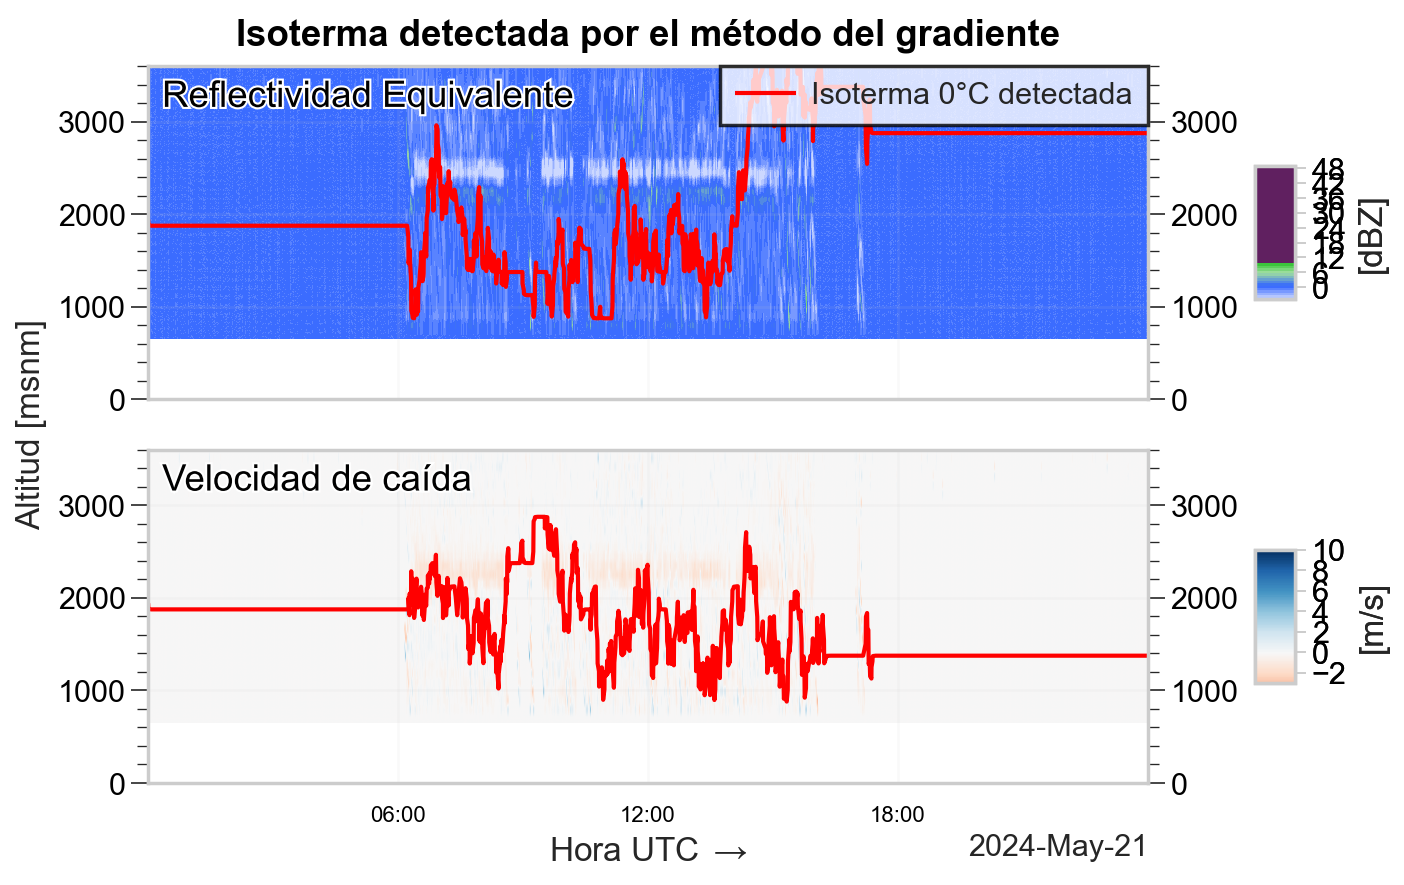

In [86]:
resultados_isoterma_Ze_0521 = detectar_isoterma_cero(gradiente_Ze_0521, altura_inicial=2000)
resultados_isoterma_Vf_0521 = detectar_isoterma_cero(gradiente_Vf_0521, altura_inicial=2000)

# Graficar con la isoterma
plot_mrr3_imshow_con_isoterma(xlim_0521, new_time_0521, heights_ajustado_0521, gradiente_Ze_0521, resultados_isoterma_Ze_0521, Vf=gradiente_Vf_0521, isoterma_results_Vf=resultados_isoterma_Vf_0521)

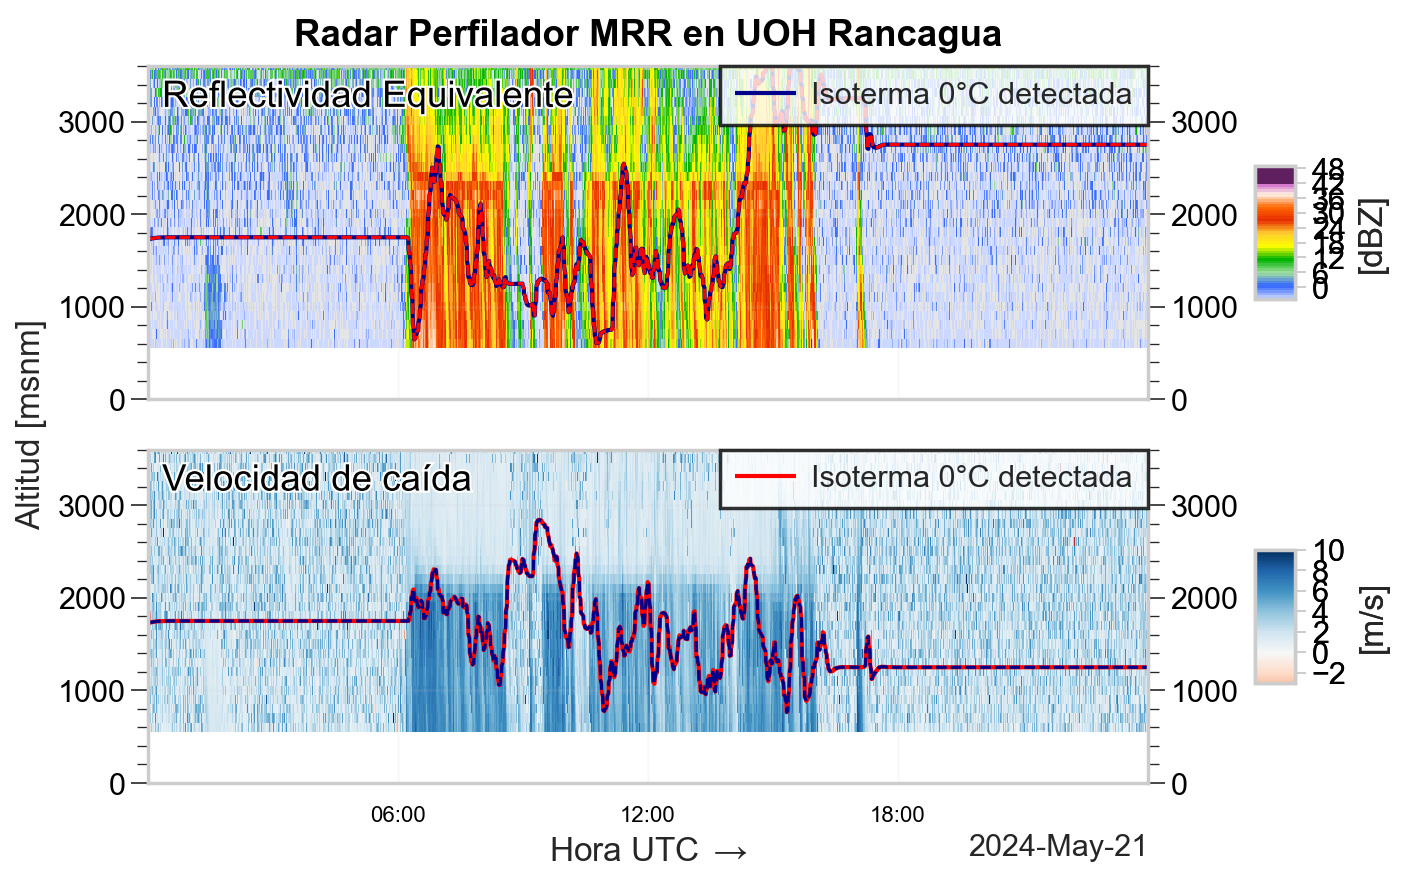

In [87]:
Ze_0521 = ds_0521['attenuated_radar_reflectivity'].T 
IndicesIsoterma_0521=[]
for resultado in resultados_isoterma_Ze_0521:
    t = resultado["iter"]
    altura_minima = resultado["altura_minima"]
    idx_altura = int((np.abs(heights_ajustado_0521 - altura_minima)).argmin())
    IndicesIsoterma_0521.append(idx_altura)

FactorConversion_0521 = (heights_0521[-1].values-500)/ len(heights_0521)
AlturasIsoterma_0521 = np.array(IndicesIsoterma_0521) * FactorConversion_0521

altura_inicial_desfase_0521 = 500 + (heights_0521[1].values - heights_0521[0].values) / 2
AlturasIsoterma_ajustadas_0521 = AlturasIsoterma_0521 + altura_inicial_desfase_0521

alturas_filtradas_0521, ganancias_0521, var_altura_0521, var_velocidad_0521, covar_0521, tasa_cambio_0521 = filtro_kalman(AlturasIsoterma_ajustadas_0521, 
                                   delta_t, 
                                   Q_ruido_proceso_reflectividad, 
                                   Q_ruido_proceso_gradiente, 
                                   R_ruido_medicion, 
                                   factor_ponderador)

# Ajustar alturas_filtradas para que coincida con times
if len(alturas_filtradas_0521) < len(new_time_0521):
    alturas_filtradas_0521 = np.append([alturas_filtradas_0521[0]], alturas_filtradas_0521)
elif len(alturas_filtradas_0521) > len(new_time_0521):
    alturas_filtradas_0521 = alturas_filtradas_0521[:len(new_time_0521)]

IndicesIsoterma_Vf_0521=[]
for resultado in resultados_isoterma_Vf_0521:
    t = resultado["iter"]
    altura_minima = resultado["altura_minima"]
    idx_altura = int((np.abs(heights_ajustado_0521 - altura_minima)).argmin())
    IndicesIsoterma_Vf_0521.append(idx_altura)

AlturasIsoterma_Vf_0521 = np.array(IndicesIsoterma_Vf_0521) * FactorConversion_0521

AlturasIsoterma_ajustadas_Vf_0521 = AlturasIsoterma_Vf_0521 + altura_inicial_desfase_0521

alturas_filtradas_Vf_0521, ganancias_Vf_0521, var_altura_Vf_0521, var_velocidad_Vf_0521, covar_Vf_0521, tasa_cambio_Vf_0521 = filtro_kalman(AlturasIsoterma_ajustadas_Vf_0521, 
                                   delta_t, 
                                   Q_ruido_proceso_reflectividad, 
                                   Q_ruido_proceso_gradiente, 
                                   R_ruido_medicion, 
                                   factor_ponderador)

# Ajustar alturas_filtradas_Vf para que coincida con times
if len(alturas_filtradas_Vf_0521) < len(new_time_0521):
    alturas_filtradas_Vf_0521 = np.append([alturas_filtradas_Vf_0521[0]], alturas_filtradas_Vf_0521)
elif len(alturas_filtradas_Vf_0521) > len(new_time_0521):
    alturas_filtradas_Vf_0521 = alturas_filtradas_Vf_0521[:len(new_time_0521)]

# Convertir la lista a array por si acaso
covarianzas_0521 = np.array(var_altura_0521)
desviacion_std_0521 = np.sqrt(covarianzas_0521)

# Intervalos de confianz
superior_0521 = alturas_filtradas_0521 + desviacion_std_0521
inferior_0521 = alturas_filtradas_0521 - desviacion_std_0521

# Convertir la lista a array por si acaso
covarianzas_Vf_0521 = np.array(var_altura_Vf_0521)
desviacion_std_Vf_0521 = np.sqrt(covarianzas_Vf_0521)

# Intervalos de confianz
superior_Vf_0521 = alturas_filtradas_Vf_0521 + desviacion_std_Vf_0521
inferior_Vf_0521 = alturas_filtradas_Vf_0521 - desviacion_std_Vf_0521

plot_mrr_Isotermas4(
    xlim=xlim_0521,
    times=new_time_0521,
    heights=heights_0521,
    Ze=Ze_0521.T,
    isoterma_Ze=alturas_filtradas_0521,  # Línea de isoterma filtrada
    Vf=Vf_0521,
    isoterma_Vf=alturas_filtradas_Vf_0521,
    hora_local=False,
    sd_sup_Ze=superior_0521,
    sd_inf_Ze=inferior_0521,
    sd_sup_Vf=superior_Vf_0521,
    sd_inf_Vf=inferior_Vf_0521
)

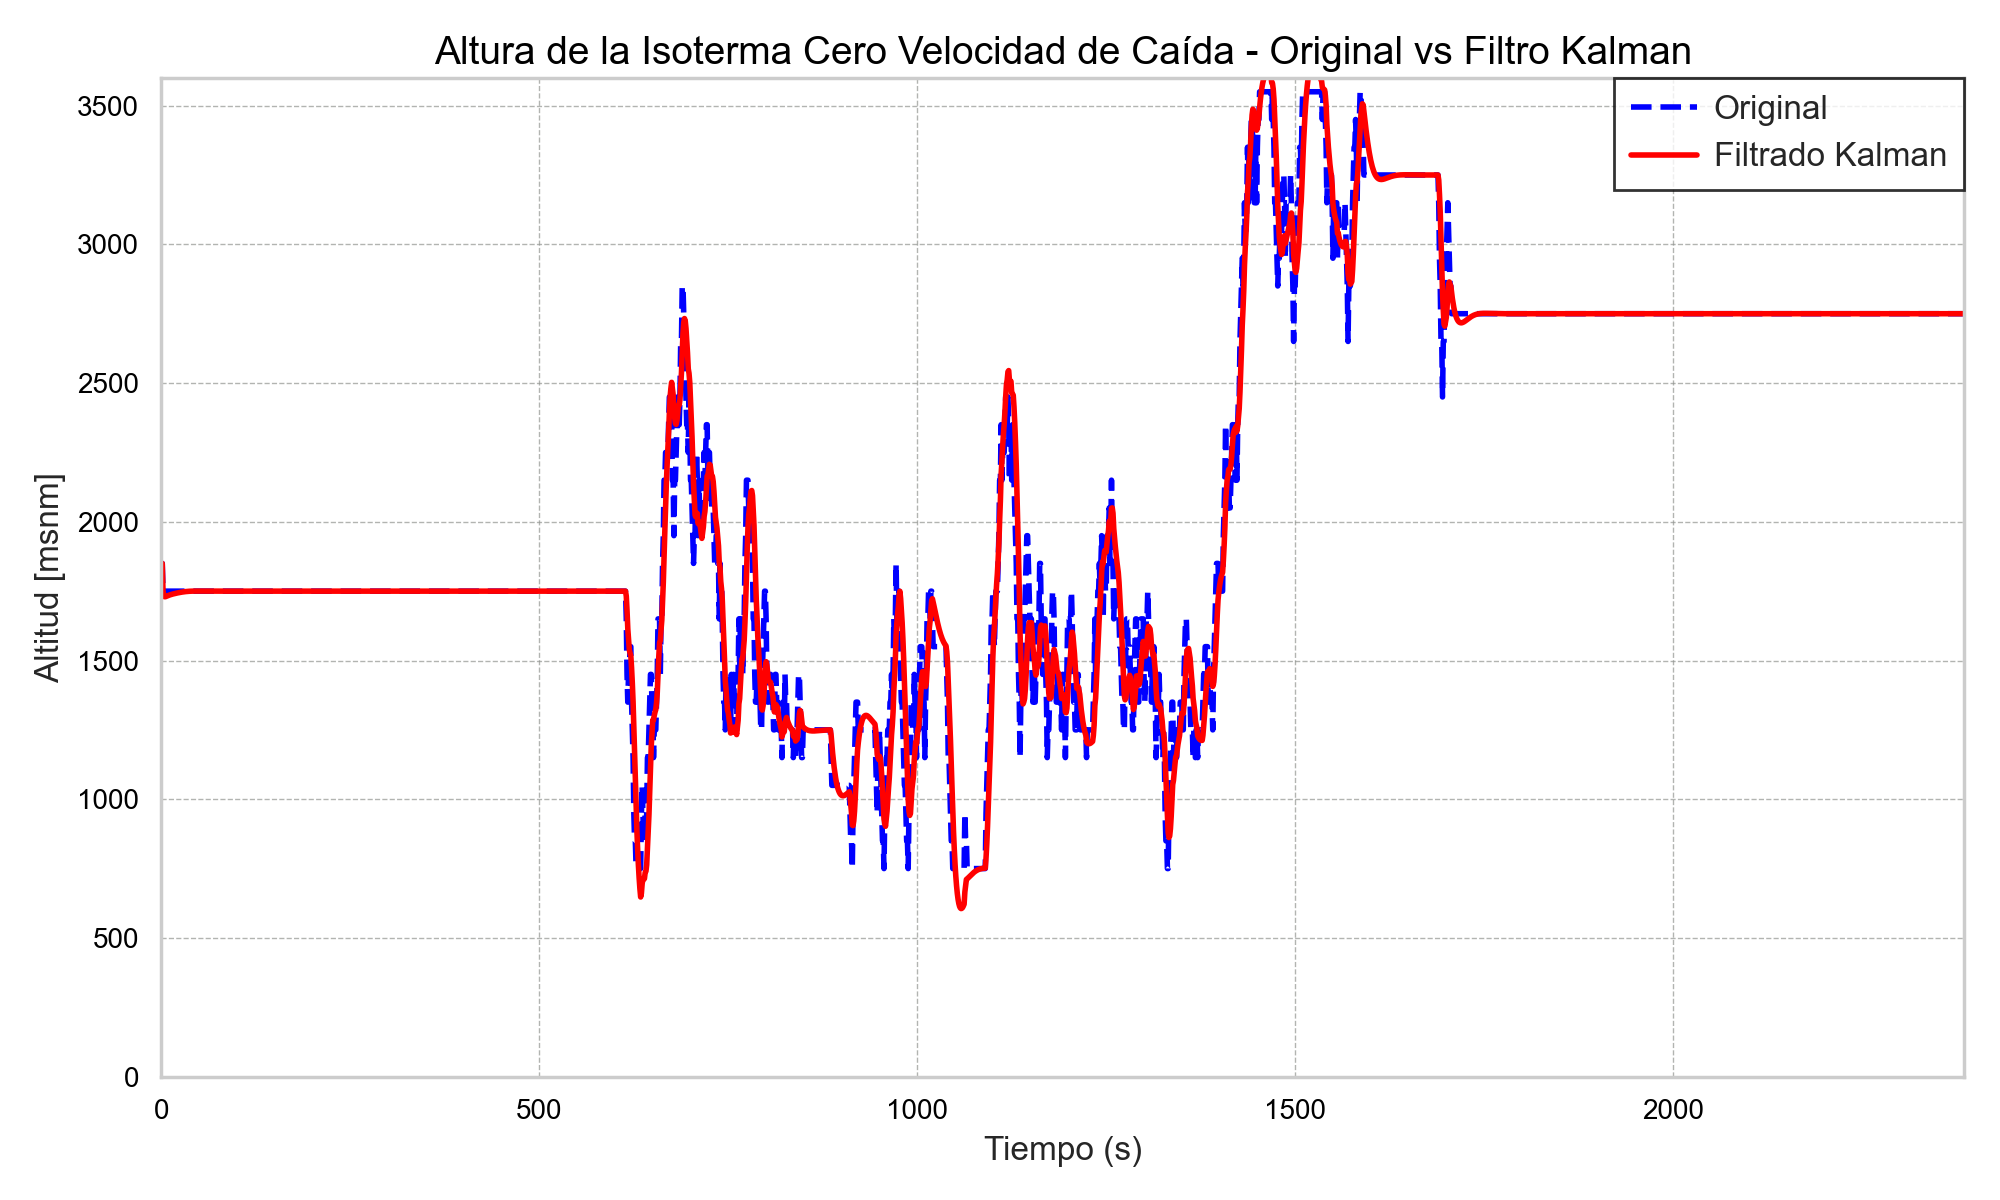

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))  
ax.plot(AlturasIsoterma_ajustadas_0521, label="Original", linestyle='--', color='blue', linewidth=2)
ax.plot(alturas_filtradas_0521, label="Filtrado Kalman", linestyle='-', color='red', linewidth=2)
ax.set_xlabel('Tiempo (s)', fontsize=12) 
ax.set_ylabel('Altitud [msnm]', fontsize=12)
ax.set_title('Altura de la Isoterma Cero Velocidad de Caída - Original vs Filtro Kalman', fontsize=14)
ax.set_xlim([0, len(AlturasIsoterma_0521)])  
ax.set_ylim([0, heights_0521[-1]])    #Quité el .values porque me tiraba error
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper right', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()  
plt.show()

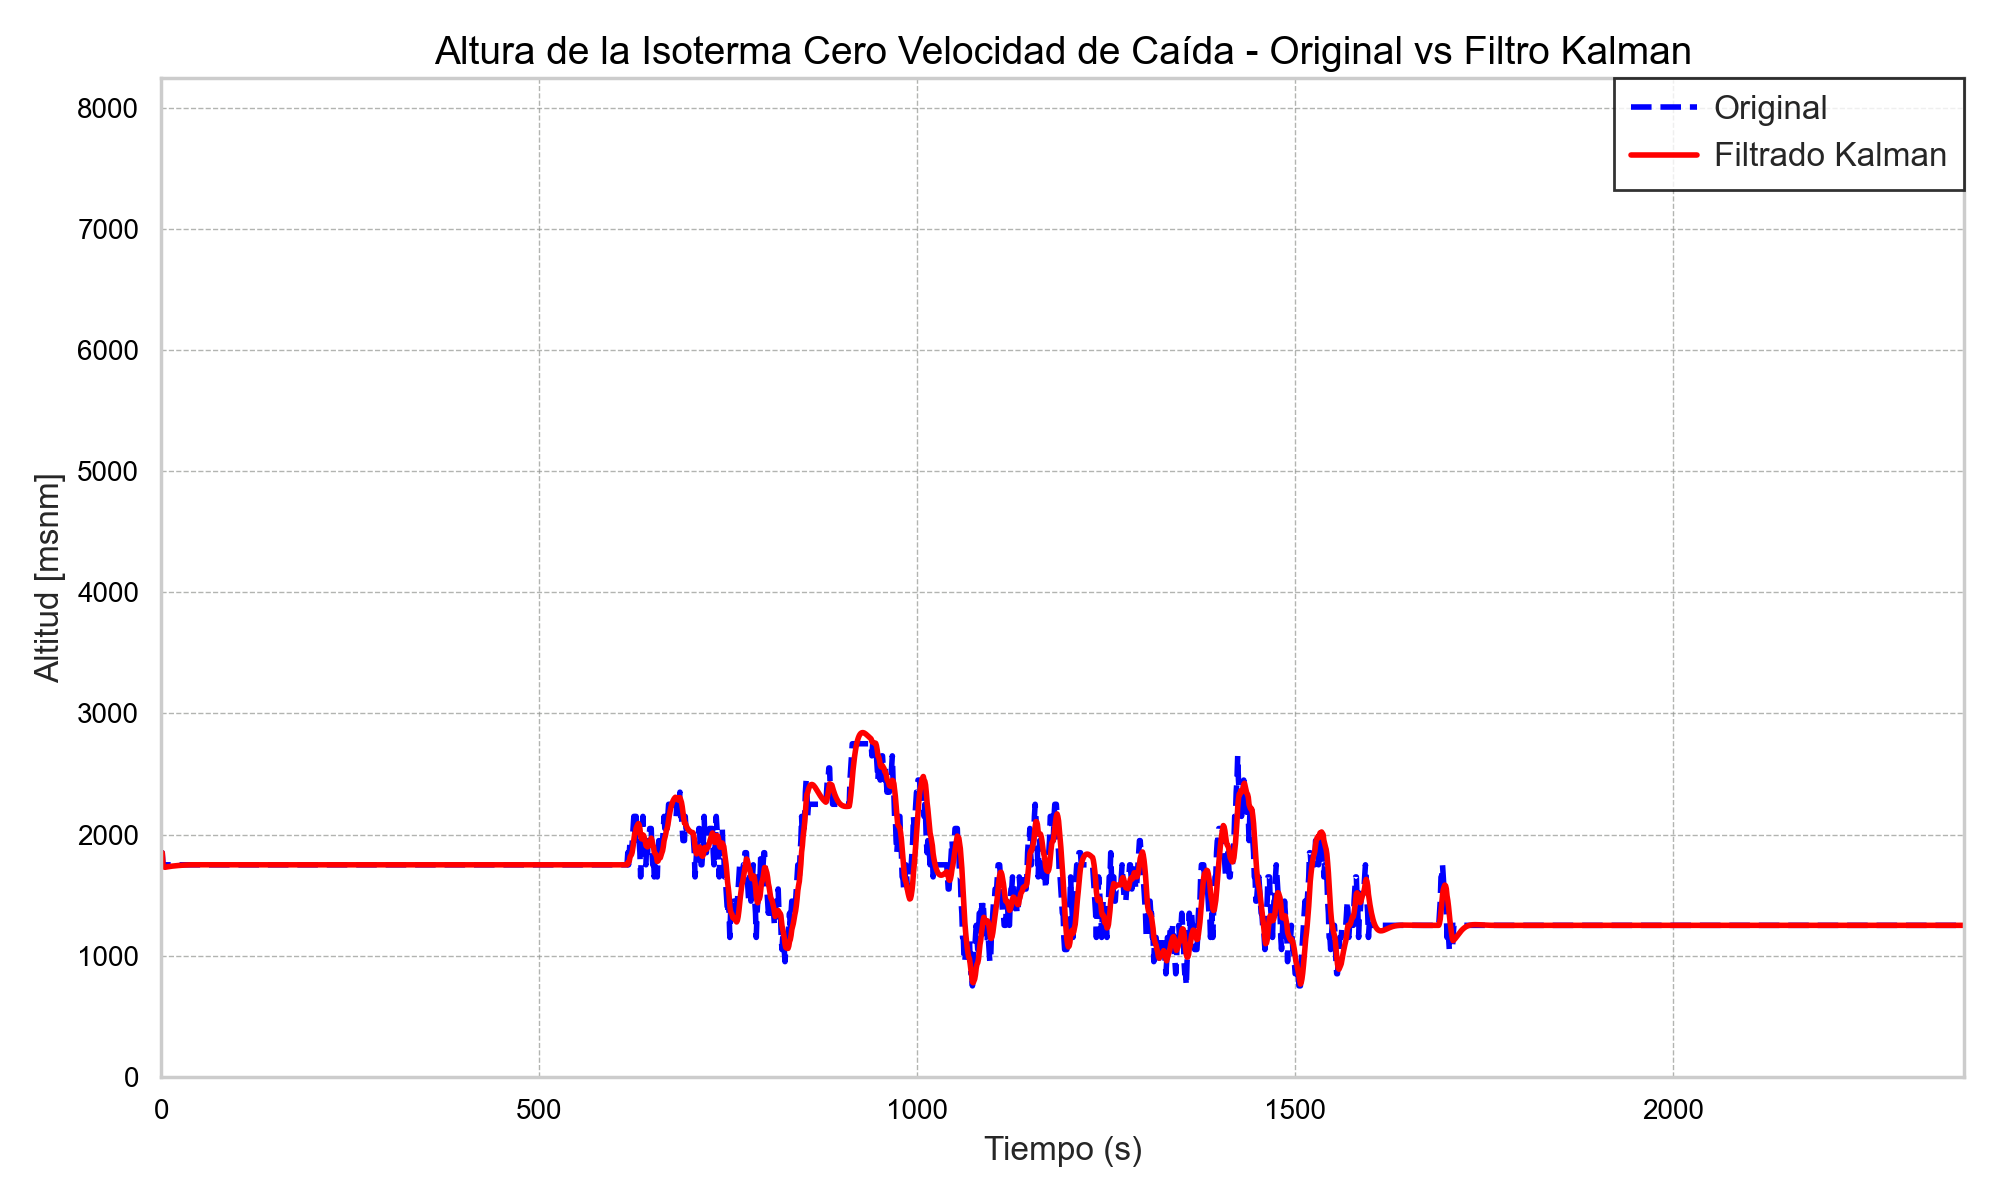

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))  
ax.plot(AlturasIsoterma_ajustadas_Vf_0521, label="Original", linestyle='--', color='blue', linewidth=2)
ax.plot(alturas_filtradas_Vf_0521, label="Filtrado Kalman", linestyle='-', color='red', linewidth=2)
ax.set_xlabel('Tiempo (s)', fontsize=12) 
ax.set_ylabel('Altitud [msnm]', fontsize=12)
ax.set_title('Altura de la Isoterma Cero Velocidad de Caída - Original vs Filtro Kalman', fontsize=14)
ax.set_xlim([0, len(AlturasIsoterma_0521)])  
ax.set_ylim([0, heights[-1]])    #Quité el .values porque me tiraba error
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper right', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()  
plt.show()

14/06/24

In [103]:
ds_0614 = xr.open_dataset('C:/Cosas/Universidark/Proyecto de Datos 1/Datos/0614_mrr2c.nc_2.nc')

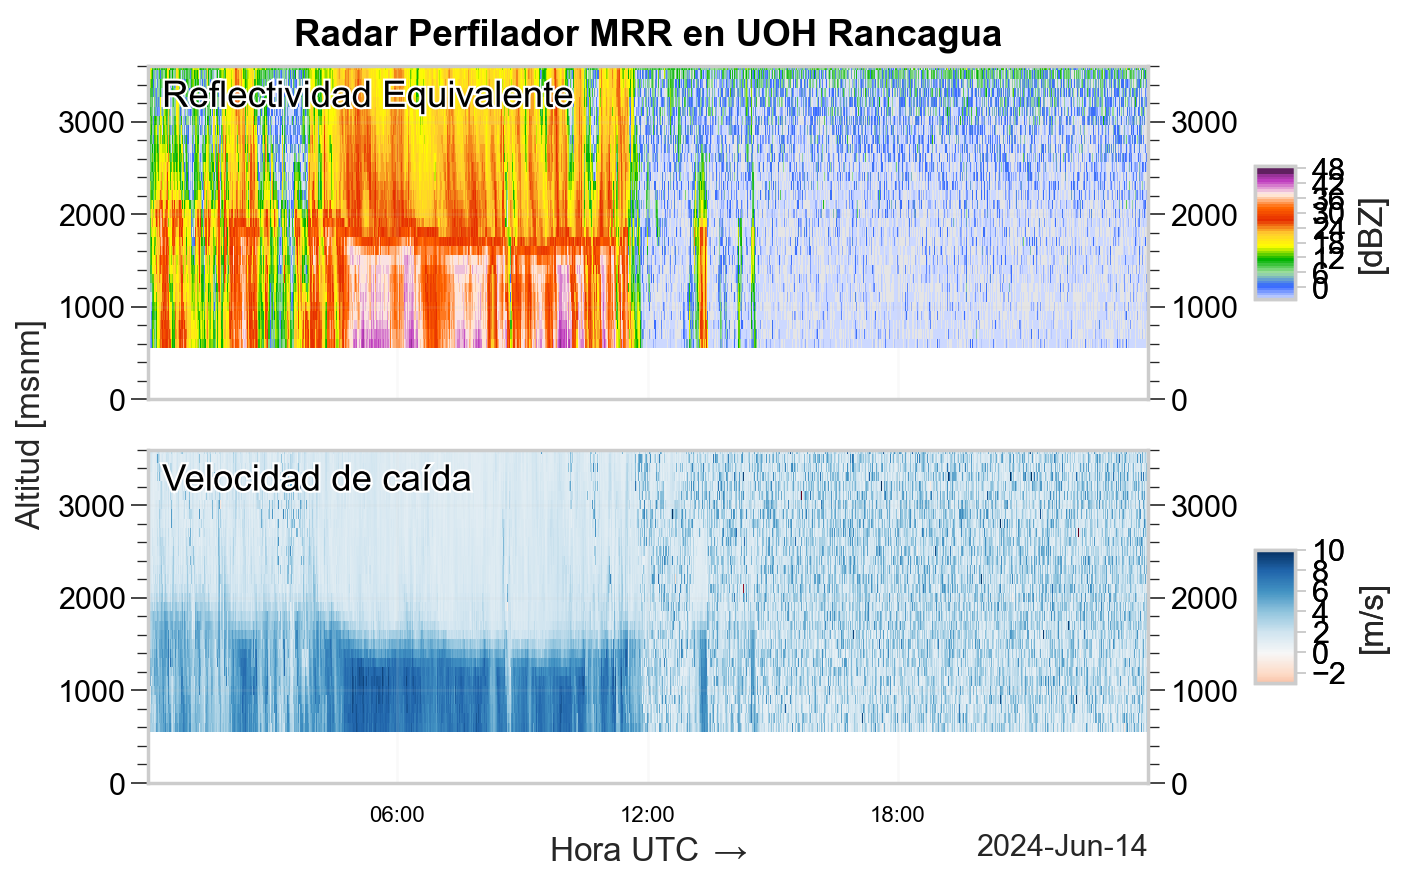

In [104]:
new_time_0614 = pd.to_datetime(ds_0614.time.values)
xlim_0614 = [new_time_0614[0], new_time_0614[-1]]
heights_0614 = ds_0614.height[0,:] + 500
Ze_0614 = ds_0614['attenuated_radar_reflectivity']
Vf_0614 = ds_0614['fall_velocity']
# llamar a la funcion para plotear
plot_mrr2(xlim_0614, pd.to_datetime(ds_0614.time.values), heights_0614, Ze_0614, Vf_0614, hora_local=False)

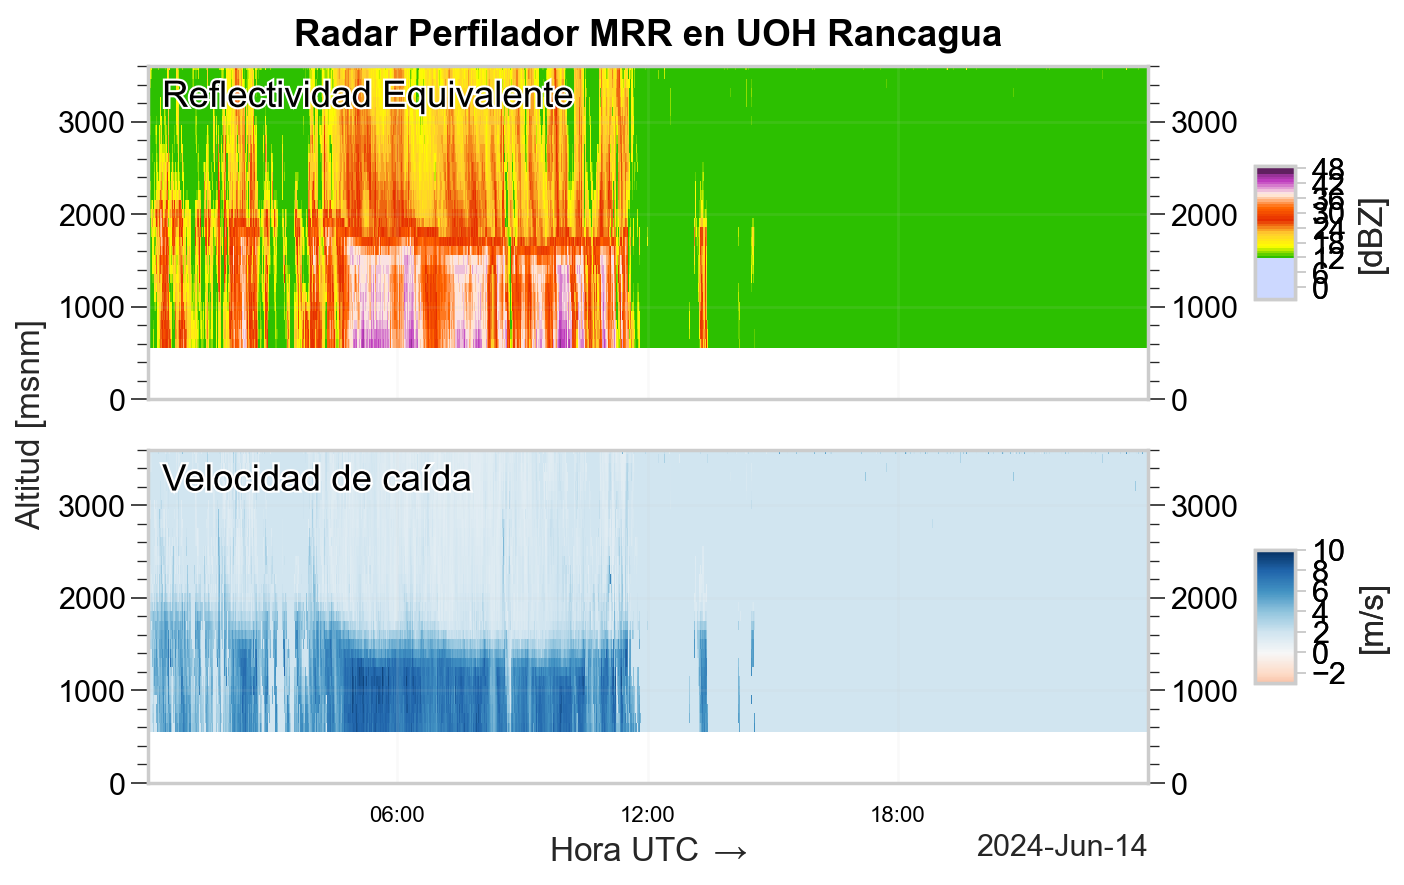

In [105]:
Ze_filtered_0614 = Ze_0614.where(Ze_0614 >= minimo_ref, minimo_ref)
Vf_filtered_0614 = np.where(Ze_0614 >= minimo_ref, Vf_0614, 2)

plot_mrr2(xlim_0614, pd.to_datetime(ds_0614.time.values), heights_0614, Ze_filtered_0614, Vf=Vf_filtered_0614, hora_local=False)

C:\Users\conyl\AppData\Local\Temp\ipykernel_14008\173114761.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


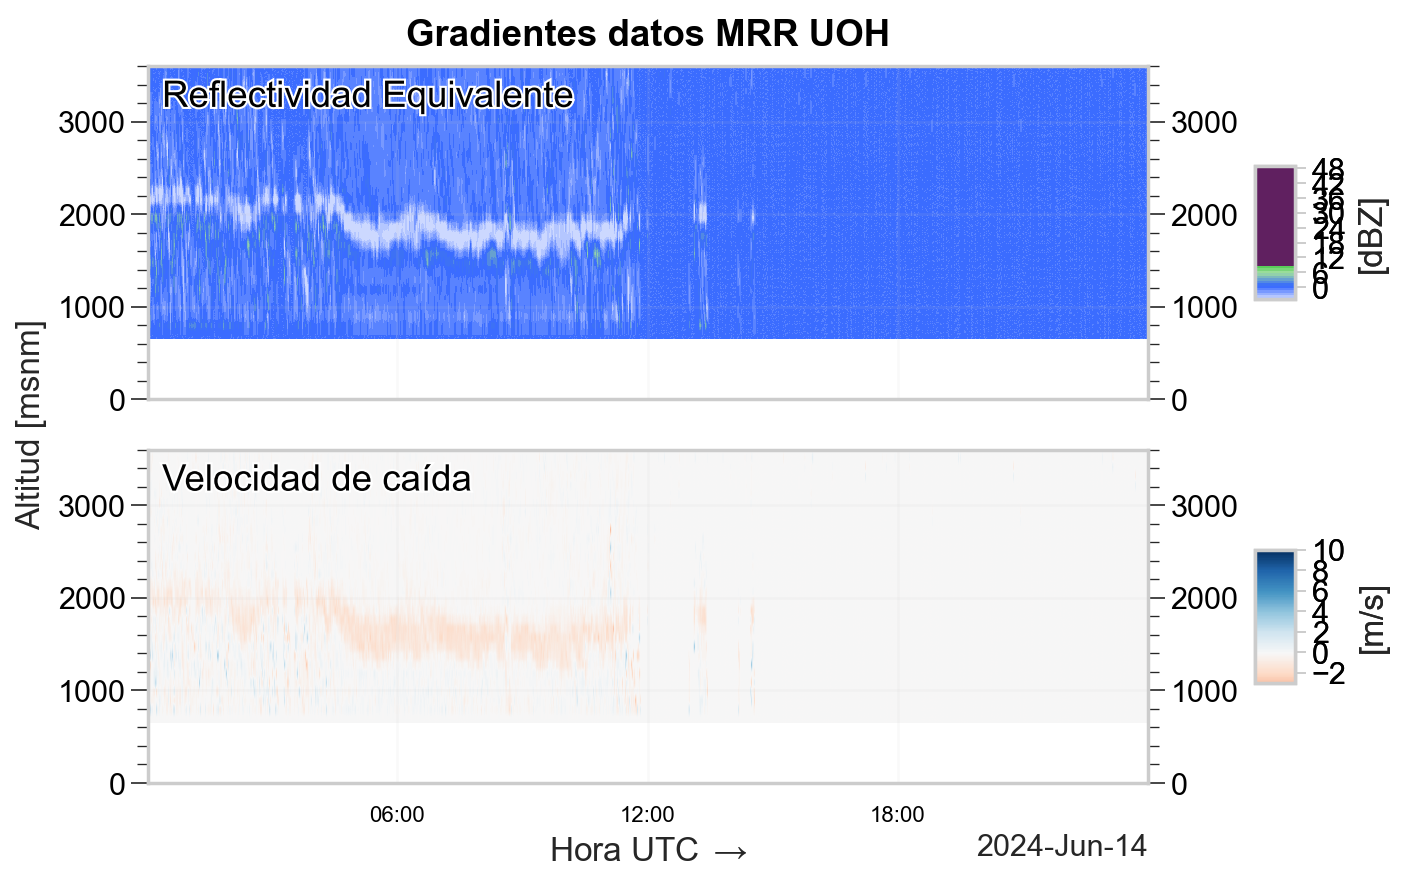

In [106]:
altura_inicial_desfase_0614 = 500 + (heights_0614[1] - heights_0614[0]) / 2   # Ajuste altura

heights_ajustado_0614 = ds_0614.height[0, :] + altura_inicial_desfase_0614

marco = 1
gradiente_Ze_0614 = calcular_gradiente(Ze_filtered_0614.T, marco)  # el problema, una vez más era la traspuesta
gradiente_Vf_0614 = calcular_gradiente(Vf_filtered_0614.T, marco)
plot_mrr3_imshow(xlim_0614, new_time_0614, heights_ajustado_0614, gradiente_Ze_0614, Vf=gradiente_Vf_0614, hora_local=False)

[{'iter': 0, 'altura_minima': 1812.5, 'gradiente_minimo': -0.3999999999999999}, {'iter': 1, 'altura_minima': 1843.75, 'gradiente_minimo': -0.23000000000000043}, {'iter': 2, 'altura_minima': 1859.375, 'gradiente_minimo': -0.39000000000000057}, {'iter': 3, 'altura_minima': 1742.1875, 'gradiente_minimo': -0.35999999999999943}, {'iter': 4, 'altura_minima': 1808.59375, 'gradiente_minimo': -0.41000000000000014}, {'iter': 5, 'altura_minima': 1966.796875, 'gradiente_minimo': -0.8699999999999992}, {'iter': 6, 'altura_minima': 1920.8984375, 'gradiente_minimo': 0.0}, {'iter': 7, 'altura_minima': 1897.94921875, 'gradiente_minimo': 0.0}, {'iter': 8, 'altura_minima': 1886.474609375, 'gradiente_minimo': 0.0}, {'iter': 9, 'altura_minima': 1880.7373046875, 'gradiente_minimo': 0.0}, {'iter': 10, 'altura_minima': 1877.86865234375, 'gradiente_minimo': 0.0}, {'iter': 11, 'altura_minima': 1751.434326171875, 'gradiente_minimo': -0.5899999999999999}, {'iter': 12, 'altura_minima': 1688.2171630859375, 'gradient

C:\Users\conyl\AppData\Local\Temp\ipykernel_14008\4273697507.py:127: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


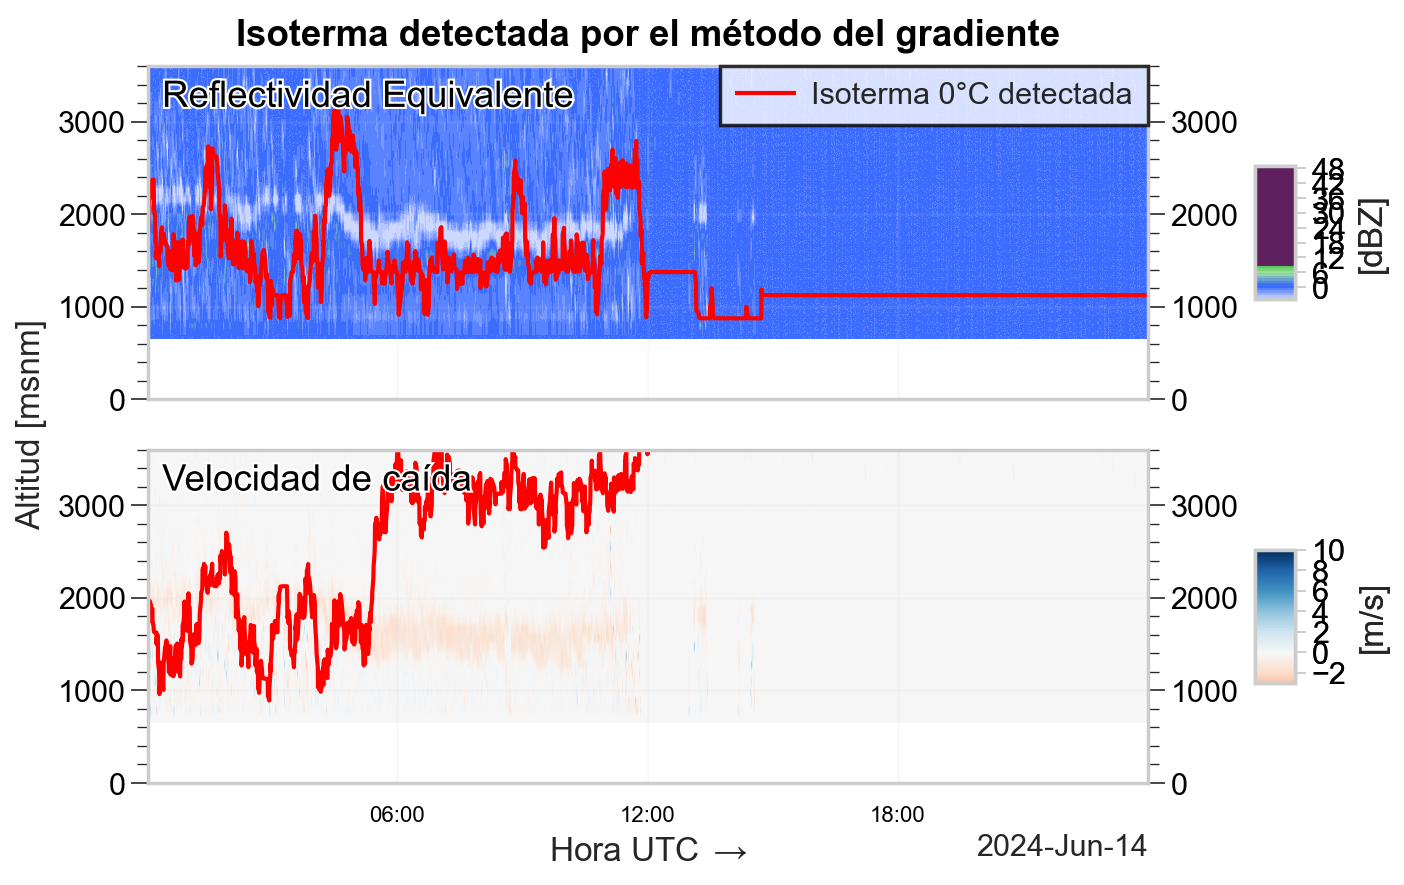

In [107]:
resultados_isoterma_Ze_0614 = detectar_isoterma_cero(gradiente_Ze_0614, altura_inicial=2000)
resultados_isoterma_Vf_0614 = detectar_isoterma_cero(gradiente_Vf_0614, altura_inicial=2000)
print(resultados_isoterma_Vf_0614)

# Graficar con la isoterma
plot_mrr3_imshow_con_isoterma(
    xlim_0614, 
    new_time_0614, 
    heights_ajustado_0614, 
    gradiente_Ze_0614, 
    resultados_isoterma_Ze_0614, 
    Vf=gradiente_Vf_0614, 
    isoterma_results_Vf=resultados_isoterma_Vf_0614
)

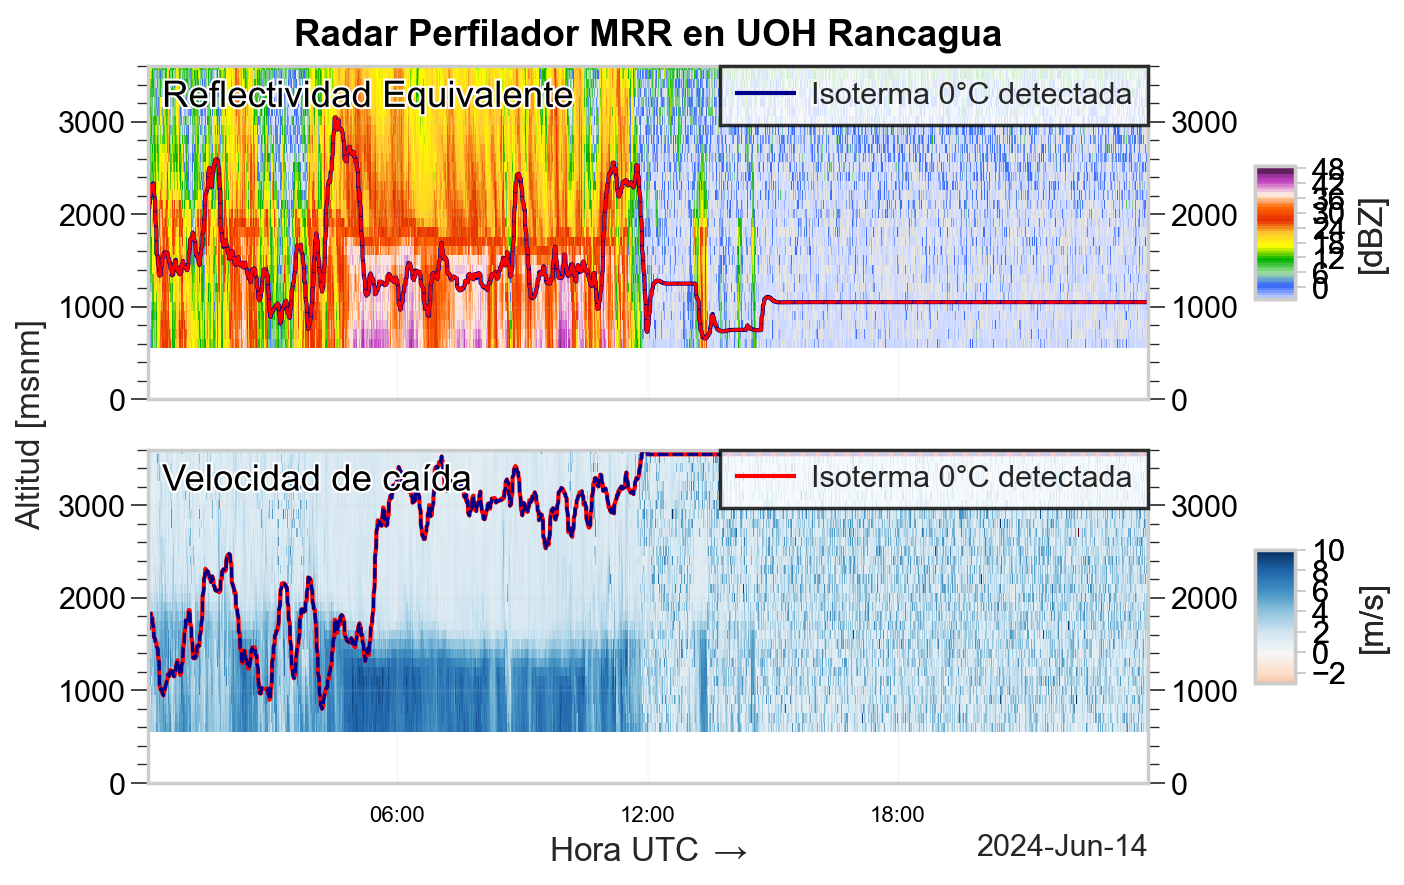

In [108]:
Ze_0614 = ds_0614['attenuated_radar_reflectivity'].T 
IndicesIsoterma_0614 = []
for resultado in resultados_isoterma_Ze_0614:
    t = resultado["iter"]
    altura_minima = resultado["altura_minima"]
    idx_altura = int((np.abs(heights_ajustado_0614 - altura_minima)).argmin())
    IndicesIsoterma_0614.append(idx_altura)

FactorConversion_0614 = (heights_0614[-1].values - 500) / len(heights_0614)
AlturasIsoterma_0614 = np.array(IndicesIsoterma_0614) * FactorConversion_0614

altura_inicial_desfase_0614 = 500 + (heights_0614[1].values - heights_0614[0].values) / 2
AlturasIsoterma_ajustadas_0614 = AlturasIsoterma_0614 + altura_inicial_desfase_0614

alturas_filtradas_0614, ganancias_0614, var_altura_0614, var_velocidad_0614, covar_0614, tasa_cambio_0614 = filtro_kalman(
    AlturasIsoterma_ajustadas_0614, 
    delta_t, 
    Q_ruido_proceso_reflectividad, 
    Q_ruido_proceso_gradiente, 
    R_ruido_medicion, 
    factor_ponderador
)

# Ajustar alturas_filtradas para que coincida con times
if len(alturas_filtradas_0614) < len(new_time_0614):
    alturas_filtradas_0614 = np.append([alturas_filtradas_0614[0]], alturas_filtradas_0614)
elif len(alturas_filtradas_0614) > len(new_time_0614):
    alturas_filtradas_0614 = alturas_filtradas_0614[:len(new_time_0614)]

IndicesIsoterma_Vf_0614 = []
for resultado in resultados_isoterma_Vf_0614:
    t = resultado["iter"]
    altura_minima = resultado["altura_minima"]
    idx_altura = int((np.abs(heights_ajustado_0614 - altura_minima)).argmin())
    IndicesIsoterma_Vf_0614.append(idx_altura)

AlturasIsoterma_Vf_0614 = np.array(IndicesIsoterma_Vf_0614) * FactorConversion_0614
AlturasIsoterma_ajustadas_Vf_0614 = AlturasIsoterma_Vf_0614 + altura_inicial_desfase_0614

alturas_filtradas_Vf_0614, ganancias_Vf_0614, var_altura_Vf_0614, var_velocidad_Vf_0614, covar_Vf_0614, tasa_cambio_Vf_0614 = filtro_kalman(
    AlturasIsoterma_ajustadas_Vf_0614, 
    delta_t, 
    Q_ruido_proceso_reflectividad, 
    Q_ruido_proceso_gradiente, 
    R_ruido_medicion, 
    factor_ponderador
)

# Ajustar alturas_filtradas_Vf para que coincida con times
if len(alturas_filtradas_Vf_0614) < len(new_time_0614):
    alturas_filtradas_Vf_0614 = np.append([alturas_filtradas_Vf_0614[0]], alturas_filtradas_Vf_0614)
elif len(alturas_filtradas_Vf_0614) > len(new_time_0614):
    alturas_filtradas_Vf_0614 = alturas_filtradas_Vf_0614[:len(new_time_0614)]

# Convertir la lista a array por si acaso
covarianzas_0614 = np.array(var_altura_0614)
desviacion_std_0614 = np.sqrt(covarianzas_0614)

# Intervalos de confianza
superior_0614 = alturas_filtradas_0614 + desviacion_std_0614
inferior_0614 = alturas_filtradas_0614 - desviacion_std_0614

# Convertir la lista a array por si acaso
covarianzas_Vf_0614 = np.array(var_altura_Vf_0614)
desviacion_std_Vf_0614 = np.sqrt(covarianzas_Vf_0614)

# Intervalos de confianza
superior_Vf_0614 = alturas_filtradas_Vf_0614 + desviacion_std_Vf_0614
inferior_Vf_0614 = alturas_filtradas_Vf_0614 - desviacion_std_Vf_0614

plot_mrr_Isotermas4(
    xlim=xlim_0614,
    times=new_time_0614,
    heights=heights_0614,
    Ze=Ze_0614.T,
    isoterma_Ze=alturas_filtradas_0614,  # Línea de isoterma filtrada
    Vf=Vf_0614,
    isoterma_Vf=alturas_filtradas_Vf_0614,
    hora_local=False,
    sd_sup_Ze=superior_0614,
    sd_inf_Ze=inferior_0614,
    sd_sup_Vf=superior_Vf_0614,
    sd_inf_Vf=inferior_Vf_0614
)

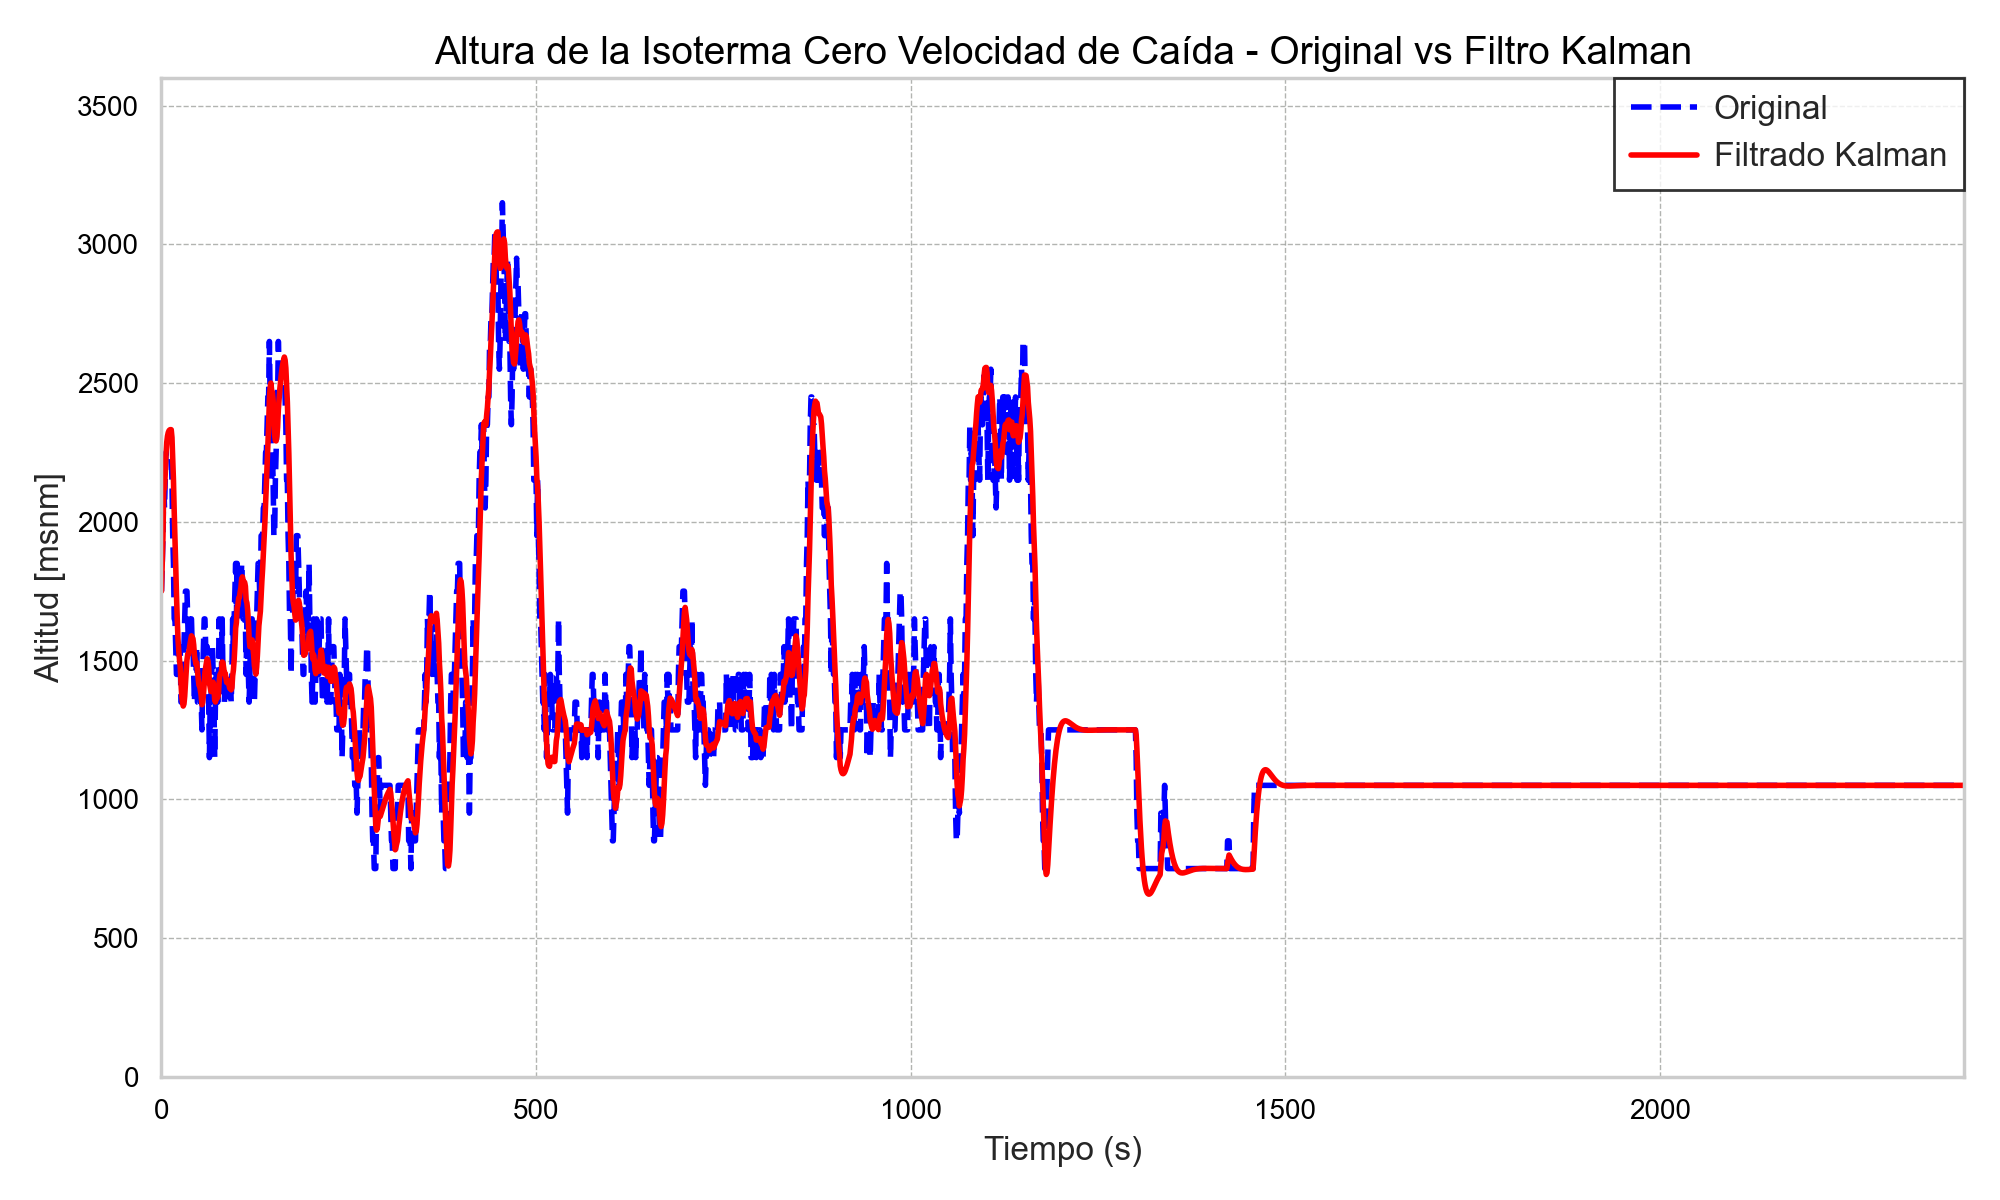

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))  
ax.plot(AlturasIsoterma_ajustadas_0614, label="Original", linestyle='--', color='blue', linewidth=2)
ax.plot(alturas_filtradas_0614, label="Filtrado Kalman", linestyle='-', color='red', linewidth=2)
ax.set_xlabel('Tiempo (s)', fontsize=12) 
ax.set_ylabel('Altitud [msnm]', fontsize=12)
ax.set_title('Altura de la Isoterma Cero Velocidad de Caída - Original vs Filtro Kalman', fontsize=14)
ax.set_xlim([0, len(AlturasIsoterma_0614)])  
ax.set_ylim([0, heights_0614[-1]])    # Quité el .values porque me tiraba error
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper right', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()  
plt.show()

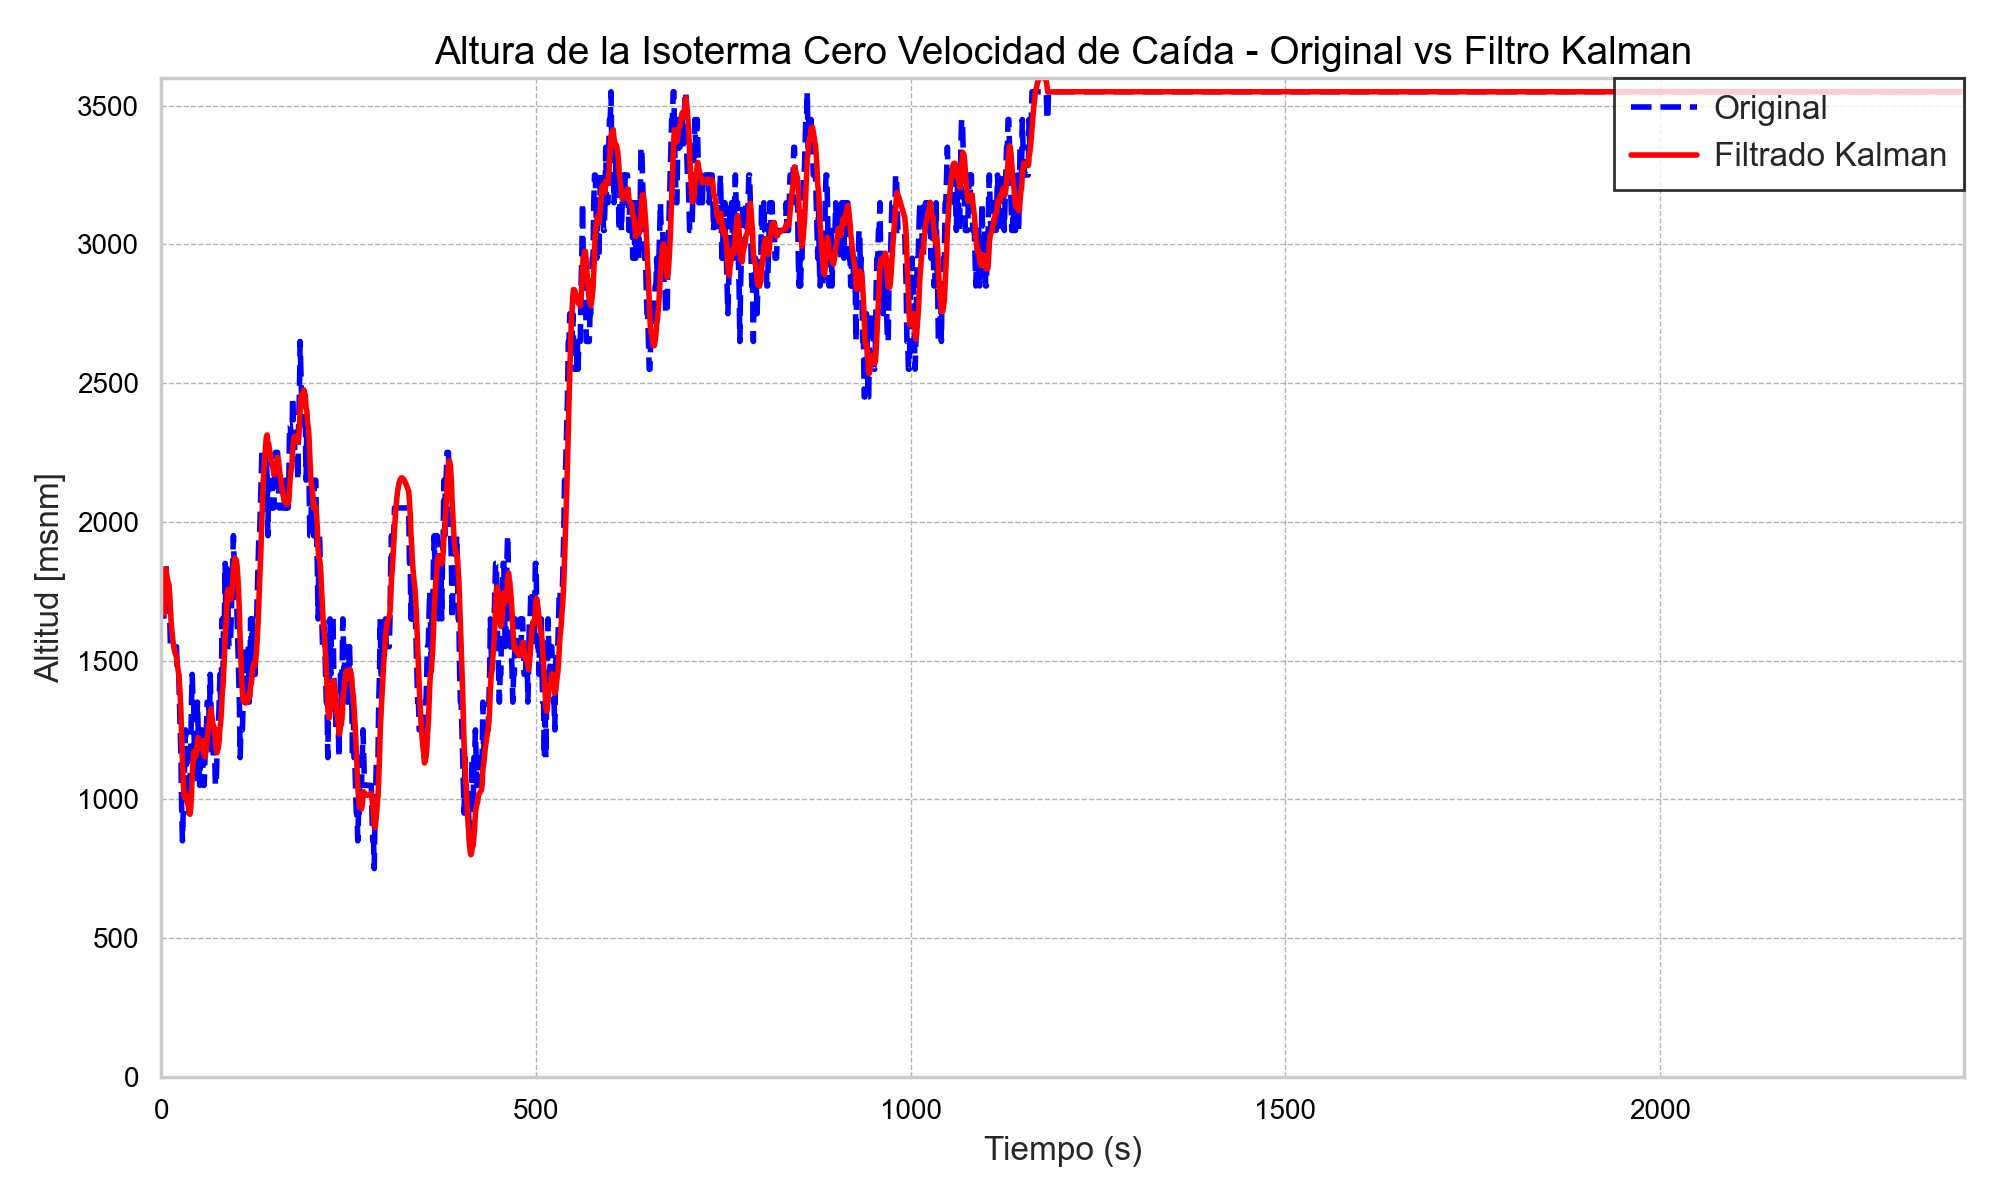

In [112]:
fig, ax = plt.subplots(figsize=(10, 6))  
ax.plot(AlturasIsoterma_ajustadas_Vf_0614, label="Original", linestyle='--', color='blue', linewidth=2)
ax.plot(alturas_filtradas_Vf_0614, label="Filtrado Kalman", linestyle='-', color='red', linewidth=2)
ax.set_xlabel('Tiempo (s)', fontsize=12) 
ax.set_ylabel('Altitud [msnm]', fontsize=12)
ax.set_title('Altura de la Isoterma Cero Velocidad de Caída - Original vs Filtro Kalman', fontsize=14)
ax.set_xlim([0, len(AlturasIsoterma_0614)])  
ax.set_ylim([0, heights_0614[-1]])    # Quité el .values porque me tiraba error
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper right', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()  
plt.show()

22/06/2024